# InstaScams

This notebook is dedicated to combatting scam accounts.
The inspiration is taken from `passports.saime.vzl`, a site
with 70k followers which pretends to be the official [SAIME](http://www.saime.gob.ve/)
website for Venezuelan citizens to get passports and immigration documents.

According to some comments which were deleted, the account is managed by
some people who do work at SAIME, but dozens of different users reported that the
site was fraudulent. The account gains trust by posting valid information about 
the visa process. Then it offers individual chats with more information.
But soon they will suggest that a fee of `$300` to `$3000`
will allow them to process the applications online. If paid, the victim will
never get their documents nor money back.

This site has been reported hundreds of times to Instagram, but no action has yet been taken.


## Indicators of Fraudulent Sites
Some things that might indicate that a site is fraudulent

* The account's name has been changed many times
* User comments are blocked
* Account claims to be "Official" but does is not [verified](https://help.instagram.com/733907830039577)

![saime_account.png](images/saime_account.png)

If you check the '...' "About" you see the account has been renamed many times.
![former_usernames.png](images/former_usernames.png)

# The Basics



In [128]:
import os
import requests
import json
from functools import reduce
from datetime import datetime

## Instaloader
Whenever possible, use instaloader for calls github.com/instaloader/instaloader  
https://instaloader.github.io/as-module.html


In [5]:
!pip install instaloader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 KB 776.1 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for instaloader: filename=instaloader-4.9.4-py3-none-any.whl size=62307 sha256=c88a21bf3a807cb13b82e0cc2fa1a9d46e8a1b37c9bbb5d7028cecbe9723b314
  Stored in directory: /tmp/pip-ephem-wheel-cache-uvkz5qg1/wheels/22/2e/69/a82ee5314382488c557ae65b2702df34821a296524ec897304
Successfully built instaloader


In [6]:
import instaloader

On the commandline, login via `instaloader login` to save creds to a file.
then the following call to load_session_from_file will work.

In [10]:
target_user = 'saime.pasaporte.ve'

L = instaloader.Instaloader()
# user to make posts with
post_user = 'defeatscammers'
# user to read profiles/posts
crawl_profile_user = 'defeatscammers'
# Optionally, login or load session
#L.login(user, PASSWORD)        # (login)
#L.interactive_login(user)      # (ask password on terminal)

L.load_session_from_file(crawl_profile_user)

profile = instaloader.Profile.from_username(L.context, target_user)

posts = profile.get_posts()


Loaded session from /home/jovyan/.config/instaloader/session-sergeidvorak86.


In [15]:
posts.count

163

# Investigations

## Check for comments
This account used to have open comments, but now almost all posts are closed to
comments and have had all comments removed

In [26]:
all_comments = {}
for index, post in enumerate(posts):
    comments = post.get_comments()
    comments_count = post.comments
    print('comments_count', comments_count)
    all_comments[post.shortcode] = comments
    print(comments)
    dl_post = L.download_post(post, target=target_user)
    print(dl_post)
    # print the first, then exit
    if index > 1:
        break

['__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']
comments_count 0
[]
saime.pasaporte.ve/2022-06-12_01-56-38_UTC_1.jpg saime.pasaporte.ve/2022-06-12_01-56-38_UTC_2.jpg saime.pasaporte.ve/2022-06-12_01-56-38_UTC_3.jpg [Pasaportes y prórrogas dispon…] json 
True
['__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', 

In [36]:
from glob import glob

def load_posts(target_user):
    posts = set(filter(lambda s: isinstance(s, instaloader.Post),
                           (instaloader.load_structure_from_file(L.context, file)
                            for file in (
                                glob(f'{target_user}/*.json.xz') + 
                                glob(f'{target_user}/*.json')))))
    return posts

posts = load_posts(target_user)
print(len(posts))

16


### Check for indicators of scam accounts

commenting_disabled_for_viewer
comments_disabled
is_verified

"transparency_product":"STATE_CONTROLLED_MEDIA"

### Inspect tagged posts

In [53]:
tagged_posts = list(profile.get_tagged_posts())
for tagged_post in tagged_posts:
    print(tagged_post)

<Post CigVEk0OFdm>
<Post CicLyHCD67w>
<Post CiauZWyJqFs>
<Post CiF6ixKueSX>
<Post Chw-2cZDh5q>
<Post ChmGybUunXx>
<Post Cg2fU6CuN09>
<Post Cf9E2JGOuin>
<Post CeZS8qiloJA>
<Post Cc50-pTLote>
<Post CNQ1ek3qEr->
<Post CMXLnVin2j4>


### Likes and Comments
For scam accounts, you will see a large number of likes and comments
being deleted. The victim may delete their like. The scammer will delete
critical comments.

In [58]:
def get_likes_and_comments(posts,
                           max_posts=2,
                           max_likes=2,
                           max_comments=2):
    interactions = {}
    posts_counter = 0
    for post in posts:
        shortcode = post.shortcode
        print(shortcode)
        interactions[shortcode] = {}
        likes_count = post.likes
        comments_count = post.comments
        print(f'post {shortcode} has {likes_count} likes and {comments_count} comments')
        if comments_count:
            comments = list(post.get_comments())
            interactions[shortcode]['comments'] = comments
            comment_counter = 0
            for comment in comments:
                print(comment)
                comment_counter += 1
                if max_comments and (comment_counter > max_comments):
                    break
        if likes_count:
            likes_counter = 0
            # Get profiles of likees
            likes = list(post.get_likes())
            interactions[shortcode]['likes'] = likes
            for like in likes:
                likes_counter += 1
                print('like', like)
                if max_likes and (likes_counter > max_likes):
                    break
        posts_counter += 1
        if max_posts and (posts_counter > max_posts):
            break
    return interactions

In [57]:
tagged_interactions = get_likes_and_comments(tagged_posts)
tagged_interactions[list(tagged_interactions.keys())[0]]

CigVEk0OFdm
post CigVEk0OFdm has 16 likes and 0 comments
like <Profile celsosotelo4 (48196323115)>
like <Profile guzman_roman_ (3975132953)>
like <Profile lourdes.leonett (12992011763)>
CicLyHCD67w
post CicLyHCD67w has 62 likes and 19 comments
PostComment(id=17957171915005113, created_at_utc=datetime.datetime(2022, 9, 13, 9, 59, 37), text='Gracias a ti ya tengo mi cita!!!', owner=<Profile militzaortizjewellery (52570307)>, likes_count=2, answers=<generator object Post.get_comments.<locals>._postcommentanswers at 0x7fb9e0cb2ba0>)
PostComment(id=17981575828628416, created_at_utc=datetime.datetime(2022, 9, 14, 21, 49, 21), text='Que emoción ❤️❤️ que te llegue rápido 🙏🏻🥳gracias por la info la voy a compartir yo ando en las mismas Me toca hacer un vídeo así 😵\u200d💫😁 me pidieron la info full ayer 😖', owner=<Profile biglatinflavours (1081773287)>, likes_count=1, answers=<generator object Post.get_comments.<locals>._postcommentanswers at 0x7fb9e0cb20b0>)
PostComment(id=18215875063087087, crea

{'likes': [<Profile celsosotelo4 (48196323115)>,
  <Profile guzman_roman_ (3975132953)>,
  <Profile lourdes.leonett (12992011763)>,
  <Profile regioneducativaaltosmir (3982252947)>,
  <Profile modesto_je1 (11125121734)>,
  <Profile espijos (3621870219)>,
  <Profile fonaamazonas_oficial (48869419680)>,
  <Profile aguzmanr90 (2056035841)>,
  <Profile drraulin (565390815)>,
  <Profile anaodalizdelgado (1966293755)>,
  <Profile lugoingridsanchez (53097722648)>,
  <Profile queralesisa (3921668645)>,
  <Profile wendygomez7430 (4545217995)>,
  <Profile marciamiranda3567 (1348342205)>,
  <Profile dr_rommel_martinezh (9363886127)>,
  <Profile dpdmiranda (7160907183)>]}

# Get Diffs
Previous snapshot of posts, comments, likes etc are loaded from disk. 
Current snapshots are gotten from Instagram. Report any deleted or new posts.


In [60]:
def get_posts_diff(target_user):
    # Obtain set of posts that are on hard disk
    offline_posts = set(filter(lambda s: isinstance(s, Post),
                           (load_structure_from_file(L.context, file)
                            for file in (
                                glob(f'{target_user}/*.json.xz') + 
                                glob(f'{target_user}/*.json')))))

    post_iterator = Profile.from_username(L.context, target_user).get_posts()
    online_posts = set(post_iterator)

    new_posts = online_posts - offline_posts
    if online_posts - offline_posts:
        print("Not yet downloaded posts:")
        print(" ".join(str(p) for p in (new_posts)))
    for post in new_posts:
        # 2022-07-22_16-02-32_UTC.json
        timestamp = post.date_utc
        instaloader.save_structure_to_file(post, f'{target_user}/{timestamp}.json)')

    deleted_posts = offline_posts - online_posts
    if deleted_posts:
        print("Deleted posts:")
        print(" ".join(str(p) for p in (deleted_posts)))
                                           
    # __eq__ only comparse shortcodes https://github.com/instaloader/instaloader/blob/3cc29a4ceb3ff4cd04a73dd4b20979b03128f454/instaloader/structures.py#L182
    # Now we need to dive deeper into comments and likes from previously existing posts.
    # Compare the online and offline comments and likes
    online_shortcode_dict = {x.shortcode: x for x in online_posts}
    offline_shortcode_dict = {x.shortcode: x for x in offline_posts}
    intersection_posts = online_posts.intersection(offline_posts)
    new_interactions = {'likes': {}, 'comments': {}}
    deleted_interactions = {'likes': {}, 'comments': {}}
    for post in intersection_posts:
        online_interactions = get_likes_and_comments(
            [online_shortcode_dict[post.shortcode]])
        offline_interactions = get_likes_and_comments(
            [offline_shortcode_dict[post.shortcode]])
        new_interactions['likes'][post.shortcode] = set(online_interactions['likes']) \
            - set(offline_interactions['likes'])
        deleted_interactions['likes'][post.shortcode] = set(offline_interactions['likes']) \
            - set(online_interactions['likes'])

    return new_posts, deleted_posts


SyntaxError: invalid syntax (1958001237.py, line 29)

## Saime shortcodes

In [96]:
# Manually gathered shortcodes (right click) on homepage
saime_post_shortcodes = [
    'CfPAvzkOPq6',
    'Cev_amPu-3X',
    'CemmG8_MIMb',
    'Ceml3JbMHiT',
    'CeiN4KuuDJf',
    'CeiNK0DuLXr',
    'CeiL_uoupB7',
    'Ceb2mWaD2MD',
    'CdNLaPmussG',
    'CdAVhkssfpB',
    'Cc6u6lUspmS',
    'Cc6h4EYslRe'
]

saime_video_shortcodes = [
    'Ceb2mWaD2MD',
    'CZminxDDJl2',
    'CZi3_4kAdRA',
    'CXjYn8Qp39V',
    'CWd85Z2D1nG',
    'CVT9HaMjWLA',
]


In [97]:
shortcodes = [
'CfPAvzkOPq6',
'Cev_amPu-3X',
'CemmG8_MIMb',
'Ceml3JbMHiT',
'CeiN4KuuDJf',
'CeiNK0DuLXr',
'CeiL_uoupB7',
'Ceb2mWaD2MD',
'CdNLaPmussG',
'CdAVhkssfpB',
'Cc6u6lUspmS',
'Cc6h4EYslRe',
'Ceb2mWaD2MD',
'CZminxDDJl2',
'CZi3_4kAdRA',
'CXjYn8Qp39V',
'CWd85Z2D1nG',
'CVT9HaMjWLA',
'CTJN_sBjavf',
'CTAmn2Pphl5',
'CSyNe_0jNvq',
'CSpq4fLD3HE',
'CSfnrlHDTi2',
'CSZ0DRyj1tB',
]

set(shortcodes).intersection(set(saime_post_shortcodes))

{'Cc6h4EYslRe',
 'Cc6u6lUspmS',
 'CdAVhkssfpB',
 'CdNLaPmussG',
 'Ceb2mWaD2MD',
 'CeiL_uoupB7',
 'CeiN4KuuDJf',
 'CeiNK0DuLXr',
 'Ceml3JbMHiT',
 'CemmG8_MIMb',
 'Cev_amPu-3X',
 'CfPAvzkOPq6'}

In [98]:
set(shortcodes).intersection(set(saime_video_shortcodes))

{'CVT9HaMjWLA',
 'CWd85Z2D1nG',
 'CXjYn8Qp39V',
 'CZi3_4kAdRA',
 'CZminxDDJl2',
 'Ceb2mWaD2MD'}

In [99]:
len(shortcodes)

24

## Post Comments Unit Test 2859783193106312663 
June 18, first picture on square grid profile. 

https://www.instagram.com/p/Cev_amPu-3X/
```
47 mins ago
yuramyborges
Buenas tardes disculpe quería saber sobre de un pasaporte que saqué el 
11 de marzo acá en Ecuador pero no me ha llegado solamente me llegó el 
anuncio de impresión gracias
```
```
3d ago
ccqhud270
Buenas tardes quisiera informacion sobre un pasaporte, 
que estoy necesitando, sería express se encuentra en Chile y quiere 
regresar a Venezuela. Ya su pasaporte tiene dos prórrogas y se vence en 
Marzo 2023 . Agradecida de antemano me puedan orientar
```

## Video Comments Unit Test 2854114918780592899

In [104]:
media_id = 2854114918780592899
get_comments_user_text(media_id)

/opt/conda/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'host.docker.internal'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


[{'user_id': 51942343913,
  'comment_create_at_utc': '2022-06-07 22:36:56',
  'text': 'Los pasaportes de la Urbina, por favor alguien q me conteste, por favor',
  'username': 'josegallardo2909',
  'full_name': 'José gallardo',
  'child_comment_count': 0,
  'child_comments': []},
 {'user_id': 5724296318,
  'comment_create_at_utc': '2022-06-05 20:25:02',
  'text': 'La gente se salió de Venezuela 😂😂',
  'username': 'giseleli1',
  'full_name': 'Gisela Roa',
  'child_comment_count': 0,
  'child_comments': []}]

In [ ]:
### Highlighted Data Captured

Data
Denuncio cuenta IG @saime_redoficial estafador con 
CI 24.237.821 
se llama Luis Ramón Gonzalez Moreno 
cuenta bco vzla con 
celular 04120346974 es funcionario 
Saime que roba a usuarios en oficina plaza Caracas 
y la mamá en Saime sede Propatria


**Facebook**

Saime Pasaporte (Official)  
Joshua Fernando Castro Reyes  
No es por nada eso es una estafa saben el tipo es un venezolano que asta ami persona estafó me dijo que publicará eso mismo y que me pagaría 10 mil pesos por día y como uno anda nesecitado de trabajo ps cuando lo resulte cobrando nunca me pago asta el día de hoy se desentendido así que ya saben no caigan en cuento es una estafa

# References

https://towardsdatascience.com/discover-insights-from-your-instagram-business-account-with-facebook-graph-api-and-python-81d20ee2e751

# Still need to port these functions

## Post Comments

In [165]:
def request_follow(user_id):
    '''
    We need a non-bot account likely of being followed back
    '''
    burp0_url = f"https://www.instagram.com/web/friendships/{user_id}/follow/"
    follow_request = get_burp(burp0_url, method="POST")
    return follow_request
    
def post_comment_by_id(media_id, comment, dry_run=False):

    burp0_url = f"https://www.instagram.com:443/web/comments/{media_id}/add/"
    # TODO manage cookies better
    burp0_data = {"comment_text": comment, "replied_to_comment_id": ''}
    if dry_run:
        print(f'dry-run, would have posted {comment} to media_id {media_id}')
        return {'media_id': 'dry_run', 
                'comment': 'dry_run', 
                'status': 'dry_run'}
    else:
        response = post_session.post(burp0_url, data=burp0_data)
    if response and isinstance(response, requests.Response):
        if (response.status_code == 200):
            return response.json()
        else:
            return response.text
    else:
        print('failed to post_comment by id')
        print(response.text)
        print(response)
        print(type(response))
        return None
    
def post_comment(user, comment, dry_run=False):
    '''
    Post a new comment if we haven't before
    '''
    with open('bot_comments.json', 'r') as f:
        bot_comments = json.load(f)
    media_comment = get_most_recently_commented_on_post(user)
    username = user['username']
    if not media_comment:
        print(f'No media found for {username} to comment on')
        print(request_follow(user['id']))
        return None
    media_id = media_comment['media_id']
    commented_usernames = [x['username'] for x in bot_comments]
    print('commented_usernames', commented_usernames)
    if not media_id:
        print('No media_ids, possibly private. Request follow')
        request_follow(username)
    else:
        shortcode = media_comment['shortcode']
        if username in commented_usernames:
            print(f'''Already posted to media_id {media_id}
            shortcode: {shortcode}, username: {username}''')
            return None
        print(f'Posting to media_comment: {media_comment}')
        response = post_comment_by_id(media_id, comment, dry_run=dry_run)
        if not response:
            print(f'Could not post to {username}. No comments found for {media_id}')
            return None
        if response['status'] == 'ok':
            bot_comments.append({'username': username, 
                                 'media_id': media_id, 
                                 'shortcode': shortcode, 
                                 'comment': comment,
                                 'comment_id': response['id'],
                                 'created_time': response['created_time']
                                })
            print(f'posted comment to {username} at {shortcode}')
            with open('bot_comments.json', 'w') as f:
                json.dump(bot_comments, f)
            return response['id']
        else:
            if not dry_run:
                print('Post comment failed: {response}')
    print(f'Post comment failed for media_id {media_id}')
    return None

def delete_comment(media_id, comment_id):
    burp0_url = f"https://www.instagram.com:443/web/comments/{media_id}/delete/{post_id}/"
    response = session.post(burp0_url, headers=burp0_headers, cookies=burp0_cookies)
    return response

def get_most_recently_commented_on_post(user):
    '''
    To contact a user, we will find there most recent post with
    a comment and 
    '''
    since_date = '00-00-00'
    latest_comments = get_latest_commenters(user, since_date)
    return latest_comments[0] if len(latest_comments) > 0 else None
    

comment = 'denuncia https://enlabajaita.com/2021/08/22/reportan-cuenta-falsa-en-instagram-la-cual-se-esta-haciendo-pasar-por-la-del-saime-oficial/'

#post_id = post_comment('ibangely3544', comment)
#print(post_id)


https://www.instagram.com/web/friendships/51240459/follow/
{'Sec-Ch-Ua': '"Chromium";v="103", ".Not/A)Brand";v="99"', 'X-Ig-App-Id': '936619743392459', 'X-Ig-Www-Claim': 'hmac.AR3cHYdS54gPvXgUiRaipufB2m_IrN6Nvm_AKrUTc3wPUYY6', 'Sec-Ch-Ua-Mobile': '?0', 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.5060.134 Safari/537.36', 'Viewport-Width': '1282', 'Accept': '*/*', 'X-Csrftoken': 'JOCnHlKMeVgWCeMuCkKY4R91vRfRr09W', 'X-Requested-With': 'XMLHttpRequest', 'X-Asbd-Id': '198387', 'Sec-Ch-Prefers-Color-Scheme': 'light', 'Sec-Ch-Ua-Platform': '"macOS"', 'Sec-Fetch-Site': 'same-origin', 'Sec-Fetch-Mode': 'cors', 'Sec-Fetch-Dest': 'empty', 'Referer': 'https://www.instagram.com/pasaportes.saime.vzl/', 'Accept-Encoding': 'gzip, deflate', 'Accept-Language': 'en-US,en;q=0.9'}
{'ig_did': '07BA6272-7014-4640-8CAA-6155081405BC', 'ig_nrcb': '1', 'mid': 'YpvGEwALAAEg98sF7Yyxj7QocLpY', 'datr': 'UsabYpWq2kOaE6bhkS5m32JN', 'dpr': '2', 'shbid': '
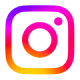
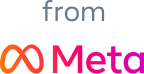

JSONDecodeError: [Errno Expecting value] <!DOCTYPE html>
<html lang="en" class="no-js not-logged-in client-root">
    <head>
        <meta charset="utf-8">
        <meta http-equiv="X-UA-Compatible" content="IE=edge">

        <title>
Login • Instagram
</title>

        
        <meta name="robots" content="noimageindex, noarchive">
        <meta name="apple-mobile-web-app-status-bar-style" content="default">
        <meta name="mobile-web-app-capable" content="yes">
        <meta name="theme-color" content="#ffffff">
        
        <meta id="viewport" name="viewport" content="width=device-width, initial-scale=1, minimum-scale=1, maximum-scale=1, viewport-fit=cover">
        <link rel="manifest" href="/data/manifest.json">

        <link rel="preload" href="/static/bundles/es6/ConsumerUICommons.css/18ce98a1c4fd.css" as="style" type="text/css" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/es6/Consumer.css/dc94bd93750a.css" as="style" type="text/css" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/es6/FBSignupPage.css/55ba8f05e763.css" as="style" type="text/css" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/es6/LoginAndSignupPage.css/3ce984c47339.css" as="style" type="text/css" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/es6/Vendor.js/17711fe62512.js" as="script" type="text/javascript" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/es6/en_US.js/ef7137b3f7c4.js" as="script" type="text/javascript" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/es6/ConsumerLibCommons.js/31944b297d48.js" as="script" type="text/javascript" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/es6/ConsumerUICommons.js/f0da9a64bb5c.js" as="script" type="text/javascript" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/es6/ConsumerAsyncCommons.js/c4ca4238a0b9.js" as="script" type="text/javascript" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/es6/Consumer.js/21084d10a847.js" as="script" type="text/javascript" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/es6/FBSignupPage.js/6ddf29479863.js" as="script" type="text/javascript" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/es6/LoginAndSignupPage.js/8c6fa0053468.js" as="script" type="text/javascript" crossorigin="anonymous" />
        <link rel="prefetch" as="script" href="/static/bundles/es6/FeedPageContainer.js/c8713aa8457c.js" type="text/javascript" crossorigin="anonymous" />
<link rel="prefetch" as="stylesheet" href="/static/bundles/es6/FeedPageContainer.css/0ce944ab9d5c.css" type="text/css" crossorigin="anonymous" />
        

        <script type="text/javascript">
        (function() {
  var docElement = document.documentElement;
  var classRE = new RegExp('(^|\\s)no-js(\\s|$)');
  var className = docElement.className;
  docElement.className = className.replace(classRE, '$1js$2');
})();
</script>
        <script type="text/javascript">
(function() {
  if ('PerformanceObserver' in window && 'PerformancePaintTiming' in window) {
    window.__bufferedPerformance = [];
    var ob = new PerformanceObserver(function(e) {
      window.__bufferedPerformance.push.apply(window.__bufferedPerformance,e.getEntries());
    });
    ob.observe({entryTypes:['paint']});
  }

  window.__bufferedErrors = [];
  window.onerror = function(message, url, line, column, error) {
    window.__bufferedErrors.push({
      message: message,
      url: url,
      line: line,
      column: column,
      error: error
    });
    return false;
  };
  window.__initialData = {
    pending: true,
    waiting: []
  };
  function asyncFetchSharedData(extra) {
    var sharedDataReq = new XMLHttpRequest();
    sharedDataReq.onreadystatechange = function() {
          if (sharedDataReq.readyState === 4) {
            if(sharedDataReq.status === 200){
              var sharedData = JSON.parse(sharedDataReq.responseText);
              window.__initialDataLoaded(sharedData, extra);
            }
          }
        }
    sharedDataReq.open('GET', '/data/shared_data/', true);
    sharedDataReq.send(null);
  }
  function notifyLoaded(item, data) {
    item.pending = false;
    item.data = data;
    for (var i = 0;i < item.waiting.length; ++i) {
      item.waiting[i].resolve(item.data);
    }
    item.waiting = [];
  }
  function notifyError(item, msg) {
    item.pending = false;
    item.error = new Error(msg);
    for (var i = 0;i < item.waiting.length; ++i) {
      item.waiting[i].reject(item.error);
    }
    item.waiting = [];
  }
  window.__initialDataLoaded = function(initialData, extraData) {
    if (extraData) {
      for (var key in extraData) {
        initialData[key] = extraData[key];
      }
    }
    notifyLoaded(window.__initialData, initialData);
  };
  window.__initialDataError = function(msg) {
    notifyError(window.__initialData, msg);
  };
  window.__additionalData = {};
  window.__pendingAdditionalData = function(paths) {
    for (var i = 0;i < paths.length; ++i) {
      window.__additionalData[paths[i]] = {
        pending: true,
        waiting: []
      };
    }
  };
  window.__additionalDataLoaded = function(path, data) {
    if (path in window.__additionalData) {
      notifyLoaded(window.__additionalData[path], data);
    } else {
      console.error('Unexpected additional data loaded "' + path + '"');
    }
  };
  window.__additionalDataError = function(path, msg) {
    if (path in window.__additionalData) {
      notifyError(window.__additionalData[path], msg);
    } else {
      console.error('Unexpected additional data encountered an error "' + path + '": ' + msg);
    }
  };
  
})();
</script><script type="text/javascript">

/*
 Copyright 2018 Google Inc. All Rights Reserved.
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
*/

(function(){function g(a,c){b||(b=a,f=c,h.forEach(function(a){removeEventListener(a,l,e)}),m())}function m(){b&&f&&0<d.length&&(d.forEach(function(a){a(b,f)}),d=[])}function n(a,c){function k(){g(a,c);d()}function b(){d()}function d(){removeEventListener("pointerup",k,e);removeEventListener("pointercancel",b,e)}addEventListener("pointerup",k,e);addEventListener("pointercancel",b,e)}function l(a){if(a.cancelable){var c=performance.now(),b=a.timeStamp;b>c&&(c=+new Date);c-=b;"pointerdown"==a.type?n(c,
a):g(c,a)}}var e={passive:!0,capture:!0},h=["click","mousedown","keydown","touchstart","pointerdown"],b,f,d=[];h.forEach(function(a){addEventListener(a,l,e)});window.perfMetrics=window.perfMetrics||{};window.perfMetrics.onFirstInputDelay=function(a){d.push(a);m()}})();
</script>

                
                    <link rel="apple-touch-icon-precomposed" sizes="76x76" href="/static/images/ico/apple-touch-icon-76x76-precomposed.png/666282be8229.png">
                    <link rel="apple-touch-icon-precomposed" sizes="120x120" href="/static/images/ico/apple-touch-icon-120x120-precomposed.png/8a5bd3f267b1.png">
                    <link rel="apple-touch-icon-precomposed" sizes="152x152" href="/static/images/ico/apple-touch-icon-152x152-precomposed.png/68193576ffc5.png">
                    <link rel="apple-touch-icon-precomposed" sizes="167x167" href="/static/images/ico/apple-touch-icon-167x167-precomposed.png/4985e31c9100.png">
                    <link rel="apple-touch-icon-precomposed" sizes="180x180" href="/static/images/ico/apple-touch-icon-180x180-precomposed.png/c06fdb2357bd.png">
                
                
                    
                        <link rel="icon" sizes="192x192" href="/static/images/ico/favicon-192.png/68d99ba29cc8.png">
                    
                
            
            
                    
                        <link rel="shortcut icon" type="image/x-icon" href="/static/images/ico/favicon.ico/36b3ee2d91ed.ico">
                    
                
            
            
            

                    <meta content="Welcome back to Instagram. Sign in to check out what your friends, family &amp; interests have been capturing &amp; sharing around the world." name="description" />
                    <link rel="canonical" href="https://www.instagram.com/accounts/login/" />
                
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/" hreflang="x-default" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=en" hreflang="en" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=fr" hreflang="fr" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=it" hreflang="it" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=de" hreflang="de" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=es" hreflang="es" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=zh-cn" hreflang="zh-cn" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=zh-tw" hreflang="zh-tw" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=ja" hreflang="ja" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=ko" hreflang="ko" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=pt" hreflang="pt" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=pt-br" hreflang="pt-br" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=af" hreflang="af" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=cs" hreflang="cs" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=da" hreflang="da" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=el" hreflang="el" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=fi" hreflang="fi" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=hr" hreflang="hr" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=hu" hreflang="hu" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=id" hreflang="id" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=ms" hreflang="ms" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=nb" hreflang="nb" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=nl" hreflang="nl" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=pl" hreflang="pl" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=ru" hreflang="ru" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=sk" hreflang="sk" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=sv" hreflang="sv" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=th" hreflang="th" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=tl" hreflang="tl" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=tr" hreflang="tr" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=hi" hreflang="hi" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=bn" hreflang="bn" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=gu" hreflang="gu" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=kn" hreflang="kn" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=ml" hreflang="ml" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=mr" hreflang="mr" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=pa" hreflang="pa" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=ta" hreflang="ta" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=te" hreflang="te" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=ne" hreflang="ne" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=si" hreflang="si" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=ur" hreflang="ur" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=vi" hreflang="vi" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=bg" hreflang="bg" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=fr-ca" hreflang="fr-ca" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=ro" hreflang="ro" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=sr" hreflang="sr" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=uk" hreflang="uk" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=zh-hk" hreflang="zh-hk" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=es-la" hreflang="es-cr" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=es-la" hreflang="es-ni" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=es-la" hreflang="es-sv" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=es-la" hreflang="es-cu" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=es-la" hreflang="es-co" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=es-la" hreflang="es-do" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=es-la" hreflang="es-ec" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=es-la" hreflang="es-ve" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=es-la" hreflang="es-bo" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=es-la" hreflang="es-py" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=es-la" hreflang="es-pa" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=es-la" hreflang="es-gt" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=es-la" hreflang="es-cl" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=es-la" hreflang="es-ar" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=es-la" hreflang="es-hn" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=es-la" hreflang="es-pr" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=es-la" hreflang="es-uy" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=es-la" hreflang="es-pe" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=es-la" hreflang="es-mx" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=en-gb" hreflang="en-gb" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=sw-ke" hreflang="sw-ke" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=ha-ng" hreflang="ha-ng" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=am-et" hreflang="am-et" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/web/friendships/51240459/follow/&amp;hl=om-et" hreflang="om-et" />

</head>
    <body class="loading" style="">
        
<div id="react-root">
  
  
  
  <img width="80px" height="80px" style="position:absolute;top:50%;left:50%;margin:-40px 0 0 -40px"
    src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAFAAAABQCAYAAACOEfKtAAAACXBIWXMAAAsTAAALEwEAmpwYAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAABPUSURBVHgB7VwNlB1Flf6q3/+8NzNAAhHkZ0mAYAxwEDiaBGJwQYkIbjDJIbhmhdUIrKDRheiuYFbOYbO7uLBx9yjmoBI8QZKAyhIQVyAhsORIQEGCURQiCEFASDIz77+7/Kqq+3X3e90z770ZNOHMzbm59fqnuvrrW/feulU1wDiN0ziN0ziNU5ckMMa0HDJZAw6uAFNZ+eHkCQ6wfxLo5em0BWTJSQE7I1BPJuEkBBwrAdvicSQhBa+FBVvLNDmhpZA8h5SW6piwE5AyA6smIO00ZDWJRDWBepX1lFNwdqdgkfG8g/KLArltU3DAbowxjRrAOQTs+AyOTAl8xJKYJSVmCwd9FlETjnmA4gS8smTZIdsEyUiCSWDUcXPOACX1PQQASc1Cy1SjLPT5pMsJzVLf65Utl9UxfiQC7+wEnB9ZqP44j/rmPI59CaOkUQH4uR55oiXwD3znDwmJSQQQls0TShI8/dt9iOWyAU69lJJ1SkcDmdIva7sAGQA9cDwAPUAtlqmRuh4PxIRbv9FeDzwPSEdL0fho0mb5KX6su21UruvH9NfRJXUF4BX9coqw8Z9s01kELq3BcjWuUQ6AlmyUHVfDbA1kUrM5lnJfMqXPma6bdLUy1dA2o3kGGKE5qQESAbDQKIsGkI6Wwv1YBkhbn2d5j0DthjSc6wVO3IUOqWMAl/XJuXzuDWzHMQlptIxgNqR3zOuyQc1IaA3zwVMyrV9KSekCCg2qZ/uM5kkXOL/rWq4MPseTaAJQaNB8AD0QDXuAOt+nTf6swMnPowNqG8AlkKkJ/VjK560gSEK4XdSTCQVeoNsGu1bCBSWpu6zRupRbTunjCjDb1TbZkK6zcOsQobJwtc5ywTQaLxt21nKlB54CDa4Uumw+HBpcV8f+CNTmCsx6tE1YdBvbookFXEhwrmbDhG6sDHAAvKQPXpHXvUxNepH3DBIkekaU+ZJ7CFyJx8vsfjYBdNLawCsAHak0jywtDazldlEFjuV6Zg2FluoyXiFS+pFOjkAV+Mw+nsjwvh4C1cvfR/LcgTwnhAuiAhQuiD4rciaQvyPx/38rMPNn7eDSlgb+y35ynnRwu6U0T/q2rqF1ju66Fb7Fo6zwB3y1LQxltl4OUcFeQBK/259adhrB+WvyXGrbUZTCANeshVrSW9vvEThzxO48IoBfmSDfgSrWE5RpCryE+YhIunYvUdfyCWrctXuAe5ZBDGAvJolfTSY4BNG+ltzng1hvll9nX7hc4PT6cPWNCOCKPnkPATpLPUd3Jdfbau2zUSeoy4aAG6+AGMI+RBJPHwyUvkawPhKjhQrZzwh88L+Hq2dYAFcW5LQq8AuCZGm754HnaA2ssHzNp6h5PCqxD5LE1ol0Gmuphae3gqiBfBo4d7oY5v2suBNrITnEwlUZOisysrbhHOvNklMOrtqXwJN0Is3HGLK8BvScQ7Du8cGruaxBnAbcvmC4emMBfD2NqWkbs9NSg6VZ2b2U1PxLVn/DvgCexFOLaKJvAp64R+LxlRKbJwfPC5xA0yO+RLBsv/t6nlkDel4U+B7FAsgY4Axq2iHZmtE4LZUGOqjQYSz7FEQNezFJPNNH4G4lAGsIxEWUHyBfRjXYxjDl74PXCsx+nOdWhx1J1ZNnAd89Pu45sQCmqzgrzfszbtfNUNcy0GPRrYwJNmGvpz3zCcb8sGPQmpXl72to/3rC19sE0CmHr9XBdT/BfW/cUyIBpMpaeWZVyOgh53isx2U+/a4PQuzBXk/2J/niyYA9Q8C+0QPv/nD4+oMfBipbjOYF71FceXfcUyIBvJ+1Eai8Ai7rcsZlHnsA+wTZE3xNCkpPI2sHBa+mQyFqzuYIT6zk1LinRA7lCNKxntV0YGId5S2IduUFoK0hTicksZaDmL6TGCDNZoPfxWYdwae+3TRFBU9Qhn4Hy89Q8vvKJ2i3fj18rfVtvO5ohIZtHji6/FjrPeXHzPWeN26AP1ViOZPAy1uC6kgA83r8aKpqcrMvLYSoYoxImQrgxwtZJMsz2diC/wKK9HgXbnJsihmKiSXk5yUe/D8CvmqYgb9yHmfznpRfp2fX5O+YIN8Scc9zPnjBuFC1K01biD823xDZhft07kADqe1ezuU85O8xBsSvycHNjy4E7uUXrytPOY9c8G1PswyyzTbbf+XauJ9KbFojsfGU5mcInLaO5/+O97xs7JrH9kbKedFDtOLLvg2sIXyfdQgiKK4L7xfOU0hK3RVGPVyT+AltU/VKvtjn+CsZyIS40vum3mSAjJGN0GwRebbEfQxR3veD4KhB4P23Smxgt3doGpy3ETyWre8JzI8Zr6dLBBG+7QvGhE4+6o4YAO1ekzMwwKn/XVnGKEji3sM4/rybjZketkseiQB7kwGOWw5KEbheE+2lvJ0azVTUnZ8WOLfo13j2VoqtaIteIICFsgl1PPA8W6g7YQtFduEM6ukcb8xQdTNamjKPldAlSaw/lj6I487q9HD3CHZPr8sG7U+UF438TTRtmgXraokH2s5zBsk4CXsw4KkD9ZfTUfdEPiiFSkY0dM/TP/0VupoWpFbQlJapIcVpYQD8phuyaCLshyh/Sn6SToIvo/OzDDkcxmIJempwVCDS/n2y8RRDzjJgl+pul6ErUkoS9aHqmairIwG0VLIYaKTCDYy2ArJjDTQhyqDKvU0zL6m9oNsw76V1SpYjAdxER7glKlwgfVtiDbMnmTksL+U9M33ggyDquj/J53KOY+H96Jjq9WjNdyKxilH1UsZvTHDixe7CBu7mcMq62HSHZuAUWSoeWypw6eaRahK4gNkTrFcsse6LlJ/h0Ul+WxsxH9vvfFPiW6cLXPQCOqJqzQ97QomFRNTVMWNhTl1ob9TMJRsdkNQqUvky42C+kMJeKbCSKtOvQ4WnWD6nHfBaaf4K/vdR0+Wi7KbDuFFpaqfkOIFJpkCd9ciMTAyAakWE8vQe73F5V4fpq+sWE7x36IGE+QDwASzRzpU/LLB0J7ogFa4ILLjPOI76QPSYt3axxE2HdFZzzfGdRygO7UQDB9VEGsIgKh5sG0CJJfwIQwsMcB5oSmrvy3pq/yjwxWcxakqzS9f/IyIlryRDj+JcdES2bNVAJ/bqGAAHqK5qkv4N8utB2YEG7kePOTjLfIghl71uXPqGwJe76LatREfBN5z073zR34ZHEY0w5HyJlZn2a6zLVpPgcSvFAKjAa+7CA+7xdmnwZAK1nwHNY6WFVVZSX4MxJE78sOLq+ujJoepxNEmHt19bc0Y6OI5upRgvvEv4NweDW6cDDSzNNLIR47nlJEcFybZn/tun+m1s76VsY294wtymlxb8mHimvXqaJ9wbkUOkE4kBcEDEz5e2S8WjfNCCS43srQJffxMm3CtMb1nb2e5Twlqj32Ny+/UEtQ4Ih0etFNOFVZfd3cTq2CDap9KkVs+rZPExvAkkcAWNbPU3TV4Yfga6XfJMQDCPGE8xGqgMftCQ1tuqLEzlHl/zEgFOvokrF+puEiHoPXX327/9Orx3DGZD4y1XDIC74auxB14jK9EmlWquzYMPnu7SXQ3026OqG6s12zGngxnEIIAjU8zLqO4W5co70sCia/NggFRrS7UGTsSbRvb+4a7nKYH8Q/t1BLVu5LVXMQDuCTSiObnYJvWXn4NMTNH3O24eTybU/PW7+H1uxhiTxFLmBCvu5E/Qe2oAOxgPex/co2COspViACzL6JzbsAuVwlSoMrDFGY1VzraqK6HkaVLO6hWvPTzGttBhtsc50i0jAKJKDvwKHZE7hRYCL7pLx3jhojSOhF5XkC1ymu9bGBxZpz3KDz6CwpBEnl5YcW9ZgarkCeivnYcxp9onyBk3WIeftK09y6/2y/brCQIVDMEykQjGeWHZ6L5qeULKXduRZEai3UjGGtqEtLUTon4IpJoYc7XYUVtFHE4IjV03lrjwMDMxZX752qfLTwCTO9zOEDW1EE3RGigGHKTpiXtpC/s4Bu4n5zmjl9vVtgaK7bt28Pp1yPHeHOvqoUbnyHn6lmxlljzp+EtkO1Z6BJK4QDmOVdS8lNE+TwMb4+IbmaDtwHgLy9dCD0QvkmilaACzux0UmEDIk3NUuUzJLJDpcTp74axzG7J8keyAqpP1FM3EV1Zx9SuYMf1sjJ44u1c9M2L6U0k6j50PoiNSQzZv1BTaZxDZhaMB3G/ARi+/ZL5uFsd4k8OpzjRGbMIjnI26AzlpQOtRH4Ra3cOPki1ORK54m3zfUefIOXM6jg0lzuiXOG8lNe5LZMsf7TQ0kOpX+4LAxg48n2611Tr81I4wchwbo4HUfTVto5JA6QD36GCuM0riWtazy9SlVmoqjd5ttDJTYo32Lci8tELOODTXbpVy0vuPRF92NdK1S8LdNZjOqv2EGvBDdE5NADZGUB04kRxb4u2rasS/WmbRIYkNeEzOxxLe+z2z74XtkHxRhyzV1EuhH3b285iQXiTnHn0TkuJ/MVB9RmzcEcqdyVNOeRuqmZNRTX6UseSHkK4UdGuGhFE+OxRq0GDnPy5wSxcLAdSuiSB43m69bORoJhrAFD9hEDh/R18B3dB6/vsYvsPSRaH5H8nu5tTdOaDCIbDTV7F8KQqp38i503ZAMn6qJjmXlexHzToOwj4CCZlGrW56WkrofZ+6dygg9byVUJnfSwS+/wq6I3fKNDj8VC8vIrtwNIBZGhIPtFSonq4A5KtJmcPFjC5e448rQyDaKrQpmrWNakGAk5sAO0NOv1vPJFpJMyGWTBotqyUMaIprLoh67R1lSZQYgV0g6o/ci65JFIJbI30QMpEzknEaWG5ob3hPacdduNGsb6Iml2K5XuBADYHZhRoYNKjJMDWnrbSSSlDPmYVViYwBsM4G1PlSCY9dINUuY7WHQFjPQ4h/Ersf7Ro8M49T7GkFUHEmMocZDWCakyBe6JNG0Aa2beijSFyvk4OXy8/SM1v4Gls8Pbx8T8XvSiNLZrZSBeBqcKGArLEhdsrVQMWWmShLiCqq4i6kUpeIZ5/sttu69AbByybRsn1Rd+FIDYz2wklmE/zdzb5Md2kDm0jcgI2sax673jXkYmMZrLck1l0Ki0zNjUOV16ZPyb7hxpRDhjPFZ5EuX4aJqcXiydGCpyhX8OM/f4+pK9+IuiOuC+8Mgedr4hSMEYkVYPYYV8vlWMlu/Tds8yJq41Rq4ttD+QvlGNQei1pFdW8byeJz1MqHIDK3It+7Wazb0fWCp1aqHmq+XosXVkvsX466IzIwlvNwKu/d3KKBSb3OY5L4n9aVmqMl2scc+nEEBxGqW0+mPJTyAIJrU75KIF8kP00j8CSOwh/E8o6Sk+21AYsWE6ibjbaozqa6g15e/xqw9KCoHUvRGljFNr6M2W+aRhDEBP+dylI3Aeqw5NrH7S7/hUjMCQ/fFOsuuC1uu1ekDWTwq5zIzlAMmGrwTLwFSeJjB/H/E8OZmEY25hdx91mxNaZxn9a+FBCSGZwv/1mtCH2r0eB7CeBx/u+GJqpU+v1xd8UDaOF+948VoMkjH4Y+fBxvOXI+beYcFAVdg2Rm3fp53F3xAPZiA8Ha3kgkeF1Y/b2RNK6UK8fOI/+lSeIDKsE7O7zOUJHuwvcJXPZc3L2xAIqvctiVwndb7KCRfeR/lTeiB/s4Scx6DyPyL4Sz2EESq4a73xruJEOJbxCwV5qciBdUL6A93CBX4yDsoyQPOHEGY8y7CN7k1qkAfcUPBZY+PlwdwwLI0OJ12sFvhebGwxmaOQRxtbwDJ2AfI3n0sRcgb69BXk4wqb7mtTDyVR67fqR6Rswwc6SQZUx5CzVuvqt5wcDaG+3UKFdRrsMAtoqFHS2i+bORnMHAXOTPRaWwGOX86Xr1yRCD5SGOGwe8tLsKoHV5icB/rRqpzrZS9PKrOIZ1P0yQJkaMToKpsz3kn7H8KOUmHtnBJr/C30U1hiCwnSzv6pr40dP4NfLEIc9PeTifOoVh+gwOEE5FKfFOVPsslPuY/Sdg5bwBUeUR6mZDG0cgdzOsOVdg3YjtbXuOg/NeJxGImwncO0MABrt1MAsUjkXVlpMqy2apqvqrY4672Ea421CEvsZfGGX2l/lz+zWIxkIJk71XtQgm3ixdrhI0lcUsUYWqhK6ktrvAZKvV9SWYjL9eZUygSpzMq+TNGqiyq4EDKoWW51Au+3mB1W0NVzuaJKLDOJng3MmmHRzSvuCfTwuOgoDwBL/3xOC2N6/cvCiqeXmLD6SR3kL/ckBWA7LoylKT1HNPbHDlABfAvNHEIQI4mN2AYmqhwF2NrWIjkYUOSCzGVnbl4wjSt8nVlpVrQfAak1loBToovWxPClF/cKv1/uZ7m01KAuGpjGRUvfwCSSKarKrFAur3ANL1T+CgyvxOwNOYoAuSd7KLWAxjLFzFhk6J1L4gB7UvVBHCmgiENTCoiUENDK6h9GYxPc0rwV/LWQn8LrnXF11Zpt2r9fN4YQMqvdeJ7T/fiC6oKwA9kmsJ2YE4n8UF/MIzCdaBISCbV0bEPU1GyGbwPPYA9PYpRtk4BVhzF/Z+V/gZKvg9p5LXolq4Qzy8ZwtGQaMC0CP5gE50HU9WNnI2f01jzccQvHyL/fNkMOCPAtCzic0a6C0S86aAozTQk2ZXhcNrXqV8mnI75YNs30PiDoI4BjQmAEaRVH8GUGUVBdT65ALBzPHlzVS95f4pQfWHAOsBHRV6S55PzWWvCyt/XdK/pU641imH+H+NXCRMZfIQr6hjN8/uxL9hUIg2l5yO0ziN0ziN0zj9uehPMu5fs5PaNccAAAAASUVORK5CYII=" />
<span style="position:absolute;bottom:0;left:50%;margin:-36px 0 32px -36px;">
    <img width="72px" height="37px"
        src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAABKCAYAAABU493xAAAACXBIWXMAABYlAAAWJQFJUiTwAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAABYtSURBVHgB7V0LjFzldT7nv7P2Yhx7Vn2IVgm+iwilqhTGUtWiiMazUaPSB/E6lSoSSHeWBHCi0F2rAgwK7GzaFGNa7Zq+DJTubEITK2nqdZM2VJXqcR/IUqt6XaktaWl8LUJDEpDHUcBr78x/cs7/uPfO7jzBWnvl+9mzcx//6/7/ued85/z/3IuwjnHvg/snAHEUgIqyT4S1BunxZ/c/uAAZ1gQ5WKe496EnZlhiJlls4mOIlFeIeciwZlCwDrF772NFKzwM0gcQGsNP7XsA5fvqpTcz7bOGWJcaiCAYdZvVpx7fO+mPH9z3UAQZ1hTrUgOxsbpJ/hLQMchwSbFOBSjD5YJ1Y8ImJ8v5pcGNhiB72owEW5kPhel0aTPm8wwuna/NzpZrcuzjzJ8QgpAJd+3px1p7a5LvjcFN3kxyfY1o89L5RV9GK/h2pOu6+/7PFiAYKJi2cn2bzp2rtirDt8nX9Wf7HqrCOgHCOsHde/eXWF3OdUvXgMaIH4B79j5eRsAp3qwywR4nyM15l18gxDudV4RgZZo0CHF207k3plsJwb1795/ir1ADjAfQqLYsB6HGZneaBXfWXNPD+wtK40yL+iJC2tNOwC8nrBsThppk0CL3MSCC9LGmcyvBxPuoDNSKPDFEeDTlTsSDSbjIfyuEsODTInt+5wY3nRAN1a4eFthtvi5fBh+tukbkkXBGNI7Uhw206ez5JB0LIpczt1K7Xo5YNybsaRscNHfkvXufsB2PdOCpfQ+We8heNH/Z5d90fqm8UoOIQJzjQZc4EieKEPT4wcebzQgPZklTMMOxgpCF6DAfGmlVEZcxyZJd4zJG0mVY7SaCBWEAwRSJkKCWdLsO7mtOx/WcYNWY58CoeJiTcBnjiiHRYjrE5W9lfhzfCWXbDHwLDsLHKgobe9xuUbRIm4ryWuGulWUINyNNB3x+Em3Uoi5Jp9ClU2oMLnNcIQJE0dMdNJUinHCblU6xJBEib2YCwtE2ySrP/N4Diy3rUTrmNKzJFtrVpRp1m46FrJO5vBxwhQgQRp1Pk/GUWEMcga6gk+avUjtanWUS3TY2lRYYJvvz7dLpQMVacvnqzVvhMsYVHwdKE1WtdK1behaySL45hJDNuUEmQE3ARncBytCMK16AmniIC/p1AioM3WYEGTIBsrDEWBHt7CGxTUP6JGTIBEiAULeEFnG0rXsOwpeekKh2aJPSLGTIBEhg3HMC43pzkG9Opk3S58WVvoeFh2NJZXOAA5LZ0hGLdbsi8WIDsbHLR4plzu2eB5/gqDMtsnrKv6mRpxbITuRy/ObpfXsv6+jwWiLTQA6iUXjCdYS1zLzMl9lpDZ4CISjIthyzE5wP7IIMMdbNbPxaQ2bKA93wsZ4oM1kZMmTIkCFDhgwZMmTIkCFDhgwZMmTIkCFDhgwZMmTIkCFDhgwZMmTIkCFDhgwZMmTIkCFDhgwZLh56/lkP3XlNERTeBHV5lYAC/j4JF4IqLkR9P9GCioUi6OAmrj4PDTjLn0U8/m9VyLDu0FWA6K4fnwKNk/zJAyEBKeRtMB9S8l2BZZhmQYq6lvWBwgRoKHOerS3KiYCCMh7/l3l4G6BwlIVSzUBDylb2I88F1nQEX//S237q6TmYDAeUkt/Iy8Ok5GlQpvgNsKGM8NnTcIWhrQBRKR9CLneYB7Ygv+e1gxEPtvSeFSazb7b34Fe+eaBlWcUwDwPvOMyaq7hCaNw3uIE2+1U43xjHxeMRvAWwAIVQV6eayiZTdgTLS9uxtvC2ngFUh8k5QiyZruMbiuSpiqyaCdTIVbCvCmuI/1dPz6JWW82THUEuVc+/C+6uwhqi5U+baTcLzwYlT0ItmNuX5B6TP+bbbiOi3TGP/ZbtWfrQdVOryrr1xhAGrz7BNRU5my3MiG26PFeCFeciDOT+gQo3h/CWQa4sMg8jdHWEoDa9rd+01+FTo4BUSr8hSJ7ra6rgs2sNpWmntIfv3hK3oYSgQlhjrBIgIzwEIjxhPNhoeiweCek0N0jNGoxwikavj4XIaB4lggjbUunP8vY03y8f4ht3BEjLoEYpQZXnxw3DwIajVCi+tcfIeQFdKUQIE5QffcuPpkMMZuId8jeAeX40waWCvUyCS9SE1U/nQDrKghDabXSigzL0Vd5ifqIjwIE8oN7JjS5ZAYsHSISoTB+8HvCvX5qGzRvnmHuE5ry9vkUYwF34/GKUqlHKPUC33FzmNFN2YKReHUJAMmDj0DechnRF2c6VxumtrIXkiazT0CfqwX0l0Nwm4YFO51D87W6xS4G46/GStKBJA9Ent0xxO8KkLUYb8Leexsp3RvDzr1bwuVer+NzLC/iFV3hgl4dXPQHVCtQU3XYDcx7/KFxTDnMQNbJCeJJs/3xcBKhstBR57YElKtxShP6ByQV48wtec5Ypf3sIfUJpFm5rr6zUINi7K6WJ1h4UW35WQRhcAjUUCxDtHmSO4B6glPAR6Zwy/vlr5VaZ8dCrrI3YDCn3vEAz+Jrc1mhiAukUj0ARq4sdCSwePy6aoRoPvwivCuagX8QmLO7Ps/E1mU9/ZRJ8csqZ9NRBLp+sgF7KR5ygIfLaSHXDmoI1RWLCNgZT0HAqXzvNg3ASnznTUd3joSii28MRTnuCOzUvT6EET5m8atf0GXz+xdPQE2ic2/BNZ3ZkgLZR4RdKuPhPFegZ1u5CooHmeXfCeHmm0VSk/J1FrD1X7V7SbtbIUDKCwoOl+Q9vVhBVyas1K0jdcQbKeQWqxDl2cGkFLiMk0yZF9vnS8m4NfWAIWj9K5nvwh1P2nldC2UUD5kXziPniIUMFtPMVeDbkYeXyxA1V8o8aEJy8Fj7SNoTxv/DlYk7lxrTGIucJ5UrJ3HTBIt8n8zfAr1Yk3X/D16XsMWXqt+Xbe3WStY8OTll33Xysiw4wjAdrEfQA+vWQNQ7+VRzfiV1/OIJ/841R6AP08++d5fy/ZfrGhg+qeOLYSE95xY0n1ng+LGCvZ0QIPh/b4dx77nsu88xfdC2T1O45IlWynoQZ7EiTZiHPHU0dk3uP3fjfr7Yr5zw8urOOapbTi9Dwf4UQeyjuI+1FabcqD8Fvr7pxX4M/0mTIjlxDwEJCZhAJXcjCDLzssECZb0XC01jmK++EO8dXlncKvhgCDMxxnqIpx14LGU4n+7Y9LJx0mssbzzEpZS1XNfVxOqnem7DiCg4mZyq9Co/J8JVoAcw7Higxf5YP7aRfeXfXx+c2IZA311gV5vq4SNtHdvSc3/OSmEsxGuL5Edr+NS1mLfTRjmUa7UPiHlu4bivnRBeljnXjQG/Ao1N1hQvyghXy3qhtIsUOnHcWTaFUfh3+YG51e4y9ctVRTJzttyvX+ceIaSaiV7XpFHyJNWDu38m/iMaHVGK97dtlRDBkXXOUaxyN9a2RLkLl8o75bI6zsFkVj6tPyCu4MdWY+KP64hz4wguL1utLlYHUVVskBcSfmBPga39ZtY/z9WNvbGulYzmBEGc7zO5IFeFJ2y9OSLGL9JxTn55iNcraT8f6yuWo8f5JlDuaaNHVY9LIPx6YMRaimZXX5RtPdloArZOp7ZcPs8VXSC2bJ5qH6znMp4ZimUWvQYyKjrisyMkneSrLQjFp2uAuwowsTULeBPmag28Ra58q9AH6jdATTVp50VxegX75p/sM4umFlFaU1u7oIzMm7Ui1J8Dx5BrNdYa05c5yqwIo9/EipxlLBNEwg1KqBulyshykNc7A3pD1fzkOuhrijWd4Z88WeGToHfDp7Vvg4ZE8PLydT1wn/S6tVcbEGW4z8T14oujLq1N9uA7BcAPUdSyOwygvpoM4qiBCN3keLgyfp6XhC0TDy6CHl6nB3/Fbhlw3oNzQoWWoTuDYTDG3mWQDNnQ97By+AT44/ANaHuLy7xJPm+Je1XHYS7KxWdvA0wupuImVtWPQB+j2a5hD0ZS3DRBHqp0utHGkRzmwWMFqj5OvGo8l3phR+UUJLOJitXt+p4aNJk2NL756KKIfvb3Mm2XXcrHxHFwszWKt0lyuQolh2ZKk+ZpNOvzxaTlVTxUqF6lNvzVWNWMQzJyZbYTQOcCzvDmyGR5d9ZByIc5nqLwdYNNRQl1A5jgiRAHkODZmYmXwE7AnSuf5DvyJ9cKQLC8CfXYYPhFBB7wMny8y4S56g+P6ivPgyDDsbMq7HXZJn1ROweGFZbhKtOGY5VS+98gwpwIkXU7O++rhrTUp4IajhhYkpuOIqEFbXtzXQzC4aabnIv/1BVHrNauFvBmzb2vuDqNzXWt4O5eaZqgvHbDlxmnzbF4mmnIP3lUCe4fGZnCJY2H+fMyBLKFFWBmRB5l03Rt7b6ZMw5b1dCvh8RgCeZdZY48VCm1uaL7bC2dgplP03AUxCaEHEAQToiosSSKjRQEusPDsitrl4XO1ATi3h9ty2qni2DCKH3aTU+tJR9SXF6FH0Ed+0pquNPfReg/362RM6WJuBSWeGytC74jiLWvlh3vKhYCteJA5JZOpQvY90bZpJmkwHVyU96zGbFXCEOWr4GDkz9Yt/7A7ZPgK5VZHgoue2DrVXtsMv9P16fasidjL4YFykQj+n2/ERLclYnXYgB6AHEIgclTLcK75Yfhw1C2bCBE36QDYvE5q5dqRtvmGuO8aHlzqWqDJIKYLsLyCqJmlHXj4JdFC1XggY4Yf9KyFwD7o2+U3883bumda8q1rT27rS7Nc5umEbdJWGNg4ZTY33SXfTvuY8xFAe4fCGWpcqQEUe59I1lWxalgfg15BdAxiomqMUwfNazmJqJJAfMQO+BbMFbhsR5zJ9Sr1bG24/BPkORNa4i2BxOGmO1XZ92H1hAE1Y4KO5h605Jtvz0p8HtUkuFcIQOzlMaH+pZ+ZxL/7zx7fNeH9W5RRCXvMk/ijsNoNES1EP/JhJpbsiVh/V8a5RFePV+38nnNW7fhPIzwTpfPnbKDNxmEcx6uvajUH+XyfGllW73sTHzmlXaxHk/fJTHAA7MSI3SdZaAf+0s29Hra6Skt+kWKFYDyo9ghg41aN5C08WS+tEUGPEGHRkFBluT9k5Lf6S3YTmT2RXPrNa8b47844r2m/blpYhof/5yR382zMSSyZljNTVLwx7FqJaAlTPPU3X5DWeKq1k4Svf3GBy62m5IvrYLce3ZSF5XQRNp6ptMqfePZWledWnw/joo1c0BBnCSWmwnshhxHllQoSX9mGts4QraCEJqLvAj5EdqUPtG4EUDyl2x3LwBQgIcBo40cXIugRdVml5zkpxSbMlRNrId21ICqx6UIzb4apwYrwyy9XViVW9Wk+d7aJU7Bdh43yXvUu0JrSbnQfSBFb6461TEU0neJumMptJYR0GTrV0KFNLCA1KzeONJgslhUjQYp/NZs+dMEbLxX2nsOwbTNsW03GbibMNcLW4q55I2zp45Wa9bhOdA3PJb6coMdBUg2eN1PbXDscBeA5rFbtXYhqdNuNYi7mkjpMFxXpA++ZwL//jwPt6wFPZcjr8t7gAxUydqaRrbVQ7VCVhu6ocnOKjmxgbPVQHcPlZ+db5aubmW9nOhxJXt00CcSxuSbfBv2PrP7npC1a6C4FYG9WngZpWhThKUGdiw7M9GQgIaVWVwmxs2k2G11MmIILPLe1wU0y2yAQx4yGeOc09AryXqUNHeTMMgtRtwJj+zHsmP9jPybrmkuxIJgupAoeeqXaLg9+9cUK/dpPjckkZrw+x9rvMhULR3iWPmqZUWHBuBZ+iQfQWeiGQf4sp4UtfYO0uqAGCz7PA6KTg1hQG+PtsuR4WLWE48DPY62uAE1sRcpTNmRJ6trN8LvzcBFhlSf5GwW6+WHL7BDkwHIXp4WYwwRFAOjZ67YVo/fkZQLXeBmUalVI9w20ZP1mnTTQbML1zGERwDJ0Q46jwEC1RHWDNWU5am/KOAYSD40RVH0KekKKMyF0vCtZC0X8dxd3ipizz7BWKHPvjONSJYIegHb5yiqwNjgCaXaCNHwOHtkBFxPWvFGycDToaI6GYVz6/yRCHEUUUerlLY22Op6JT0wmuClX5PmhdBDQBDZy5ZWZjfAMqKOwyj1mL+UL3+6qAnHhxQiSCHBM5fizg37xPatce3rvzSURZru+yCVXPbrCXmhi6tN5vTLWnlvA2ufK+H3+/OBz0/hGpdIpfd1oHzsI0nOqRcjAzsy7GyYOJurKGZjsaUnt9+HxsTOQvFG6ZbuJajoxz7LRw6S1cdv9tKt4/8VTcKjrNNNL8PUxWXudniGy/qNy7zmPyaTRLaN039VzdN/mHfQJ/uzeMgUb8YQZ0Kb10LoiqxShR+DXvnGAr7oKfjbaE2SNE/T+wpz8Xoxu+dkive/npphnzZh6FHozH7nodA/ws39Ni8ouLsh5rQTtI07E2poSTs7f2zbA5qMyR9auWFkzdFbtm2E2U2HTOtepCVq0iSO0RhjYK/42/GnYKU8d6mJBzqS8Mck/00mI/g++OkHQqJALqSThM+3E5v7cUSG1TWtokp/r2DU5st9w+3atTwQqKOKz3bVPGuZXGrLQXmOY+kkPxWt/hEA2zM1hFtrFa5MQxvH4C5Wu5d94q/1ZD2HS5ga9H7/1tSpcJCzDp4oByg8PmtbyjAzAbDWdTrTNVTh4mMzck6LY7ps4EM0zjzqCMq0Cxjxs4+YWtFYlTrvV3qJmTc7sENy/p1U7vgtPluxKB1smkVmYxpOiWNWgqrJCkXsgz8dq74SPVXw+ng9jgQhmyJFYG82RtvGYcl5mUscCs6YoEI1W4vN5u/Atbr/JyrEst5wjqI87dZsKbtAK/pCiijLVT2qkX+ExHfW8MWXMOaAGiVtvo37mr/baMDUdwdqnB+FJKvENBusHX+QXe+aMSXQaqAOGYLbGKbhvmSdi7KH7GMwY3xaHuXlHeUB4ApUqnHaSE2yNp9qsfhttNxc2AI0FkDXpKT+QN0NtfuIDcyxSc9ypMwhqRzrfu+Cjsm5r3nQtImGspk08qiSz9XygwocnJCAKPuwgMwsmGZnohBE5U+k+vkAlc1d+/ciKfkkW2XNbdARBYxdWXo3gLQL/9r8W7fqeVNQ7iatQIqxmn4W0j7VAtp3Ov3WmrH7x7Rja1Td2oKF9gOEq2Bfx1winX/DMzP1tzpaaXvOpNOgnAd7cPgR7WgZ35fgABKOc0p23E7DWwfXzva2bdi3cMc4VHrDDbW9WTKI5nrS5nxCYsqZzoMqYtNq4f3EAAvcvz0MjGAZZ1B7zDki0jg02LrAmHsFnav25fS1ghWhAFuRX3MwAJFovFqQq/x3B433+ShURmzRorreZ6j4qMF2OSbs7li9CNAiP7bJLYXFRxWTTKl5LRMjdMhyqYO7E4jkyBHsn7Qx9ewzB7pMNCraj+zGC98ogEce2wr0N7phkC38XgQnlQDrGY9tnFqlVmQOMvBtuK/vynFhYEt6qYLtGWqYpgiHDTzSehg3BAs7W3tbPgtuBbi2ETCx4oo8/hgexRlzaUO1bcNYJzkE5XIZ6gW1rwdgAbdYyM3cJFpdhOeomNO0gBJrNVsFyF+Ep6nQddFSH3KJ14dtDlriC8eIwtOFN4UOK8+3qqCx+CPkYlo+IOuv4AAAAAElFTkSuQmCC" />
</span>
  
  <!-- Test assets as png image on msite -->
  
  
</div>

        


        
            <link rel="stylesheet" href="/static/bundles/es6/ConsumerUICommons.css/18ce98a1c4fd.css" type="text/css" crossorigin="anonymous" />
<link rel="stylesheet" href="/static/bundles/es6/Consumer.css/dc94bd93750a.css" type="text/css" crossorigin="anonymous" />
<script type="text/javascript">window._sharedData = {"config":{"csrf_token":"JOCnHlKMeVgWCeMuCkKY4R91vRfRr09W","viewer":null,"viewerId":null},"country_code":"RU","language_code":"en","locale":"en_US","entry_data":{"LoginAndSignupPage":[{"captcha":{"enabled":false,"key":""},"gdpr_required":false,"tos_version":"row","username_hint":""}]},"hostname":"www.instagram.com","is_whitelisted_crawl_bot":false,"connection_quality_rating":"EXCELLENT","deployment_stage":"c2","platform":"windows_nt_10","nonce":"5Q4F/dOzkHEHvpqj4FCypA==","mid_pct":59.73567,"zero_data":{},"cache_schema_version":3,"server_checks":{},"knobx":{"070bc16ba2d873c073001690561934e3":true,"17aeb9de94ea257e02570f12cdb2812f":false,"27e1c3d9ed3e05886fb474b960e3baa4":false,"2b7e94fa13b965001509050c40b95062":true,"2fadb61ffaa0dee8af0bbfb859a94d38":true,"2fd8c4813fb3f5cb8832e5cb6075b0a4":true,"33f8d364c4f95494e7b1e0e0bcd42f6b":false,"39649dc8cd38fbb8270684c1d44e5242":false,"3c50bdecc6078abf9e53f13d9246d9e2":true,"417a8e79ba5d5da0284a8efb2178791a":true,"435adbaf42059da0cd46a6d2c4b1a56b":true,"5a00d32f3b18ef1b85a8d6af5be1ad47":true,"5f14c608e32ae0b85932fb93091c4546":false,"624aa9c15ed32e7d96b314f2b37a95b4":true,"62d14d10ac3f0259a2a1736294d52f85":true,"7c987c5c3af0296211322195e731d3f1":false,"87084edfc1b9d02c4cdfa207310404fc":true,"87cabcd3ff134aea43e9d0eb09f3f1d4":true,"905928c49b2e06c084709ec4bda214ee":true,"989a9524772f4eea9e1ec5b9e4ae8230":false,"9f97772ac84b15c6fa35b21d0ea0ea6b":true,"a5320d6e0f6b6e96e2be63a67a216a54":true,"a64bf3b237e8c66b16b48dff7938337a":false,"a7903afcf74952f425a6c726e9ab4aaf":false,"ab21d2596237bff33b477d7cde4e623e":false,"b3b101ebc459cb74c4144fda9cc3bb03":true,"b5e70c87e17a373db0b28517f9501115":false,"b7774280eb55937ac181898eec00e153":false,"bb3d262bf71e4913224f89cd187f16ac":true,"c0c77683fd5aa33a316060307cb4e5a1":true,"c7d5457b90b24b213643f248aa08086e":false,"d1258b255404deebb77e5ce26a4520d5":true,"d53b1f90985bfbb0fb93dff0d1fa3bca":true,"d59426b933ec808c2871bec4a0cc4112":false,"d88aca5bd7de1de58752cadc8c1d8d64":true,"f1a541f173c8c68d1f824e556cb7ecd2":true,"f1e126de5cba0153217125d8110ed86f":true,"f408b19fde0994954e5b27f51671636e":true,"f4ee3f85f175439f7c2aa48265f0d25e":true,"fed3bf7819c74a0cea1603b3ca82d269":true},"to_cache":{"gatekeepers":{"009fa3e450a765929dd7c05311488b84":false,"00a57f00bb706690c3a2c5607ff9980f":true,"016425a81b369f41f00d21427e69b2da":false,"01dccbb81baf220b8452e3a672876351":false,"021c364f36fa6a748f7b9227760e81da":true,"028238834267ea4afff9d002f6cab97e":false,"03474aebcf9a12234cdcdb7ae9276394":false,"0404c2081792e2778d56f4079a81ba61":false,"042a3e1ebc7c3b2156e554f72e1d29f2":false,"04c7ff8fcef0cfe31d23d791cc102c99":true,"057403bcc8ef0ccec100c05d80a1c82d":false,"0644d5fb7deba7524e3c7b678dbd78b0":false,"08a7014194ccca3eb091e58e37decd07":true,"0adb48636695fb1cf1714130dc225130":false,"0b142c42c86a094bcf695b413eb0ce4e":true,"0ff690305d9bb8728c38fc4ec24cb28b":true,"10a1411a2fe1bf01df96df532fb308fd":true,"10acfd61074c42fe2a6374d2390fcbdd":false,"116d33726ea852637a9da7e33f25b409":false,"11764725a639f0fe5d957472e1915d08":true,"122e7df365ecdfcc57a47887270c1501":false,"127d8933d591fb51aef0fb7ba03b034d":false,"1317c9d9d93a3543f3c5d0b2fd6c673a":true,"134c532c3c1f9dddd5f67075981d7050":true,"1552ecbb62d0dea31503085edd758e2f":false,"156afcae976343d13e119d3e5bd6b5aa":true,"161b7357ad7e4d2cbf8aa82202e01003":false,"1859cd2c3e8ff257375cf2e4f60e2120":false,"196f1e1fdf1fda944b0e0aa4703dc887":true,"1ad1c0ed8bf19602a3c6d60f0fc4c0e6":false,"1b250d15866e4269d7a58bd453c581dd":false,"1df69062dd665a810ab7207b1665fefe":false,"1f2edcdcfb4e175b75c1f313863d1478":false,"200153cf92ae22412291337689a84968":false,"211a3b636bf605696f9f15158dc95d92":false,"2166c0dad1ccc40db80194fa8de6df99":false,"2194d568bd419828bb76b0e0c9744e16":false,"21a019f30485d93e79b0ba0fd2f808b4":false,"2230c0c42ce7470be26a0f8784d6cc69":false,"2471b7784ca5c0f1b4537a8f60e760ee":true,"248bf91fc7faa918b9cf22e9528ca12e":true,"2590997e9202d69e0833442389c02944":true,"261141d1b1ad830fa66b6ba6e3bbf4dc":false,"278e5b89ffb15b2d3baab504abc10a22":true,"27b0c91a7ab2e964d479611776560408":true,"2884495905a649321178092d409fa3e5":false,"297900fb2cf5dfe22a6f3dbf456c613e":false,"2ad72e167f192044212d518627b4aca4":false,"2bfcbe74be63a9b919cd4ae9b4ac6fec":false,"2eb29c0de2d55b2d8b4be65986bf8372":false,"2f92cde862afccbae3bb30f1c938132e":false,"322188e0fb60e9a11fee7a54dc3a5bf6":false,"34860d371b74a0fae38de95e2a431364":true,"3500c1040008f41eafda8aa9aa91af7b":false,"388850389d9a78f0a0d5e0576a091aaf":true,"38a9f670e059538b86be1bee61623034":true,"38d44a280fb2c117b89d728a9dbc7a9e":true,"3921688bf34de5871266dab3fa9a41a6":false,"3a987ae91ffb897090d4f5d601222c9b":false,"3c4e79a46c0542864ddaf9da491be16e":true,"421fc9051078ba24117d8512e5ffa9a7":false,"42d3fb1065c7ef67af17483a5f75285c":false,"43209909bbc0dc28c34eea93f021a1a6":false,"43bdef11d65051c6efe18183b6656ee1":true,"43c6ab72ff8acaa512e4e3c3c27ad7cc":true,"43cbfb646537502cf1d794f04c18443a":true,"440bc90cfb900bf6c3cfc21c3e8aa31f":true,"4433900b7e55ae3bc6ae86ca958aee90":true,"449edff0d19130bd767c61673adeb683":true,"44b1ce5210dba40b1ea696e2cf2d0da6":false,"44d4391c757f1cb95df86b7589aba297":true,"47299a9bb5024cd2857a742f5a5fabdb":false,"4862ede2d55fafc30ae764992c9fc39d":true,"48eee4ddf4106d3a8e87f36d9a02fa5f":false,"49677a833265814f2ae7631643e226e4":false,"4c42866bd18e97af16c76f38c999296f":false,"4ea9cca66701f0bec20983d828b74cbc":false,"5089df93bfd81a5e01bbde63bd5a5835":true,"539478cb83925c551798af0170359706":false,"540a27c9b465b678b75a387cf050e8d8":true,"563dee531b456a184263ce1ebead9238":false,"58f26ddf0b25151b4217d54b80b53b47":false,"592a64cd06a1b4cab77cbd3f6363299f":false,"5979d62c4994540784ac11f531989c0a":true,"5982c9d28f85fdbdc21dfb0735ec68ff":false,"5a571969f907370bb159e6a953c40b65":false,"5ccf3c37ef206d394c322fe366bd8319":false,"5d803917619ce311cf477b6a887a557f":false,"5e3f621f72a8269807ca770831832a72":false,"5f7ef2e49c95d09c160d3cec60577a38":false,"5f9c39069a065b553c6acc8531f96b62":false,"6078fb0c009f15671c6424ec2497c700":true,"60a9c1f041be0fd5725a0cf313a8fe51":true,"61551448ebf346c48b55229c92ab4d6d":false,"64812da04205e37103cd9835afdfefa8":false,"6653262fac150e6c42a557c6bd153afa":true,"67c5d72c5004437ed33ac203c3fd1756":true,"69907bc218c3347a52a5da6aeb16a80a":true,"6c6aa71c95325385f33dafd7c463c04d":false,"6d5a089dd853d8e4e95a2e37571c54aa":false,"6da094e22990a03d66abfc775aecf15d":false,"6e14f1446160d8ca5d686d193c7b21a1":true,"6e611f2dd30fbe8476a8728000594b35":false,"6e8079b871617add378ce0a089c0f6bc":true,"6ea6135dfdfb39b86f8f8d3f1240f4a7":false,"6fd4b7a09e7cb05bab67edfaf7aa9e75":true,"71a9f818bb0aaf11afcdc036018dcadf":true,"730e4a631f1c621c5a5694890d6db4b9":false,"73b19abfa50aea653ac4cc4765cdab51":true,"73e986be6c9f17b76b5a1d3f77b6090d":false,"741e2eb09b00eaf956fe37e2b595e65f":false,"75859ee30ad41f3f64494bfb80b6a4e9":true,"777e09e36bb9c8d40de9f896414659e3":false,"77f71b34a16230f78061475a8f89382a":true,"78e0f3a4772fa35654f67dffe38111ca":true,"78f2fa9040ee0f770c0ff3a5642b0e12":false,"79103ae9ab79fcd989e569732a94d437":false,"7927dcf3d72a0acbf6af51ca4595bf2e":true,"7961fda33b24480151d1c36c3eafd299":true,"79bd1bc421163e1cf897231646323ff7":false,"79fd847efe5809cba1b78bae1f996c16":true,"7a0e19d6754cf75ee254cebcaa7e326c":false,"7af14de9be3c604224bce4b4ade2cc1d":false,"7b4ab0fe9c9916daf16dc04ffe91951e":false,"7bb20911985813e2cdae12a77c4d355d":true,"7beac735a4ac5f601f21878eab6bfcc8":false,"7c14bfbe9652e194f2ae779d7625f459":true,"7e7a90224b45fbaddf39743e676c66c1":true,"80fc0ddcb6d28fb9a2fa8cb8918dfa55":false,"83b39ebb655a73b9a5ca22b80fe4c412":false,"8401bcacc6288385f0731a1259ee6aea":false,"84cfc8676fe3d92b7ca81ab4dc9fc051":false,"8542641b0c43d89c53e45515105c650f":true,"859104160b331dfa4f085d7bad6145a3":true,"85d62a6202f78b2f3fbd6952a24729a7":false,"8779449f404ffb860690fc20980e1c48":false,"8a233c82fb692064aa21aa611f0885cb":false,"8a2c1165bf201bb3a72c73a266bfc6d9":true,"8a6abe223f8155ccb46310932417a823":false,"8c3182c92b73fd3ea4f1883a22053e10":true,"8e27ad70990d001fa0430e6105351365":false,"8e9ca2f8198c6d7bfe0a362259556097":true,"91bd7df51fb95a69a47698f5caa65c6e":false,"92bcb17d885901a8669f9d66c6265993":true,"94a06a1e63469c025f756b711b1b3f70":false,"96cb0440b866d02aacd828fd5169bb95":false,"9797a4258aacd9d9a91b25c4fc3f92ed":true,"9940a6314acb76d17feabbdaa13d5796":true,"9aa9e33a460b8c06f87ea1e416471c0b":false,"9aaadeb2df480a73a061c64196ba2587":false,"9b598a1c1af670cc04cc38a2a2d1d97e":true,"9c80ae0a8f87b0938e896aa59584d0e2":true,"9d37d560d8ec6c357a6d7ed1c07130f0":false,"9e08a7d4bb7d639b866ac7785f9288e2":true,"9e4f5530459c1ead5f1c83c689c159a9":true,"9e5639a163931af222b143749b551ce9":false,"9e85a32c3ce1f3ccd51d616d12b6e28b":true,"9e9217698f431e197a7b02ba3057bf8a":false,"9eb8bd6b8815f0839f70e040c296aefc":true,"9f8c782088c2b5a3cbe3de283c59fe1f":false,"a00d8cabdfd821a883b4f1907cd6334e":true,"a0a411f6ca275530466e783767debc13":false,"a13791add93cdea753c8438e2cf5b32f":false,"a1b948a25fc9d1b7a058043ad9bc066d":true,"a21f68634144b5619b0dcce3cafadf1f":false,"a2c7c68b5641429d3eac99eea9316e91":false,"a30e4b55bb0cacef7687c455f8ca2f61":false,"a42fbc13fabef877786dff1686dc345a":false,"a4cfc4ba1412fe4c15fc1f67bd15a51f":true,"a56aca1e58f58fe0b7252566e8abc4e8":true,"a7a55fbf106e4c6d8251713fe7d38140":false,"a893ab61ed8bccaf13501e3aa1e73478":true,"a8991778453e41aaa6c563b1476bccf3":false,"a8b677a426e5c2636f81de321eb5f8e8":false,"a962f004876919f775de5ec1017213dc":false,"abb876ccfb2de45d92ef983e5a2e4597":false,"ac4f8c1892e0d9a7d8cdc4b07e39f057":false,"aca09613b2afff98340a26d9fcc932f8":true,"aecae953d00e32600816519772158638":true,"af2ae49bf8c1b9dacbf44a1b2479809f":true,"af8d97d74472bc9c950c32ae9a7855aa":false,"b033b5369b8049923e8f765e3221d48e":true,"b05801b48ab066d8ed658acfefb7d487":true,"b206a2aff9fbb7fbd100df3f8d56276d":false,"b2609562f4ba2600cabe1fa39e6505d5":false,"b2e657eebb03fd28e0a69e559361c457":true,"b39d0a730af96c72ffdaf708f68ddb37":true,"b70418a85b5f7d66b691974582c73aac":true,"b8bf4ece62f7ba185a6655b71f869554":false,"ba325c6f0b1b5cc6c3eae2c17f7698a0":false,"ba8ab0e419b454ba00269fe9aff70029":false,"bb313f65a8f87a6e6d02077c62546f37":true,"bb690b891a596929ac730d7dc027281b":true,"bba3d99f7b800eebcfc945395e870324":true,"bbef073b2279862cd7b4eda1ffe1e66c":false,"bdadcd6e49aa211c9efa012d8c5e1cc6":false,"bdd069bffb2687380cb748579e69cccb":false,"bed369d8cb9072d1ae8b7a9289ce9b01":false,"c0072eeb3f56fbd7400c216e2b2d81d8":true,"c0789ba80ffb69e16b81599a04666e27":true,"c18b85bfb0c996fd4fc39006ea0a112d":false,"c1caa06c12cf5892a3ce417ba89a2fa8":false,"c3441c64fc06efd9616a6bc1ce30edbf":false,"c43995476ee9996c5a94df6910b31503":false,"c4e4f6f773dbc834d72148101460a0c0":false,"c74acb50c01a15ba0aec394edfcfefbe":true,"c821e78f6cf744b781a0f921e0cbb162":true,"ca0eabb30badaa2e359e0b160cf71d30":true,"ca9a5505fe21f21b6001ee089aca5d33":true,"cad7c6f2bf751ed7e391f8530232cdd9":false,"cbb0b94b41c46968e19ec86dacdeaf72":false,"cc14ca635af9ba8fcdd3d5295c09f56f":true,"cd21df9482388e92067d1e3ebe8d1a0c":false,"ce3ccd33342db3f9b838df62fd91c451":true,"ce826b488b009b43e5651182edb38702":true,"cfd64ca802725f05763b949668114f47":false,"d04e6c1962a2ff76a78581061c773edd":false,"d102d848af9a839019889c4f688165a0":false,"d151496913f047aa40f38a5ad0db0021":false,"d1584181912879b33b5a37f1b3b6acbb":false,"d35655349616aa247b37d45a4f8ef432":true,"d40221255448e1949c9b27796612c3d0":false,"d468ace70817d3319abd74abe15c0653":false,"d52e9e734ffa32275bca5804db996d7a":true,"d5db2642ffa492a4f61ac7d19e4d4a7c":false,"d77f89e2a614442d2dc9f1e20c4e1956":false,"d7f994b8f16d551847a9aba4314e397b":false,"d869747603d8496a7933ba1c352de0fa":true,"d8f7819984d0765a4e9ce4c42d046d1a":false,"d8f90bed88b1009aa7d4947f07cd2bd9":false,"d9876f2cb8a2db484645b0588a557829":false,"d9b5e8fdb2aecabfd3207bf2e830ed03":true,"d9c8c7d6f609a77bcc83c88f3a485733":true,"dc5921752615bc7bde476d11f854232b":false,"dcd4224f36c675a2abf5d50a9648f022":false,"dd083dc4381c99f09a62989e026beb46":false,"dd6c3934feb3040608131f46c132a7e0":true,"dd8b4b43a53627f02e30d44e12651a4a":false,"de5d9b2a4baa5a6c0f59c90dab784ae7":true,"deea043f54f729acc56fefe4066f2e19":true,"df80149c99dd7f9617fc7e7d8abc24ef":false,"df828e2034b86c33422c57077d6a5a44":false,"e2f1d2267900a0725649c39f717dfa69":false,"e4bca332e1f7812a45af36245ce8805a":false,"e4d9f973a861273f3340b5777a74683c":false,"e62436aacc97d0141bda548cdd82e039":false,"e6598436007c651afce9e20a93b18578":false,"e6f4762f4fd47948ed114cbaac44ca39":false,"e76a8d86dc489a4c6f56855f9481feab":false,"e8108a8759a6171fd28eeb2018bcb215":false,"eb184193ba8531147a27f62b11335b7d":false,"ec93037482ddd7452fcc43aa4c5b4b81":true,"ece5a1540e71504c1dd796880e75b2c8":true,"efc209ad306781d799fb779c2bcfd0fd":false,"f02846a6efb1eee6cd52c622c215d451":false,"f113fba8550c4d92333181282d23b120":true,"f1a388da5d8022d28be35568cca33750":false,"f3cb0e417d8b73758be753a0ddc2afb7":false,"f4e3c013aeda53bab294846ccca5056f":true,"f5b0d9785ffb3a0420323eeeca90e56a":false,"f6978b2665a72c1d1fb6ae0b52c652ad":false,"f7142e0a86f72887d9177045ff85b8ca":false,"f7e30c8280c2b4f0af9d23514785818a":true,"f844fdea7f3df35f29a72ad9ee4f00d4":false,"f897834bec2171034dad0a84c0a1f9e3":true,"f8dee5be0eaed71f2e0f588dec8a58fe":false,"f9618d0b0388ca82b090d784ee6b200b":false,"fa1a406c031912f6c786f6276cc68078":true,"fba63080eadaca0f63641dae59d0dc83":false,"fc279a99c031f977b86ddc44b3a77041":false,"fd314b55617dc6943d038baa61727c4d":true,"fdf32b017a5226cd647444259cafce93":false,"fe770dc975d85da306f4eee4c67c048e":false,"ff57d580cbe890cf1bcfdf2fa3792e27":false,"ff94fab17ad7447228d33a4faa7f6381":true},"qe":{"app_upsell":{"g":"","p":{}},"igl_app_upsell":{"g":"","p":{}},"notif":{"g":"","p":{}},"onetaplogin":{"g":"","p":{}},"felix_clear_fb_cookie":{"g":"","p":{}},"felix_creation_duration_limits":{"g":"","p":{}},"felix_creation_fb_crossposting":{"g":"","p":{}},"felix_creation_fb_crossposting_v2":{"g":"","p":{}},"felix_creation_validation":{"g":"","p":{}},"post_options":{"g":"","p":{}},"sticker_tray":{"g":"","p":{}},"web_sentry":{"g":"","p":{}},"008d636a357733af0f542f9e29f7d9ed":{"p":{"bc46e76c6ab74448d133159371101e5a":false},"l":{},"qex":true},"01a146bb7a354e5a920583f3edd2ea80":{"p":{"6e1e04acff97673e333805fc7dc31eb5":false,"ef88b9d0466397e16eafe7c5bd0143ab":false},"l":{},"qex":true},"0620e92b561b0c7e08b34ef6cfe894fe":{"p":{"519be4f49d3af78a4db0468e36f70621":false,"788e5d60de1e90e51b95e621c516232e":false,"a34a281c4483301a962b266fd334f26e":true,"a722070f9e931d1c7a415572019ebda7":false,"b9c360d80f29171e932e39a67b02d8a3":true,"dec1fe47e3bd674ea738880f344a4621":false},"l":{},"qex":true},"09b4bc79c5f097d39eccc2d996c1e4b8":{"p":{"115a482da3193d44c4cbf2e737a1e569":false},"l":{},"qex":true},"0e5e85d6e8dad1d29137f1cb525b02bc":{"p":{"51f190c9f1fab8d0915ad7f98faf92d2":false,"728d447b0fd26675ad633e20da970a1f":false},"l":{},"qex":true},"1096c23eb866de5c8a4877992592feeb":{"p":{"1b79e091531d2467b7be4942b0dc23d1":true},"l":{},"qex":true},"128adba1f0836406bd4dceaf57a0defa":{"p":{"24c1783646680eb1b4905135382071a1":false,"e4a8e0f3c898d3fc629c53370c9ab024":false},"l":{},"qex":true},"1629b857d084eab67a272b9faf18c74d":{"p":{"78dbde4a2e2100c3c1a804130eb1c6e9":false},"l":{},"qex":true},"17eee9316ff98419f0da0f87506e1826":{"p":{"14d669eb456916355eb7f0849aa8c463":true,"5674296d5992b855933c716066375b34":true,"74f1ec01d07c4c158e647c99c64bb4c6":true},"l":{},"qex":true},"180cd0bacffc5347bbc1aa217240f792":{"p":{"070b183806480004c58e87fe34af65f4":""},"l":{},"qex":true},"1c46bf25792a3c449303f8a67f0a6e5c":{"p":{"01925c04edf774b7f294f8aca6eb3329":true,"0422cc3271f288718e20c128c84a7485":true,"b52676de13a6ca6a1a0ea7247b0c072d":true,"bfc1476c58b7fcfb903d560322dd4ffa":false,"d44c0254a8d3a010bdfa7a8e39d17e14":true},"l":{},"qex":true},"1f82b388bcb4b0305c7098e3e4bb14d0":{"p":{"3b9b532053a33ace55d25c8e9d59d68c":false},"l":{},"qex":true},"21121a99e8de5f3b73f998f9f114af98":{"p":{"7cd59b0662a8eb2b8b77dc34928b3111":false,"886cd469ee017901582232a7cbbadb39":false},"l":{},"qex":true},"26b7b03a16ccd12ce6db2dd93e4e9218":{"p":{"50723cf069d3473ed80043e4968bd073":false},"l":{},"qex":true},"2780af766858d793a2102c5778c3ef37":{"p":{"50372b591eb5911ad5fd277f83e88162":true},"l":{},"qex":true},"282188012a6be9b45d0a5625db9131e5":{"p":{"42f2cd6fa53e15b032c207ba139724e3":true,"c4dcc2c6c2a7781a95ea7e5142c24bfb":true,"d054a6e8ab027a19f469a3bb7ef94b6a":true},"l":{},"qex":true},"2b451c9688df7ebbf5722385f91de61d":{"p":{},"l":{},"qex":true},"2fb4f608f6048e7ab5893e801130a965":{"p":{"9b2c66caaf97748365c5f92f9628206e":false},"l":{},"qex":true},"32bcee92e80388e26f2889df73186bba":{"p":{"e1f340abc8d6097cd82f0cb45c0230ed":false},"l":{},"qex":true},"34d41efec78ab1ae43833b2d56cebae6":{"p":{"085dcb8c8aee1e548e37de701cd9fb70":false},"l":{},"qex":true},"35c68c59b7899ddb4a3abea83f6b0b93":{"p":{"fc1bccaa6e2e3ca447d3e8f0330c92d6":true},"l":{},"qex":true},"35ccc053595473bcd993a4ed3dbca953":{"p":{"158c86904344c198f1c60c192aa00888":false,"266d323c9b489cd58b821ea1866ca60c":60,"42db60c6269712d750bfedbbab734c92":true,"789caf6307a6ce17e103a447a6143a0e":false,"9c4e4176758677736e467ec2fa3e4946":60,"abd4938c74387e29b611eb06d4aa6099":true,"caa2e0bf814e7281c526aca1d98ebdd4":true,"cb5e1562ff06d87252948458d21b5360":false,"db4ef9c36af3eb36fc45def819c98813":true},"l":{},"qex":true},"36a2607498f7a42968718835475ec6a0":{"p":{"f483901a924742ff5c01ca3e66d6acbe":false},"l":{},"qex":true},"3b554decc698dc13e44ad0e4096e5df4":{"p":{"4bb4cab18e90bd7568b7c2e82fc5b96d":false,"924ff1bfece9d437c31f36cb08d0cd55":false,"a6b43c5441ab19b7b39e005e49cc9bb2":false},"l":{},"qex":true},"3fc844ff1827e2fc88d93a2d2bd9870e":{"p":{"e4a27023c26aff27129bcdac10319f7d":false},"l":{},"qex":true},"4000f5b8cf59fc7c79e31701ccf0c06b":{"p":{"07f2483613a3ee9388417126f8709cae":true,"5ecd6393464cfa4ef00eee48fabb085f":true},"l":{},"qex":true},"40dbb020fda6c845333a805bda8d40b2":{"p":{"699a016b0a3214c623f677285444c7f2":false},"l":{},"qex":true},"419d84fc70417a7368c5af07f3a08ce8":{"p":{"50e3516e0deeea0d259542ceaad62ad6":true},"l":{},"qex":true},"425606ede683f28310b9d471f8da2d8d":{"p":{"929e553b694b4e29c37768bee9bfc768":false},"l":{},"qex":true},"4793fa4fbe26a206d0b022a2d80efcd3":{"p":{"05956afe0d1745c0b06b31bb66c280b2":false,"0a88724e389ecf3529fe89b7fbbea2aa":false,"159e6044be321eecc0a8e4df10a9cdd0":false,"2354569d7f9b7b410eee989c441efbee":"control","346fcc49491b3702a7776ef4122c24cd":false,"35756d3249266d0c8269cb58f751b7cf":"control","4aea4a9c3ba5ec70755da0da630135ea":false,"4d23f1db39cc77ea98d09e869377b01b":0,"51b203318f93c610418e26b5b79f2ad4":false,"5deaed03dfb0d03be073a92608a9944f":true,"695285bd80b064794859d242d8cafb47":false,"6f79eb4aa00cc5a6a8f40b0171879450":false,"7c9eda38191e115ed5ec3eaddd828ea1":false,"82db62710e04042da7c3501f8dd7b6f0":3,"925ec4a46caef2ebbaca2fd109cab4dd":"halfsheet","942ee89fac7274f26554ca100fb37ae3":false,"9bdfdee181e67439396f43d8544f3508":false,"a20104d68a2e866d36c8dffdcd3f1922":false,"a70662d614e89b6ebc952d39d83e48e4":true,"abc22cfadf809f61e4ccf666071b8d4b":false,"bb2058a536e339ea5c4cb0c421c59bf3":false,"bb9608c922c53d6d5a58c2231a5cdefb":false,"c9396d32de96267920317c2b10f756f8":false,"cf8162ace58e940baae6903ccc131cf8":false,"d1205f1a5b4e74ff7165b43038e32d1f":false,"e08ab89d1dd0149261e84cb269d60eae":false,"e7addd82f0fcf52ddceb89ba8e902c4b":false,"e7ec41988ec61c07d31c38e0bb0b85a0":false,"f4719585d087b755cc05fa59ea620b9c":true,"f5ed87756f301fa00a62a836ed974337":false,"f7115fc7cd40f271861908c2d41be4c5":false,"f76f28ddd87c83d95dd9222da11fa291":false,"fe51ba5e7f3dccc3b72d46ff1fd5b86d":"control"},"l":{},"qex":true},"48f4eae17f54d14ef57c6f249211efcd":{"p":{"9bee2620057d443bb9fb713f7c992f0e":true},"l":{},"qex":true},"49889f5cef91d57eaded53913f08bcf3":{"p":{"ded5eac9ed824448c5847b3fd40501de":false},"l":{},"qex":true},"4d604dbad43a2551324f85db9b12954a":{"p":{"3cb10d8a64e8823f9c149ef92053c038":false},"l":{},"qex":true},"4f5cc15e22f0cb4e4e8aade3fdbbc3ff":{"p":{"a8cafa8e8808bb40267516a00f063f38":false},"l":{},"qex":true},"519d9fa15fd1b105dce1db2c0a2b9a81":{"p":{"af13927e95df1353cf37a164e2c2d5b9":true},"l":{},"qex":true},"52fc4c0bab32a66d19ff035b8cda855c":{"p":{"5617c2eba57e50c27805ec4b85754d1b":false},"l":{},"qex":true},"546f5e4549d5c3e5113213901a0955ca":{"p":{"e4b02cea7a6d7879db8d4f9d4ee85f4a":true},"l":{},"qex":true},"5619798ccfda666bcf86b57e2295e8af":{"p":{},"l":{},"qex":true},"568668ed8c2e7e0c9ad6b5038fece156":{"p":{"33c6763176079b3fc1dbec9f80ab7705":false,"e82587939d8c8e20276760f74280c0fb":false},"l":{},"qex":true},"57ad1c28eb6500bfcf66745d2adca38c":{"p":{"81c86bb21d0991a7d717d3557ebca50e":true,"8f4dbc758a73716819e2c2780c2d5d34":true,"9f66698cb60b3dba6dd0d93d0b90a003":true,"c5b6b9deb55642878a45129573e85703":true},"l":{},"qex":true},"58a78eeb7f36db02edea7d6c2e1d2adb":{"p":{"89e376b80465ef1c87db91990d3b4c81":false},"l":{},"qex":true},"5e5af8f80dc2a046fdc66102ffc12122":{"p":{"7eb1503ce5e8c359c67d9429e46ae636":true,"cedb5f0b55bb5fdffbe64bec4b2ee3ca":true},"l":{},"qex":true},"65d114d7d4e0f4e43486f3333fd05cdd":{"p":{"5acf8c5db742aa24fdee4924a1a426a2":false},"l":{},"qex":true},"6692c440ee08b4599c781967565ede63":{"p":{"2ff543e1acee05bd7934026e088ca5a2":true},"l":{},"qex":true},"6999a0b22e9fc2ff6c338e9839965238":{"p":{},"l":{},"qex":true},"69eb081996ceb64b16632f2f70b6dd82":{"p":{"14f190bffef6b265b47f0606cde52c3d":true,"426f2b379502974c3237fd47e278882c":true,"6ceed04aa64fd5821a904885b024fafa":true,"ae81fb6c9d26573dc5d0b2511727fea2":true},"l":{},"qex":true},"6be7ca7396b3cddece910ac2517156b5":{"p":{"16cfa41e1dedd8cd4eeb02a52e01dfdb":false},"l":{},"qex":true},"6fa9853da3ca096111937df4db810fde":{"p":{"ab93588338e21c1330f638f1a2450297":false},"l":{},"qex":true},"725794b89aa16d41efa1d9673fe59264":{"p":{"15a4af51677297014b12224b8e07de3b":true,"9f8201049dd0b67f113c804ee5a61efc":false},"l":{},"qex":true},"73a1ffc6ec63fd37e992de47f7e95d99":{"p":{},"l":{},"qex":true},"742adce6e3c1c59a90451db052ef58b1":{"p":{"4ca2abe91c0e6b6c9f6a5b0ffdc3a391":false},"l":{},"qex":true},"748910795d2438fc5f7c2cd5880f7600":{"p":{},"l":{},"qex":true},"748c144e8a5df2f1191ad6a248e4bce1":{"p":{"5ae2bc5a431ee87e913f8ce54c5c1872":false},"l":{},"qex":true},"7505eff0b598eb1e38b996e30c5481a3":{"p":{},"l":{},"qex":true},"7879a0608f8451beb8d7e44b862a5abc":{"p":{"4bf9b04d2d462d81231417819e271a5f":5},"l":{},"qex":true},"78c189896a493910bf19d7ef30dbae29":{"p":{"72c0f02444b62fa8385ca267d9052137":false},"l":{},"qex":true},"7a18c5d64508be84f073deaf5a4067c4":{"p":{"44273ead0bca12991479e98ae73cf8c5":false,"6b548f674fe570eb9c76aff6a6827b42":false,"7331a8a4b5fb6acf7968629934a229e7":true,"7dd06b469a36dd81e9a9c972ce86f11e":false,"a6f9d4c93f0421088e1584eae7d3674a":false,"d3a7850f615828a50315bfdf04109821":false,"f091672721fc04eb3564f408b3e646f7":true},"l":{},"qex":true},"7b8b228c8838a3c83a240a7cbdd64f67":{"p":{"517411206c3aaf4d86ac4b5015b4e3af":true,"5a0b890202aa215a5a7f31991de3afba":false,"babdd3e626e59955167dd31a2b98d93d":true},"l":{},"qex":true},"824e91882c7175f4ef296f6109cd0390":{"p":{"af4cda0c2b566ef0681ba4a51f053cee":false},"l":{},"qex":true},"84c61c2b1c50ec5123faa391b9261184":{"p":{},"l":{},"qex":true},"87bab2d6a814df80475e8773486cbd5c":{"p":{"913424980e219898b28bdf39efd05e87":false},"l":{},"qex":true},"8cd3cce694b5cf6128f806942d5352cd":{"p":{},"l":{},"qex":true},"8df26d8baf4eb30273425c3150fba6a0":{"p":{"d71f5281d23877fb16e51afe6fa0db15":false,"f6fb87464ed36798cfb1e6b5f2b6f9e5":false},"l":{},"qex":true},"8ef9cc057aff11679e6776353a198f5c":{"p":{"f75356c33a82b6a2c5ad1fade572b3b9":false},"l":{},"qex":true},"8ff6917bc74043ed4a76752b4d8c9ae3":{"p":{"663f886eb589b66770d4e578842e62ac":"Pictures and Videos","d05005147e2b93bff31a9324fb82a3ec":false},"l":{},"qex":true},"919c32fd8a384e3660a325c8b197e3a9":{"p":{"f4a453646b021ba4e515b53e84c8950b":false},"l":{},"qex":true},"932a926d6aa4f347b7d0f918eb0ad0b5":{"p":{"5826ebc561370b032b106ffa74e996ee":false},"l":{},"qex":true},"93da368b62fd1456857327c07072b501":{"p":{},"l":{},"qex":true},"95cc55f98c49c54608a85b1d2e0459b9":{"p":{"b17cd3d713d631f5706a6944c8af2f85":true},"l":{},"qex":true},"987c220b519c889274052f815cb2f353":{"p":{"0f485640f3c48d632035310f46a518ca":true,"d19ab378e197cd5b171b0b0032263956":false},"l":{},"qex":true},"98ddb6847ffc454e6e6dc09664e7dc17":{"p":{"286400895ae16bf11b4dd963ab8529b5":false},"l":{},"qex":true},"9a88bb35f927ed91e0eaa82441503184":{"p":{},"l":{},"qex":true},"9e031ca52113ba76b2cc892844a88851":{"p":{},"l":{},"qex":true},"9e7a7e3faf8497b4295ec6730c27ee51":{"p":{"40a3842ed273deeaf9cf8a71aff130c9":true,"4e9bd7f1d0da13f0133c7d24a42746b4":true,"f9a7c6db1138c9d57f47f1a3aa1571f0":true},"l":{},"qex":true},"9eaf0374d15c056f3c7e78026d5b7eda":{"p":{"4aa8764d6c48f58bdd79ce1e81f4d576":true,"82e2d35f154e14b3c7b41c0f49bdbef2":true,"d66f50a2d3bfd0aee3b9eb6c41713eb2":true},"l":{},"qex":true},"a16a7cdeb73250bea3d9ecdb17e8b390":{"p":{"4730b74fda3c6e0b2ac30c47fbf5cea8":true,"724faf7fc10c41433915c7cb70a22d8c":true,"a9af916f374edf10fc56d24dd606d766":true},"l":{},"qex":true},"a258ab1dcc12c8cf5fed0a1018e33cba":{"p":{"b9656aeb2c3a49f1235f109d21e62a11":false},"l":{},"qex":true},"a276ed1b86f83a25ea2e0703ea267629":{"p":{"f745dbfdd97a21719a781b404142013b":true},"l":{},"qex":true},"a28b33540d899b239bf6eccc4904a1da":{"p":{"f0d7586e6b0af94f8dcb1c3419aab13f":false},"l":{},"qex":true},"a60ed86a010588f48d614cb854e00dd3":{"p":{"0bb9ca9c6977806957cc0c0ee9f3b886":false,"47ad004d88fa28d42349f15f799239e6":false,"47f70321a258d9ca29fff06faa2fc858":false},"l":{},"qex":true},"a7c29e6af4330be684d07a1d0af658ed":{"p":{"e81f2fb43c0a8a14f277d0a59d8c1188":false},"l":{},"qex":true},"af27625c5dccb48bbf4648e03e075b84":{"p":{},"l":{},"qex":true},"b4e9ea67e1d3426d3b078ab98465b817":{"p":{"dc64dbc2238bdd285d42cecd34a3b620":true},"l":{},"qex":true},"bbc0b72bfc0b0c083a87bc3b4400f049":{"p":{"568dd4fe35d53837828514ec34c197fa":true},"l":{},"qex":true},"be9638a9bdf8422ed3f5a6c6b3d6a516":{"p":{"07614dad80da34fd370900ba3ce23002":true,"55a4175a7d9d7a3c15890bfd6144590e":false,"5e9610e15f1ea1edd0178c17f926c5fc":false,"a443a58fd85811e3d49adef97aafdfe3":false,"b65342d9db901bfb02956c969344fad7":true,"c2783de7c766040f819ffb294b27601a":false},"l":{},"qex":true},"c19cc5d4211286e6b80a49dffbcb2065":{"p":{},"l":{},"qex":true},"c2936192e09a300b2323146b94b94d49":{"p":{"8e3b1960071cd57c0088f102ac19ec72":false},"l":{},"qex":true},"c4838a34a0442434336aeabdd95f3311":{"p":{"b02ccdb2cb1af1f95c9cee6212a3d671":true},"l":{},"qex":true},"c76bd1e48217d6516a6120ab8e1a77a9":{"p":{"670e866093fcd6dacbe15c5734a8273a":true},"l":{},"qex":true},"c7a0564cd779806f1b4985cd8351688e":{"p":{"38d3a612eaa2ac59e21321c659565b61":false,"f8fd7cd2dc317a81ec7b3b5c33940957":false},"l":{},"qex":true},"c90dc381159282fe1892f45b4e34474d":{"p":{"541605322e6c5f39a0a6fee9d0852810":false,"7cab67e8645b0d95f96df38d592e0b45":false,"a34cd56a24085aa00e1fa99be1119f2a":false},"l":{},"qex":true},"cb26bc43780b8850429c3361f16393bb":{"p":{"c1f475230dacdd68db236b1bd8ed9ce4":true},"l":{},"qex":true},"d009d75aa77c59f7b765f442b275abe7":{"p":{"9633ad9d689d79f202476eaf48467859":false},"l":{},"qex":true},"d6cc94cc0fc4d66dcef28865acf61340":{"p":{"a6b9b9e0dc1a9ab1d71705ca1883a44b":false,"b4f9fbd8e6863bf4b67d432db90367cb":false,"cf7809f98311b6963f0b7846b5b86960":false},"l":{},"qex":true},"d7765c74deaaa5fda26820943dfa4505":{"p":{"efac6108ebe61e3f05dfe94f7fed3577":"^/explore/.*|^/accounts/activity/$"},"l":{},"qex":true},"d918d46152cb1d958fc00947d64950a9":{"p":{"09b47335b393ecfc7a6b13effc962f06":true},"l":{},"qex":true},"db80dc6e1cee134d03ae88ecc11d0803":{"p":{},"l":{},"qex":true},"dc5353102643a57d669296e71c3454f5":{"p":{},"l":{},"qex":true},"e1ef1f1eee8124c7582d69e9e3f38443":{"p":{"0c4fa98879112c4ce6ed59420970a76e":false,"76e90fee95509c2dbd660d8f027ac37c":false},"l":{},"qex":true},"e31aab4110bdf3b0a976d3538220bfe3":{"p":{},"l":{},"qex":true},"e42bb34173aaba74caf60de2dabb1e9e":{"p":{},"l":{},"qex":true},"e564f2450b5e86c6dadf49575faf30dd":{"p":{"3e26db87b6b6a948ff157fa3053a5865":true},"l":{},"qex":true},"e5c4115648ecb6757d3e73098754567b":{"p":{"862f282338d3b688e415e0c9fa5c401a":true},"l":{},"qex":true},"e6d0e0c5fc7a40a27dc4c38efcc734d8":{"p":{},"l":{},"qex":true},"e887b17e0ed055dad3d6bdb4a0bbcd03":{"p":{"1d7c7e36710f7af88bd45959fa74c8c0":true,"6d0b2dea043ba852c49579e9935f4424":true,"75718dc5f308c98c2fe6c2ae26c2ecea":true},"l":{},"qex":true},"eb1fed1c57ab7ae7e6c02547ad6b42b9":{"p":{"67f9851700fbda40c6b265462d0c30eb":true,"e13e3ca0c5e00901516c382e08b5eef6":false},"l":{},"qex":true},"eb7aa23cd8cf072e0db7d1199d045f14":{"p":{"e540041d41cc0fcfc84991110763dc61":false},"l":{},"qex":true},"edf5c87670004cdfb60960d92155a319":{"p":{"2a9189d3516d8b41a2cc4bde9dbcd3ee":true},"l":{},"qex":true},"ee518c44cb4e028e93f7ed7a7ef5b434":{"p":{"e6828e76c2cb016725cad0774e14453b":false},"l":{},"qex":true},"eea4e102a56972c9d76a5097e1332292":{"p":{"271c5747c5d825ad02e0ae3e106a4b2b":false,"ba1b59bd49abfec3f0366736f6076d36":false},"l":{},"qex":true},"eefe6b0ba93542b043c85ee68ec68d5d":{"p":{"00097e3aad2beecc98dde3fb6f30a2cd":false,"1ebd468e67c84f94507888409d7193e7":false},"l":{},"qex":true},"f2a6d8676fb41271c1a18c44498da79e":{"p":{"8756564db5f7b20c0121068b65b5853a":true},"l":{},"qex":true},"f32ccf5136ea284a177598172705431b":{"p":{"303ad1a5eedffa753154ef2c6083a4e5":true,"48d7c64d7adf7cbd2f84bfcb56bd6d62":true,"4a4821fbdaf0ad6813abb69f4449ab94":true},"l":{},"qex":true},"f396db07393edc76686eea077d7eaeb3":{"p":{"edbf7d67eee710ed4db977d909356070":true},"l":{},"qex":true},"f41a40539142ff53c4a8c004afb4b52f":{"p":{},"l":{},"qex":true},"f62655ab9ee4588549f72d5e1df3efb3":{"p":{},"l":{},"qex":true},"f8fad127506e737a65da0a394ca69abc":{"p":{"5493d13497245ab460765c97d709c8ab":true,"9a7b566656e63ff309bcaf621e3f01b6":true,"b8b2d06568fda0b73b2327bb02d8613a":true,"c2fabc88e63c810ec4d439ece96aa56b":true},"l":{},"qex":true}},"probably_has_app":false},"device_id":"07BA6272-7014-4640-8CAA-6155081405BC","browser_push_pub_key":"BIBn3E_rWTci8Xn6P9Xj3btShT85Wdtne0LtwNUyRQ5XjFNkuTq9j4MPAVLvAFhXrUU1A9UxyxBA7YIOjqDIDHI","encryption":{"key_id":"166","public_key":"f3d4b735df94c5740ab7909320172a9d126f296216c4e41101422329ef5f851a","version":"10"},"is_dev":false,"is_on_vpn":false,"signal_collection_config":{"bbs":100,"ctw":null,"dbs":100,"fd":60,"hbc":{"hbbi":30,"hbcbc":2,"hbi":60,"hbv":"eea72e93c9dfbd7f4b6605ed5cb459f8","hbvbc":0},"i":60,"rt":null,"sbs":1,"sc":{"c":[[30000,838801],[30001,838801],[30002,838801],[30003,838801],[30004,838801],[30005,838801],[30006,573585],[30007,838801],[30008,838801],[30009,838801],[30010,838801],[30012,838801],[30013,838801],[30015,806033],[30018,806033],[30019,806033],[30040,806033],[30093,806033],[30094,806033],[30095,806033],[30100,541591],[30101,541591],[30102,541591],[30103,541591],[30104,541591],[30106,806039],[30107,806039],[38000,541427],[38001,806643]],"t":1618437631},"sid":-1},"consent_dialog_config":{"is_user_linked_to_fb":false,"should_show_consent_dialog":false,"should_use_winning_variant_qe":null},"privacy_flow_trigger":null,"www_routing_config":{"frontend_and_proxygen_routes":[{"path":"/service-worker-prerelease-metro.js","destination":"DISTILLERY"},{"path":"/robots.txt","destination":"DISTILLERY"},{"path":"/ads.txt","destination":"DISTILLERY"},{"path":"/BingSiteAuth.xml","destination":"DISTILLERY"},{"path":"/bimi-vmc.pem","destination":"DISTILLERY"},{"path":"/images/bimi/ig-logo.svg","destination":"DISTILLERY"},{"path":"/static/*","destination":"DISTILLERY"},{"path":"/config-test/routes","destination":"DISTILLERY"},{"path":"/.well-known/*","destination":"DISTILLERY"},{"path":"/403invalidnonce","destination":"DISTILLERY"},{"path":"/404html","destination":"DISTILLERY"},{"path":"/embed.js","destination":"DISTILLERY"},{"path":"/*/*/embed","destination":"DISTILLERY"},{"path":"/*/*/embed/*","destination":"DISTILLERY"},{"path":"/*/*/embed_shadow","destination":"DISTILLERY"},{"path":"/*/*/embed_shadow_rich","destination":"DISTILLERY"},{"path":"/*","destination":"WWW"},{"path":"/*/qr","destination":"WWW"},{"path":"/*/collections","destination":"DISTILLERY"},{"path":"/*/collections/*","destination":"DISTILLERY"},{"path":"/*/embed","destination":"DISTILLERY"},{"path":"/*/guide/*/*/qr","destination":"WWW"},{"path":"/*/guide/*/*/embed","destination":"DISTILLERY"},{"path":"/*/p/*","destination":"WWW"},{"path":"/*/p/*/qr","destination":"WWW"},{"path":"/*/p/*/media","destination":"DISTILLERY"},{"path":"/*/p/*/embed","destination":"DISTILLERY"},{"path":"/*/p/*/embed/captioned","destination":"DISTILLERY"},{"path":"/*/p/*/embed_shadow","destination":"DISTILLERY"},{"path":"/*/p/*/all_comments_on_ad","destination":"DISTILLERY"},{"path":"/*/p/*/caption/*","destination":"DISTILLERY"},{"path":"/*/reel/*","destination":"WWW"},{"path":"/*/reel/*/qr","destination":"WWW"},{"path":"/*/reel/*/media","destination":"DISTILLERY"},{"path":"/*/reel/*/embed","destination":"DISTILLERY"},{"path":"/*/reel/*/embed/captioned","destination":"DISTILLERY"},{"path":"/*/reel/*/embed_shadow","destination":"DISTILLERY"},{"path":"/*/reel/*/all_comments_on_ad","destination":"DISTILLERY"},{"path":"/*/tv/*","destination":"WWW"},{"path":"/*/tv/*/qr","destination":"WWW"},{"path":"/*/tv/*/media","destination":"DISTILLERY"},{"path":"/*/tv/*/embed","destination":"DISTILLERY"},{"path":"/*/tv/*/embed/captioned","destination":"DISTILLERY"},{"path":"/*/tv/*/embed_shadow","destination":"DISTILLERY"},{"path":"/*/tv/*/all_comments_on_ad","destination":"DISTILLERY"},{"path":"/*/shop","destination":"DISTILLERY"},{"path":"/*/shop/all","destination":"DISTILLERY"},{"path":"/*/shop/c/*","destination":"DISTILLERY"},{"path":"/*/shop/collection/*","destination":"DISTILLERY"},{"path":"/*/shop/p/*","destination":"DISTILLERY"},{"path":"/*/shop2/*","destination":"DISTILLERY"},{"path":"/f/*","destination":"DISTILLERY"},{"path":"/follow/*","destination":"DISTILLERY"},{"path":"/*/access_tool/*","destination":"DISTILLERY"},{"path":"/_n/*","destination":"DISTILLERY"},{"path":"/_u/*","destination":"DISTILLERY"},{"path":"/a/r","destination":"DISTILLERY"},{"path":"/about-ads","destination":"DISTILLERY"},{"path":"/about/*","destination":"DISTILLERY"},{"path":"/accounts/*","destination":"DISTILLERY"},{"path":"/accounts/privacy_and_security","destination":"DISTILLERY"},{"path":"/accounts/activity","destination":"WWW"},{"path":"/accounts/contact_history","destination":"WWW"},{"path":"/accounts/edit","destination":"WWW"},{"path":"/accounts/password/change","destination":"DISTILLERY"},{"path":"/accounts/emailpreferences","destination":"WWW"},{"path":"/accounts/remove/request/temporary","destination":"WWW"},{"path":"/accounts/remove/request/post/temporary","destination":"DISTILLERY"},{"path":"/accounts/account_recovery","destination":"WWW"},{"path":"/support/chat/embed/ig","destination":"WWW"},{"path":"/accounts_center/home","destination":"DISTILLERY"},{"path":"/accounts_center/profiles","destination":"DISTILLERY"},{"path":"/accounts_center/service","destination":"DISTILLERY"},{"path":"/acredirect","destination":"DISTILLERY"},{"path":"/ads/*","destination":"DISTILLERY"},{"path":"/ads/settings","destination":"WWW"},{"path":"/ads/activity/*","destination":"WWW"},{"path":"/ads/preferences/ad_topics","destination":"WWW"},{"path":"/affiliate_management","destination":"DISTILLERY"},{"path":"/ajax/bz","destination":"WWW"},{"path":"/api/*","destination":"DISTILLERY"},{"path":"/app/hyperlapse","destination":"DISTILLERY"},{"path":"/ar/*","destination":"DISTILLERY"},{"path":"/ar/*/push","destination":"DISTILLERY"},{"path":"/ar/shopping/*","destination":"DISTILLERY"},{"path":"/assisted_account_recovery/*/*/*","destination":"DISTILLERY"},{"path":"/authenticity/authenticity/location/get_location_verification","destination":"DISTILLERY"},{"path":"/authenticity/authenticity/location/set_location_verification","destination":"DISTILLERY"},{"path":"/badges_milestones_management","destination":"DISTILLERY"},{"path":"/bfad3e85bc","destination":"DISTILLERY"},{"path":"/bfad3e85bc_cheap","destination":"DISTILLERY"},{"path":"/business/*","destination":"DISTILLERY"},{"path":"/categories/accounts","destination":"DISTILLERY"},{"path":"/categories/accounts/*","destination":"DISTILLERY"},{"path":"/challenge/*","destination":"DISTILLERY"},{"path":"/challenge/rewind/*","destination":"DISTILLERY"},{"path":"/challenge/rewind/*/*","destination":"DISTILLERY"},{"path":"/challenge/rewind/*/*/*","destination":"DISTILLERY"},{"path":"/challenge/rewind","destination":"DISTILLERY"},{"path":"/client_error","destination":"DISTILLERY"},{"path":"/coming_soon/*","destination":"DISTILLERY"},{"path":"/componentexplorer/embeds","destination":"DISTILLERY"},{"path":"/componentexplorer/react","destination":"DISTILLERY"},{"path":"/concurrent_request/*/*","destination":"DISTILLERY"},{"path":"/create/configure_to_story","destination":"DISTILLERY"},{"path":"/create/configure","destination":"DISTILLERY"},{"path":"/dogfoodnow/whitelist_add","destination":"DISTILLERY"},{"path":"/dogfoodnow/whitelist_remove","destination":"DISTILLERY"},{"path":"/live/*/comment/*/flag","destination":"DISTILLERY"},{"path":"/media/*/comment/*/flag","destination":"DISTILLERY"},{"path":"/live/*/flag","destination":"DISTILLERY"},{"path":"/media/*/flag","destination":"DISTILLERY"},{"path":"/users/*/flag","destination":"DISTILLERY"},{"path":"/users/*/report","destination":"DISTILLERY"},{"path":"/data/experiments","destination":"DISTILLERY"},{"path":"/data/manifest.json","destination":"DISTILLERY"},{"path":"/data/qe_params","destination":"DISTILLERY"},{"path":"/data/shared_data","destination":"DISTILLERY"},{"path":"/developer/*","destination":"DISTILLERY"},{"path":"/digital_collectibles","destination":"DISTILLERY"},{"path":"/direct_v2/*","destination":"DISTILLERY"},{"path":"/directory/hashtags","destination":"DISTILLERY"},{"path":"/directory/hashtags/*","destination":"DISTILLERY"},{"path":"/directory/hashtags/*","destination":"DISTILLERY"},{"path":"/directory/profiles","destination":"DISTILLERY"},{"path":"/directory/profiles/*","destination":"DISTILLERY"},{"path":"/directory/profiles/*","destination":"DISTILLERY"},{"path":"/directory/suggested/*","destination":"DISTILLERY"},{"path":"/donate/checkout","destination":"DISTILLERY"},{"path":"/donate/redirect","destination":"DISTILLERY"},{"path":"/download/request","destination":"DISTILLERY"},{"path":"/download/request_download_data_ajax","destination":"DISTILLERY"},{"path":"/download/confirm/*","destination":"DISTILLERY"},{"path":"/download","destination":"WWW"},{"path":"/dyi/download/auth/*","destination":"DISTILLERY"},{"path":"/dyi/lookaside_auth","destination":"DISTILLERY"},{"path":"/emails/emails_sent","destination":"DISTILLERY"},{"path":"/emails/preferences","destination":"DISTILLERY"},{"path":"/emails/unsubscribe/*","destination":"DISTILLERY"},{"path":"/embed_logger","destination":"DISTILLERY"},{"path":"/enoozer/action/current/*/*/*","destination":"DISTILLERY"},{"path":"/enoozer/action/snooze","destination":"DISTILLERY"},{"path":"/enoozer/action/undo","destination":"DISTILLERY"},{"path":"/errors/403","destination":"DISTILLERY"},{"path":"/errors/404","destination":"DISTILLERY"},{"path":"/errors/500","destination":"DISTILLERY"},{"path":"/facebook_pay/*","destination":"DISTILLERY"},{"path":"/facebook_pay/connect_learn_more","destination":"DISTILLERY"},{"path":"/fb/connect/ajax","destination":"DISTILLERY"},{"path":"/fb/create/ajax","destination":"DISTILLERY"},{"path":"/fb/create/ajax/attempt","destination":"DISTILLERY"},{"path":"/fbsurvey","destination":"DISTILLERY"},{"path":"/fbsurvey/confirm_user","destination":"DISTILLERY"},{"path":"/fxcal/*","destination":"DISTILLERY"},{"path":"/getapp","destination":"DISTILLERY"},{"path":"/graphql/query","destination":"DISTILLERY"},{"path":"/help/*/*","destination":"DISTILLERY"},{"path":"/help/update_app_for_help","destination":"DISTILLERY"},{"path":"/igtv/configure_to_igtv","destination":"DISTILLERY"},{"path":"/igtv/drafts","destination":"DISTILLERY"},{"path":"/igtv/upload","destination":"DISTILLERY"},{"path":"/igtv/upload/*","destination":"DISTILLERY"},{"path":"/igtv_revshare_onboarding","destination":"DISTILLERY"},{"path":"/instagramstickers","destination":"DISTILLERY"},{"path":"/inter_app/redirect","destination":"DISTILLERY"},{"path":"/intern/*","destination":"DISTILLERY"},{"path":"/internal/ig_product_principles","destination":"DISTILLERY"},{"path":"/interstitial/covid19/*","destination":"DISTILLERY"},{"path":"/invites/contact","destination":"DISTILLERY"},{"path":"/legal/*","destination":"DISTILLERY"},{"path":"/linking/*","destination":"DISTILLERY"},{"path":"/linkshim/*","destination":"DISTILLERY"},{"path":"/local/*","destination":"DISTILLERY"},{"path":"/location_search","destination":"DISTILLERY"},{"path":"/explore/grid","destination":"DISTILLERY"},{"path":"/explore/map","destination":"DISTILLERY"},{"path":"/explore/locations","destination":"DISTILLERY"},{"path":"/explore/locations/*","destination":"DISTILLERY"},{"path":"/explore/locations/*/qr","destination":"DISTILLERY"},{"path":"/explore/search/keyword/*","destination":"WWW"},{"path":"/logging/falco","destination":"DISTILLERY"},{"path":"/media/*/comment/*/flag/*","destination":"DISTILLERY"},{"path":"/media/*/copyright/*/appeal_ridge","destination":"DISTILLERY"},{"path":"/media/*/copyright/*/dismiss_ridge","destination":"DISTILLERY"},{"path":"/media/*/copyright/*/dispute_ridge","destination":"DISTILLERY"},{"path":"/media/*/copyright/*/restore_ridge","destination":"DISTILLERY"},{"path":"/media/*/copyright/*/ridge_info","destination":"DISTILLERY"},{"path":"/media/*/copyright/am_info","destination":"DISTILLERY"},{"path":"/media/*/copyright/appeal","destination":"DISTILLERY"},{"path":"/media/*/copyright/delete","destination":"DISTILLERY"},{"path":"/media/*/copyright/dismiss_am","destination":"DISTILLERY"},{"path":"/media/*/copyright/dispute_am","destination":"DISTILLERY"},{"path":"/media/*/copyright/done","destination":"DISTILLERY"},{"path":"/media/*/copyright/info","destination":"DISTILLERY"},{"path":"/media/*/delete","destination":"DISTILLERY"},{"path":"/media/*/edit","destination":"DISTILLERY"},{"path":"/media/*/flag/*","destination":"DISTILLERY"},{"path":"/media/*/flag/*","destination":"DISTILLERY"},{"path":"/media/*/product/*/flag","destination":"DISTILLERY"},{"path":"/media/*/product/*/flag/*","destination":"DISTILLERY"},{"path":"/media/*/*/story_poll_vote","destination":"DISTILLERY"},{"path":"/media/*/*/story_slider_vote","destination":"DISTILLERY"},{"path":"/mixi/oauth_callback","destination":"DISTILLERY"},{"path":"/oauth/*","destination":"DISTILLERY"},{"path":"/qp/batch_fetch_web","destination":"DISTILLERY"},{"path":"/n/*","destination":"DISTILLERY"},{"path":"/nametag","destination":"DISTILLERY"},{"path":"/p-ng","destination":"DISTILLERY"},{"path":"/payments/paypal_close","destination":"DISTILLERY"},{"path":"/press","destination":"DISTILLERY"},{"path":"/privacy/activity_center","destination":"DISTILLERY"},{"path":"/privacy/checks","destination":"DISTILLERY"},{"path":"/privacy/consent/*","destination":"DISTILLERY"},{"path":"/publicapi/*","destination":"DISTILLERY"},{"path":"/push/preferences","destination":"DISTILLERY"},{"path":"/push/removetoken","destination":"DISTILLERY"},{"path":"/push/web/get_push_info","destination":"DISTILLERY"},{"path":"/push/web/register","destination":"DISTILLERY"},{"path":"/push/web/update_settings","destination":"DISTILLERY"},{"path":"/qr","destination":"DISTILLERY"},{"path":"/raters/summary/*","destination":"DISTILLERY"},{"path":"/realtime/*","destination":"DISTILLERY"},{"path":"/reel/*","destination":"DISTILLERY"},{"path":"/reel/*/qr","destination":"WWW"},{"path":"/reels/audio_page/*","destination":"DISTILLERY"},{"path":"/reels/videos","destination":"DISTILLERY"},{"path":"/reports/*/flag/hacked","destination":"DISTILLERY"},{"path":"/reports/*/flag/hacked/*","destination":"DISTILLERY"},{"path":"/reports/flag_hacked_user","destination":"DISTILLERY"},{"path":"/reports/submit_reporter_appeal","destination":"DISTILLERY"},{"path":"/reports/support_info/common/*","destination":"DISTILLERY"},{"path":"/reports/support_info/media/*","destination":"DISTILLERY"},{"path":"/reports/support_info/user/*","destination":"DISTILLERY"},{"path":"/reports/user_report_support_feedback","destination":"DISTILLERY"},{"path":"/reports/web/get_frx_prompt","destination":"DISTILLERY"},{"path":"/reports/web/handle_guided_action","destination":"DISTILLERY"},{"path":"/reports/web/notify_guardian","destination":"DISTILLERY"},{"path":"/reports/web/log_tag_selected","destination":"DISTILLERY"},{"path":"/repute/*","destination":"DISTILLERY"},{"path":"/restriction/*","destination":"DISTILLERY"},{"path":"/s/*","destination":"DISTILLERY"},{"path":"/security/*","destination":"DISTILLERY"},{"path":"/sem/campaign","destination":"DISTILLERY"},{"path":"/sem/campaign/emailsignup","destination":"DISTILLERY"},{"path":"/seo/google_widget/crawler","destination":"DISTILLERY"},{"path":"/session/login_activity/avow_login","destination":"DISTILLERY"},{"path":"/session/login_activity/disavow_login_activity","destination":"DISTILLERY"},{"path":"/session/login_activity/logout_session","destination":"DISTILLERY"},{"path":"/session/login_activity/undo_avow_login","destination":"DISTILLERY"},{"path":"/shop/cart","destination":"DISTILLERY"},{"path":"/shop/cart/*","destination":"DISTILLERY"},{"path":"/shop/products/*","destination":"WWW"},{"path":"/shopping/bag","destination":"DISTILLERY"},{"path":"/shopping/home","destination":"DISTILLERY"},{"path":"/sitemap/*","destination":"DISTILLERY"},{"path":"/stories/*","destination":"DISTILLERY"},{"path":"/suggested_users/remove_from_suggested/*/*","destination":"DISTILLERY"},{"path":"/suggested_users/remove_from_suggested_confirm","destination":"DISTILLERY"},{"path":"/support","destination":"DISTILLERY"},{"path":"/survey/us2020/consent_withdraw","destination":"DISTILLERY"},{"path":"/switcher/placeholder","destination":"DISTILLERY"},{"path":"/tags/*","destination":"DISTILLERY"},{"path":"/tags/*/qr","destination":"DISTILLERY"},{"path":"/terms/*","destination":"DISTILLERY"},{"path":"/terms/accept","destination":"WWW"},{"path":"/test_users/*","destination":"DISTILLERY"},{"path":"/testing/indigo_logging","destination":"DISTILLERY"},{"path":"/testing/validate_client_input","destination":"DISTILLERY"},{"path":"/thirdparty/static/*","destination":"DISTILLERY"},{"path":"/topics/*","destination":"DISTILLERY"},{"path":"/topics/*/*","destination":"DISTILLERY"},{"path":"/tv/*","destination":"DISTILLERY"},{"path":"/tv/*/c/*","destination":"DISTILLERY"},{"path":"/tv/*/c/*/r/*","destination":"DISTILLERY"},{"path":"/tv/*/caption/*","destination":"DISTILLERY"},{"path":"/tv/configure_to_igtv","destination":"DISTILLERY"},{"path":"/tv/drafts","destination":"DISTILLERY"},{"path":"/tv/upload","destination":"DISTILLERY"},{"path":"/tv/upload/*","destination":"DISTILLERY"},{"path":"/two_factor/*","destination":"DISTILLERY"},{"path":"/uid/*","destination":"DISTILLERY"},{"path":"/users/*/flag/options","destination":"DISTILLERY"},{"path":"/users/*/report_celebrity","destination":"DISTILLERY"},{"path":"/users/*/report_underage","destination":"DISTILLERY"},{"path":"/users/*/flag/*","destination":"DISTILLERY"},{"path":"/users/*/report/*","destination":"DISTILLERY"},{"path":"/users/merchant/*/product/*/flag","destination":"DISTILLERY"},{"path":"/users/merchant/*/product/*/flag/*","destination":"DISTILLERY"},{"path":"/users/self","destination":"DISTILLERY"},{"path":"/users/set_disallow_story_reshare_web","destination":"DISTILLERY"},{"path":"/users/set_feed_post_reshare_disabled_web","destination":"DISTILLERY"},{"path":"/verification/*","destination":"DISTILLERY"},{"path":"/video_call/*","destination":"DISTILLERY"},{"path":"/votinginfocenter","destination":"DISTILLERY"},{"path":"/watch_together/*","destination":"DISTILLERY"},{"path":"/web/*","destination":"DISTILLERY"},{"path":"/webinstall/instagram","destination":"DISTILLERY"},{"path":"/webinstall/instagram/loggedin","destination":"DISTILLERY"},{"path":"/webinstall/instagram/loggedout","destination":"DISTILLERY"},{"path":"/webinstall/iglite","destination":"DISTILLERY"},{"path":"/webinstall/iglite/loggedin","destination":"DISTILLERY"},{"path":"/webinstall/iglite/loggedout","destination":"DISTILLERY"},{"path":"/weibo/oauth_callback","destination":"DISTILLERY"},{"path":"/wifiauth/login/*","destination":"DISTILLERY"},{"path":"/xwoiynko","destination":"DISTILLERY"},{"path":"/zr/diagnostics","destination":"DISTILLERY"},{"path":"/zr/nux/update_preference","destination":"DISTILLERY"}],"frontend_only_routes":[{"path":"/create/(story|style|details|location|tag|advanced-settings|advanced-settings/alt-text)/?","destination":"BOTH"},{"path":"/accounts/login/two_factor/?","destination":"BOTH"},{"path":"/explore/search/?","destination":"BOTH"},{"path":"/direct/t/?.*","destination":"BOTH"},{"path":"/stories/tags/?.*","destination":"DISTILLERY"},{"path":"/stories/location/?.*","destination":"DISTILLERY"},{"path":"/stories/?.*","destination":"BOTH"},{"path":"/[^/]+/similar_accounts/?","destination":"BOTH"},{"path":"/[^/]+/related_profiles/?","destination":"BOTH"},{"path":"/[^/]+/(following|hashtag_following|followers)/?(mutualOnly|mutualFirst)?/?","destination":"BOTH"}],"proxygen_request_handler_only_routes":[{"paths":["^/$","^$"],"destination":"WWW","frontend_gk":"ig_web_to_www_feed_gating","in_vpn_dogfooding":true,"frontend_jk":"ig/web:polaris_route_all_feed","in_qe":false},{"paths":["^/stories/tags/?.*$","^/stories/location/?.*$"],"destination":"DISTILLERY"},{"paths":["^/stories/highlights/?.*$"],"destination":"WWW"},{"paths":["^/stories/?.*$"],"destination":"WWW","frontend_gk":"ig_web_to_www_feed_gating","in_vpn_dogfooding":true,"frontend_jk":"ig/web:polaris_route_all_stories","in_qe":false},{"paths":["^/explore/people/$","^/explore/people$"],"destination":"WWW","frontend_gk":"ig_web_to_www_explore_people_gate","in_vpn_dogfooding":true,"frontend_jk":"ig/web:polaris_route_all_explore_people","in_qe":false},{"paths":["^/explore/$","^/explore$","^/explore/search/$","^/explore/search$"],"destination":"WWW","frontend_gk":"ig_web_to_www_explore_gate","in_vpn_dogfooding":true,"frontend_jk":"ig/web:polaris_route_all_explore","in_qe":false},{"paths":["^/direct$","^/direct/.*$","^/stories/direct/?.*$"],"destination":"WWW","frontend_gk":"ig_web_to_www_direct_gate","in_vpn_dogfooding":true,"frontend_jk":"ig/web:polaris_route_all_direct","in_qe":false},{"paths":["^/(p|tv|reel)/[^/]+/(media|all_comments_on_ad|embed_shadow_rich|embed_shadow|embed|embed/captioned|false_information)/?$"],"destination":"DISTILLERY"},{"paths":["^/(p|reel|tv)/.*$"],"destination":"WWW","frontend_gk":"ig_web_to_www_post_gate","in_vpn_dogfooding":true,"frontend_jk":"ig/web:polaris_route_all_post","in_qe":false},{"paths":["^/[^/]+/live/?$","^/[^/]+/live/.*$"],"destination":"WWW","frontend_gk":"ig_web_to_www_live_gate","in_vpn_dogfooding":true,"frontend_jk":"ig/web:polaris_route_all_live","in_qe":false},{"paths":["^/explore/tags$","^/explore/tags/$","^/explore/tags/.+$"],"destination":"WWW","frontend_gk":"ig_web_to_www_hashtag_gate","in_vpn_dogfooding":true,"frontend_jk":"ig/web:polaris_route_all_hashtag","in_qe":false},{"paths":["^/reels/videos/$","^/reels/videos$"],"destination":"WWW","in_vpn_dogfooding":true,"frontend_jk":"ig/web:polaris_route_all_reels","in_qe":false}]},"rollout_hash":"331b1b452119","bundle_variant":"es6","frontend_env":"prod"};</script>
<script type="text/javascript">window.__initialDataLoaded(window._sharedData);</script>
<script type="text/javascript">var __BUNDLE_START_TIME__=this.nativePerformanceNow?nativePerformanceNow():Date.now(),__DEV__=false,process=this.process||{};process.env=process.env||{};process.env.NODE_ENV=process.env.NODE_ENV||"production";!(function(t){"use strict";function e(){return s=Object.create(null)}function r(t){const e=t,r=s[e];return r&&r.isInitialized?r.publicModule.exports:i(e,r)}function n(t){const e=t;if(s[e]&&s[e].importedDefault!==f)return s[e].importedDefault;const n=r(e),o=n&&n.__esModule?n.default:n;return s[e].importedDefault=o}function o(t){const e=t;if(s[e]&&s[e].importedAll!==f)return s[e].importedAll;const n=r(e);let o;if(n&&n.__esModule)o=n;else{if(o={},n)for(const t in n)a.call(n,t)&&(o[t]=n[t]);o.default=n}return s[e].importedAll=o}function i(e,r){if(!p&&t.ErrorUtils){p=!0;let n;try{n=c(e,r)}catch(e){t.ErrorUtils.reportFatalError(e)}return p=!1,n}return c(e,r)}function l(t){return{segmentId:t>>>h,localId:t&m}}function c(e,i){if(!i&&I.length>0){const t=l(e),r=t.segmentId,n=t.localId,o=I[r];null!=o&&(o(n),i=s[e])}const c=t.nativeRequire;if(!i&&c){const t=l(e),r=t.segmentId;c(t.localId,r),i=s[e]}if(!i)throw u(e);if(i.hasError)throw d(e,i.error);i.isInitialized=!0;const f=i,a=f.factory,p=f.dependencyMap;try{const l=i.publicModule;if(l.id=e,g.length>0)for(let t=0;t<g.length;++t)g[t].cb(e,l);return a(t,r,n,o,l,l.exports,p),i.factory=void 0,i.dependencyMap=void 0,l.exports}catch(t){throw i.hasError=!0,i.error=t,i.isInitialized=!1,i.publicModule.exports=void 0,t}}function u(t){let e='Requiring unknown module "'+t+'".';return Error(e)}function d(t,e){const r=t;return Error('Requiring module "'+r+'", which threw an exception: '+e)}t.__r=r,t.__d=function(t,e,r){null==s[e]&&(s[e]={dependencyMap:r,factory:t,hasError:!1,importedAll:f,importedDefault:f,isInitialized:!1,publicModule:{exports:{}}})},t.__c=e,t.__registerSegment=function(t,e){I[t]=e};var s=e();const f={},a={}.hasOwnProperty;r.importDefault=n,r.importAll=o;let p=!1;const h=16,m=65535;r.unpackModuleId=l,r.packModuleId=function(t){return(t.segmentId<<h)+t.localId};const g=[];r.registerHook=function(t){const e={cb:t};return g.push(e),{release:()=>{for(let t=0;t<g.length;++t)if(g[t]===e){g.splice(t,1);break}}}};const I=[]})('undefined'!=typeof global?global:'undefined'!=typeof window?window:this);
__s={"js":{"51":"/static/bundles/es6/oz-player.main.js/3937d0db8d59.js","52":"/static/bundles/es6/BDClientSignalCollectionTrigger.js/c481593465a1.js","53":"/static/bundles/es6/DirectMQTT.js/a2f30d00eed3.js","54":"/static/bundles/es6/AvenyMediumFont.js/12a1032a7b9b.js","55":"/static/bundles/es6/EntityQRModal.js/4c4826674f2e.js","56":"/static/bundles/es6/PostModalEntrypoint.js/82e7eb11e8fe.js","57":"/static/bundles/es6/AvenyFont.js/a18f65e7a90e.js","58":"/static/bundles/es6/StoriesDebugInfoNub.js/c92846ac44da.js","59":"/static/bundles/es6/DesktopStoriesPage.js/b4d5ba4d7beb.js","60":"/static/bundles/es6/MobileStoriesPage.js/bccc8959bdcb.js","63":"/static/bundles/es6/ActivityFeedBox.js/f7b167a4fa6b.js","64":"/static/bundles/es6/MobileStoriesLoginPage.js/4920889ea5f7.js","65":"/static/bundles/es6/DesktopStoriesLoginPage.js/022ba78933f8.js","66":"/static/bundles/es6/ActivityFeedPage.js/a4df33cc1e01.js","67":"/static/bundles/es6/DonateCheckoutPage.js/0dd79dfa19fd.js","68":"/static/bundles/es6/FundraiserWebView.js/62f03889ac25.js","69":"/static/bundles/es6/FBPayConnectLearnMorePage.js/bd0fc5ff7755.js","70":"/static/bundles/es6/FBPayHubCometPage.js/b174072756cc.js","71":"/static/bundles/es6/MWIGDInboxPage.js/212005693b9c.js","72":"/static/bundles/es6/ARQRModal.js/e2bc29db83a3.js","73":"/static/bundles/es6/CameraPage.js/d774a2d21cce.js","74":"/static/bundles/es6/ARCommerceCameraPage.js/33b5264b3d95.js","75":"/static/bundles/es6/SettingsModules.js/6af47f6af732.js","76":"/static/bundles/es6/ContactHistoryPage.js/c64da5bc663e.js","77":"/static/bundles/es6/AccessToolPage.js/818530b1db9c.js","78":"/static/bundles/es6/AccessToolViewAllPage.js/7a5cd5fde6a7.js","79":"/static/bundles/es6/AccountPrivacyBugPage.js/4b017280890b.js","80":"/static/bundles/es6/FirstPartyPlaintextPasswordLandingPage.js/84e4a5515962.js","81":"/static/bundles/es6/ThirdPartyPlaintextPasswordLandingPage.js/efbeb0b94f4a.js","82":"/static/bundles/es6/ShoppingSERP.js/18b2fe6297a9.js","83":"/static/bundles/es6/ShoppingDestinationLandingPage.js/583bff14a7fa.js","84":"/static/bundles/es6/DataControlsSupportPage.js/3fdc8986f3fe.js","85":"/static/bundles/es6/DataDownloadRequestPage.js/79437eb7845e.js","86":"/static/bundles/es6/DataDownloadRequestConfirmPage.js/abe2ab6c0ecd.js","87":"/static/bundles/es6/AccountRecoveryLandingPage.js/d2a52be0406b.js","88":"/static/bundles/es6/ParentalConsentPage.js/08dc5b536260.js","89":"/static/bundles/es6/ParentalConsentNotParentPage.js/5ffb50fc676a.js","90":"/static/bundles/es6/TermsAcceptPage.js/9fc7cab94220.js","91":"/static/bundles/es6/PrivacyChecksPage.js/a57b9564d33f.js","92":"/static/bundles/es6/PrivacyConsentPage.js/57109cac6b86.js","93":"/static/bundles/es6/TermsUnblockPage.js/a0fa6c55b2d1.js","94":"/static/bundles/es6/NewTermsConfirmPage.js/0b0b2ab81a5a.js","95":"/static/bundles/es6/CreationModules.js/bcf5cbb1fdb0.js","96":"/static/bundles/es6/StoryCreationPage.js/6342f35ef973.js","98":"/static/bundles/es6/PostComments.js/fee1390dd818.js","99":"/static/bundles/es6/LikedByListContainer.js/7f3e2dcab948.js","100":"/static/bundles/es6/CommentLikedByListContainer.js/79284657ee8b.js","101":"/static/bundles/es6/DynamicExploreMediaPage.js/d1e731c3417e.js","102":"/static/bundles/es6/DiscoverPeoplePageContainer.js/0f4e5b1717a4.js","103":"/static/bundles/es6/EmailConfirmationPage.js/fe09ea0fef7d.js","104":"/static/bundles/es6/EmailReportBadPasswordResetPage.js/20398771cd77.js","105":"/static/bundles/es6/FBSignupPage.js/6ddf29479863.js","106":"/static/bundles/es6/ReclaimAccountPage.js/cc21544b4e14.js","107":"/static/bundles/es6/MultiStepSignupPage.js/f39310eddda2.js","108":"/static/bundles/es6/EmptyFeedPage.js/4d64d468b883.js","109":"/static/bundles/es6/FeedSidebarContainer.js/05b8df96ccea.js","110":"/static/bundles/es6/NewUserActivatorsUnit.js/3ae1b0a4556d.js","111":"/static/bundles/es6/FeedEndSuggestedUserUnit.js/0a94ca49ebbf.js","112":"/static/bundles/es6/SuggestedUserFeedUnitContainer.js/bef6f93a5e50.js","113":"/static/bundles/es6/InFeedStoryTray.js/e5f9ce3dd043.js","114":"/static/bundles/es6/FeedPageContainer.js/c8713aa8457c.js","115":"/static/bundles/es6/FollowListModal.js/dace89d012a5.js","116":"/static/bundles/es6/FollowListPage.js/f4165b9f9322.js","117":"/static/bundles/es6/SimilarAccountsPage.js/bc780e389a3f.js","118":"/static/bundles/es6/LiveBroadcastPage.js/3f112738fefa.js","119":"/static/bundles/es6/WifiAuthLoginPage.js/0ea3511002c6.js","120":"/static/bundles/es6/FalseInformationLandingPage.js/2cff0187328a.js","122":"/static/bundles/es6/LocationsDirectoryCountryPage.js/7dab439473d6.js","123":"/static/bundles/es6/LocationsDirectoryCityPage.js/a4b891444ddf.js","124":"/static/bundles/es6/LocationPageContainer.js/a5a63d17d7aa.js","125":"/static/bundles/es6/LocationsDirectoryLandingPage.js/9a50e9c31538.js","126":"/static/bundles/es6/LoginAndSignupPage.js/8c6fa0053468.js","127":"/static/bundles/es6/FXCalDisclosurePage.js/76d72f1fb06f.js","128":"/static/bundles/es6/FXCalLinkingAuthForm.js/d5a924930dd5.js","129":"/static/bundles/es6/FXAuthLoginPage.js/490e7fa3b4b4.js","130":"/static/bundles/es6/FXIABSettingsLoginPage.js/5b56e537400a.js","131":"/static/bundles/es6/FXCalPasswordlessConfirmPasswordForm.js/f5fe22a471fb.js","132":"/static/bundles/es6/FXCalReauthLoginForm.js/bb3cb6996444.js","134":"/static/bundles/es6/UpdateIGAppForHelpPage.js/08e9983e2d28.js","135":"/static/bundles/es6/ResetPasswordPageContainer.js/cbfd0d2435e3.js","136":"/static/bundles/es6/MobileAllCommentsPage.js/7ac238a14c8f.js","137":"/static/bundles/es6/KeywordSearchExploreChainingPage.js/0a00c54832a0.js","138":"/static/bundles/es6/MediaChainingPageContainer.js/dfd5a5f7e704.js","139":"/static/bundles/es6/PostPageContainer.js/6fb0c03d6936.js","140":"/static/bundles/es6/ProfilesDirectoryLandingPage.js/84580597e65c.js","141":"/static/bundles/es6/HashtagsDirectoryLandingPage.js/d6f66ff25710.js","142":"/static/bundles/es6/SuggestedDirectoryLandingPage.js/386e7f83b150.js","143":"/static/bundles/es6/CategoryDirectoryPage.js/4dcc96095763.js","144":"/static/bundles/es6/SurveyConfirmUserPage.js/c40999b5fc71.js","145":"/static/bundles/es6/ShopsCometCollection.js/66ac3465c99f.js","147":"/static/bundles/es6/AccountStatusPage.js/e75756c23af7.js","149":"/static/bundles/es6/ProfessionalConversionPage.js/3e8b86826ad2.js","151":"/static/bundles/es6/TagPage.js/434bbc1e6008.js","152":"/static/bundles/es6/TwoFactorAuthenticationShell.js/32237d67acdd.js","153":"/static/bundles/es6/HttpErrorPage.js/6afbac6f15e3.js","154":"/static/bundles/es6/HttpGatedContentPage.js/a698cced6843.js","155":"/static/bundles/es6/OIDCAuthorizationPage.js/a1134bc4a3b9.js","156":"/static/bundles/es6/MobileDirectPage.js/62a7f8d67fa2.js","157":"/static/bundles/es6/DesktopDirectPage.js/15715689ab95.js","158":"/static/bundles/es6/GuideModalEntrypoint.js/cda68bd347fd.js","159":"/static/bundles/es6/GuidePage.js/8f9e6615a515.js","160":"/static/bundles/es6/SavedCollectionPage.js/4cf9db41ec4d.js","161":"/static/bundles/es6/RestrictionDemoPage.js/84558d1a621e.js","162":"/static/bundles/es6/SentryBlockDemoPage.js/5e1902c35b00.js","163":"/static/bundles/es6/ChallengeInfoPage.js/231fa8abe082.js","164":"/static/bundles/es6/EnforcementInfoHomePage.js/3afcd240e5a5.js","165":"/static/bundles/es6/OneTapUpsell.js/986a3cc3c4d4.js","166":"/static/bundles/es6/BirthdayLearnMorePage.js/18027c5b0f05.js","167":"/static/bundles/es6/BirthdayAddBirthdayPage.js/8e31d5e31e37.js","168":"/static/bundles/es6/QRPage.js/152fb89feb99.js","169":"/static/bundles/es6/LocalDevTransactionToolSelectorPage.js/4e7bd09541e9.js","170":"/static/bundles/es6/BloksShellPage.js/199ac39c39e9.js","171":"/static/bundles/es6/BusinessCategoryPage.js/47b2f8050230.js","173":"/static/bundles/es6/BloksPage.js/a67eb14fdcf5.js","174":"/static/bundles/es6/ClipsAudioPage.js/45d3c5e083b0.js","175":"/static/bundles/es6/ClipsTabPage.js/f65976ebb0f2.js","176":"/static/bundles/es6/InfoSharingDisclaimerPage.js/ac3af9b953f0.js","177":"/static/bundles/es6/KeywordSearchExplorePage.js/fa0930f202a3.js","178":"/static/bundles/es6/LoggedOutPasswordResetPage.js/f9063cf2c265.js","179":"/static/bundles/es6/EmailRevokeWrongEmailPage.js/1317e7ecbfc1.js","180":"/static/bundles/es6/IGLiteCarbonSideload.js/10decc18f7d5.js","181":"/static/bundles/es6/CreatorShopOnboardingWebView.js/8efea21fdf15.js","182":"/static/bundles/es6/AffiliateCreatorOnboardingWebView.js/9c525187ad79.js","183":"/static/bundles/es6/SettingsMenuPage.js/f9fe21222a92.js","184":"/static/bundles/es6/ExploreMapPage.js/da6a7a2774ea.js","185":"/static/bundles/es6/InterAppRedirectPage.js/2e3478d72e3d.js","186":"/static/bundles/es6/PaymentsPayPalRedirectPage.js/081bed6f67f5.js","187":"/static/bundles/es6/AccountPrivacyPage.js/adcaacebb322.js","188":"/static/bundles/es6/SimilarAccountsModal.js/b830159fbf86.js","189":"/static/bundles/es6/ProfilePageContainer.js/d176722da77b.js","190":"/static/bundles/es6/PhoneConfirmPage.js/bd5a00be5742.js","191":"/static/bundles/es6/NewUserInterstitial.js/f94f3672e2f2.js","192":"/static/bundles/es6/AsyncBloksIGLineChartV2.js/026daa42b47a.js","193":"/static/bundles/es6/Consumer.js/21084d10a847.js","194":"/static/bundles/es6/Challenge.js/3c6881713ffc.js","195":"/static/bundles/es6/NotificationLandingPage.js/6bf6a729e8b1.js","210":"/static/bundles/es6/EmbedRich.js/6f259b806e51.js","211":"/static/bundles/es6/EmbedVideoWrapper.js/5f9d8d56a291.js","212":"/static/bundles/es6/EmbedSidecarEntrypoint.js/362f6141bd25.js","213":"/static/bundles/es6/EmbedGuideEntrypoint.js/c5ac639c2eec.js","214":"/static/bundles/es6/EmbedProfileEntrypoint.js/b0117546afe4.js","215":"/static/bundles/es6/EmbedAsyncLogger.js/d64ff2787141.js"},"css":{"54":"/static/bundles/es6/AvenyMediumFont.css/410fb2643dbe.css","55":"/static/bundles/es6/EntityQRModal.css/a82d24a28577.css","56":"/static/bundles/es6/PostModalEntrypoint.css/c91033ef7a44.css","57":"/static/bundles/es6/AvenyFont.css/25fd69ff2266.css","58":"/static/bundles/es6/StoriesDebugInfoNub.css/8c29867bc6a8.css","59":"/static/bundles/es6/DesktopStoriesPage.css/ec1f8df663d2.css","60":"/static/bundles/es6/MobileStoriesPage.css/8bbd73a739e3.css","63":"/static/bundles/es6/ActivityFeedBox.css/3e361937459f.css","64":"/static/bundles/es6/MobileStoriesLoginPage.css/00093fb2efde.css","65":"/static/bundles/es6/DesktopStoriesLoginPage.css/570708b157c4.css","66":"/static/bundles/es6/ActivityFeedPage.css/65f79a90c819.css","67":"/static/bundles/es6/DonateCheckoutPage.css/4372c5a27197.css","69":"/static/bundles/es6/FBPayConnectLearnMorePage.css/6efdeda42570.css","72":"/static/bundles/es6/ARQRModal.css/a82d24a28577.css","73":"/static/bundles/es6/CameraPage.css/a31b5a5f38e7.css","74":"/static/bundles/es6/ARCommerceCameraPage.css/6cdd58e02378.css","75":"/static/bundles/es6/SettingsModules.css/e7570a2c7b06.css","76":"/static/bundles/es6/ContactHistoryPage.css/d0056a59b26a.css","77":"/static/bundles/es6/AccessToolPage.css/30b05ac779ed.css","78":"/static/bundles/es6/AccessToolViewAllPage.css/54a5c6cb1b36.css","79":"/static/bundles/es6/AccountPrivacyBugPage.css/b084aece73a3.css","80":"/static/bundles/es6/FirstPartyPlaintextPasswordLandingPage.css/d4c180511b0e.css","81":"/static/bundles/es6/ThirdPartyPlaintextPasswordLandingPage.css/d4c180511b0e.css","82":"/static/bundles/es6/ShoppingSERP.css/b1edf160f63b.css","83":"/static/bundles/es6/ShoppingDestinationLandingPage.css/beb9c8f65f5d.css","84":"/static/bundles/es6/DataControlsSupportPage.css/7d84cae38f76.css","85":"/static/bundles/es6/DataDownloadRequestPage.css/98623b324521.css","86":"/static/bundles/es6/DataDownloadRequestConfirmPage.css/34ec83ec7457.css","87":"/static/bundles/es6/AccountRecoveryLandingPage.css/8e1cc5b2ac0e.css","88":"/static/bundles/es6/ParentalConsentPage.css/c5f1e68fdc65.css","89":"/static/bundles/es6/ParentalConsentNotParentPage.css/6308e4086754.css","90":"/static/bundles/es6/TermsAcceptPage.css/14b0bd420229.css","93":"/static/bundles/es6/TermsUnblockPage.css/a75f4ca6a7b3.css","94":"/static/bundles/es6/NewTermsConfirmPage.css/eefd956746e6.css","95":"/static/bundles/es6/CreationModules.css/13e8eaf73345.css","96":"/static/bundles/es6/StoryCreationPage.css/307f6fd31b7d.css","98":"/static/bundles/es6/PostComments.css/78b54f4bd06b.css","99":"/static/bundles/es6/LikedByListContainer.css/267132fc6e9a.css","100":"/static/bundles/es6/CommentLikedByListContainer.css/267132fc6e9a.css","101":"/static/bundles/es6/DynamicExploreMediaPage.css/e9e5ed6bfc02.css","102":"/static/bundles/es6/DiscoverPeoplePageContainer.css/974dfcc07bb2.css","104":"/static/bundles/es6/EmailReportBadPasswordResetPage.css/e4462019534b.css","105":"/static/bundles/es6/FBSignupPage.css/55ba8f05e763.css","106":"/static/bundles/es6/ReclaimAccountPage.css/d4c180511b0e.css","107":"/static/bundles/es6/MultiStepSignupPage.css/fe9cf1b47c2b.css","108":"/static/bundles/es6/EmptyFeedPage.css/fd8724a26396.css","109":"/static/bundles/es6/FeedSidebarContainer.css/e3943c8c135c.css","110":"/static/bundles/es6/NewUserActivatorsUnit.css/9fac2fc50ab6.css","111":"/static/bundles/es6/FeedEndSuggestedUserUnit.css/d923cc64e91d.css","112":"/static/bundles/es6/SuggestedUserFeedUnitContainer.css/d38be46fd72f.css","113":"/static/bundles/es6/InFeedStoryTray.css/fb5187f35986.css","114":"/static/bundles/es6/FeedPageContainer.css/0ce944ab9d5c.css","115":"/static/bundles/es6/FollowListModal.css/c0c768dd0f41.css","116":"/static/bundles/es6/FollowListPage.css/c0c768dd0f41.css","117":"/static/bundles/es6/SimilarAccountsPage.css/b64d54b9b0c3.css","118":"/static/bundles/es6/LiveBroadcastPage.css/ddaecf23d975.css","119":"/static/bundles/es6/WifiAuthLoginPage.css/f7561461b909.css","122":"/static/bundles/es6/LocationsDirectoryCountryPage.css/d9a8820cd0ec.css","123":"/static/bundles/es6/LocationsDirectoryCityPage.css/d9a8820cd0ec.css","124":"/static/bundles/es6/LocationPageContainer.css/44b78b9e3e65.css","125":"/static/bundles/es6/LocationsDirectoryLandingPage.css/e9743fdef94d.css","126":"/static/bundles/es6/LoginAndSignupPage.css/3ce984c47339.css","127":"/static/bundles/es6/FXCalDisclosurePage.css/0fd1855e52d8.css","128":"/static/bundles/es6/FXCalLinkingAuthForm.css/23baa3a02454.css","129":"/static/bundles/es6/FXAuthLoginPage.css/ded4169aef48.css","130":"/static/bundles/es6/FXIABSettingsLoginPage.css/0462312e103c.css","131":"/static/bundles/es6/FXCalPasswordlessConfirmPasswordForm.css/07c5cb8975c1.css","132":"/static/bundles/es6/FXCalReauthLoginForm.css/187ea10a82bf.css","134":"/static/bundles/es6/UpdateIGAppForHelpPage.css/6fb2336f846b.css","135":"/static/bundles/es6/ResetPasswordPageContainer.css/80d9a59055cd.css","136":"/static/bundles/es6/MobileAllCommentsPage.css/c77ae2296d41.css","137":"/static/bundles/es6/KeywordSearchExploreChainingPage.css/81d283c401e4.css","138":"/static/bundles/es6/MediaChainingPageContainer.css/29ca3a527a19.css","139":"/static/bundles/es6/PostPageContainer.css/d1a1449ce49f.css","140":"/static/bundles/es6/ProfilesDirectoryLandingPage.css/b406e80cc262.css","141":"/static/bundles/es6/HashtagsDirectoryLandingPage.css/b406e80cc262.css","142":"/static/bundles/es6/SuggestedDirectoryLandingPage.css/b406e80cc262.css","143":"/static/bundles/es6/CategoryDirectoryPage.css/5f9e86aa53eb.css","149":"/static/bundles/es6/ProfessionalConversionPage.css/fd5ed707a4ce.css","151":"/static/bundles/es6/TagPage.css/c70e0e76a411.css","152":"/static/bundles/es6/TwoFactorAuthenticationShell.css/ba3d6dfeee5b.css","153":"/static/bundles/es6/HttpErrorPage.css/b772453a729d.css","155":"/static/bundles/es6/OIDCAuthorizationPage.css/b96b4265e8fd.css","156":"/static/bundles/es6/MobileDirectPage.css/795bc2b8249a.css","157":"/static/bundles/es6/DesktopDirectPage.css/82f1fd451576.css","159":"/static/bundles/es6/GuidePage.css/4438267525ed.css","160":"/static/bundles/es6/SavedCollectionPage.css/9511f80a2386.css","165":"/static/bundles/es6/OneTapUpsell.css/39d537c63ff6.css","167":"/static/bundles/es6/BirthdayAddBirthdayPage.css/e1433006886f.css","168":"/static/bundles/es6/QRPage.css/2ccbd9f4614a.css","169":"/static/bundles/es6/LocalDevTransactionToolSelectorPage.css/37e0de588008.css","171":"/static/bundles/es6/BusinessCategoryPage.css/e9637187df11.css","173":"/static/bundles/es6/BloksPage.css/7e190c083767.css","174":"/static/bundles/es6/ClipsAudioPage.css/a90ace8e3000.css","175":"/static/bundles/es6/ClipsTabPage.css/917877cd0639.css","176":"/static/bundles/es6/InfoSharingDisclaimerPage.css/014603d4e2f4.css","177":"/static/bundles/es6/KeywordSearchExplorePage.css/889338d02250.css","178":"/static/bundles/es6/LoggedOutPasswordResetPage.css/ec5b6ca06fa9.css","180":"/static/bundles/es6/IGLiteCarbonSideload.css/71dc58b9de87.css","184":"/static/bundles/es6/ExploreMapPage.css/5c7c28be7dab.css","185":"/static/bundles/es6/InterAppRedirectPage.css/d4c180511b0e.css","187":"/static/bundles/es6/AccountPrivacyPage.css/d4c180511b0e.css","189":"/static/bundles/es6/ProfilePageContainer.css/36ac57d290ea.css","190":"/static/bundles/es6/PhoneConfirmPage.css/b83c315af914.css","191":"/static/bundles/es6/NewUserInterstitial.css/80cd3dd40d64.css","193":"/static/bundles/es6/Consumer.css/dc94bd93750a.css","194":"/static/bundles/es6/Challenge.css/b0d88ef82fc1.css","195":"/static/bundles/es6/NotificationLandingPage.css/7be644ae01ea.css","210":"/static/bundles/es6/EmbedRich.css/3c9ed841546d.css","211":"/static/bundles/es6/EmbedVideoWrapper.css/02859a5897d1.css","212":"/static/bundles/es6/EmbedSidecarEntrypoint.css/ff1327328a97.css","213":"/static/bundles/es6/EmbedGuideEntrypoint.css/dec403d22362.css","214":"/static/bundles/es6/EmbedProfileEntrypoint.css/a34b5eb58d18.css"}}</script>
<script type="text/javascript" src="/static/bundles/es6/Vendor.js/17711fe62512.js" crossorigin="anonymous"></script>
<script type="text/javascript" src="/static/bundles/es6/en_US.js/ef7137b3f7c4.js" crossorigin="anonymous"></script>
<script type="text/javascript" src="/static/bundles/es6/ConsumerLibCommons.js/31944b297d48.js" crossorigin="anonymous"></script>
<script type="text/javascript" src="/static/bundles/es6/ConsumerUICommons.js/f0da9a64bb5c.js" crossorigin="anonymous"></script>
<script type="text/javascript" src="/static/bundles/es6/ConsumerAsyncCommons.js/c4ca4238a0b9.js" crossorigin="anonymous"></script>
<script type="text/javascript" src="/static/bundles/es6/Consumer.js/21084d10a847.js" crossorigin="anonymous" charset="utf-8" async=""></script>
<script type="text/javascript" src="/static/bundles/es6/FBSignupPage.js/6ddf29479863.js" crossorigin="anonymous" charset="utf-8" async=""></script>
<script type="text/javascript" src="/static/bundles/es6/LoginAndSignupPage.js/8c6fa0053468.js" crossorigin="anonymous" charset="utf-8" async=""></script>

            
        

        <script type="text/javascript">
(function(){
  function normalizeError(err) {
    var errorInfo = err.error || {};
    var getConfigProp = function(propName, defaultValueIfNotTruthy) {
      var propValue = window._sharedData && window._sharedData[propName];
      return propValue ? propValue : defaultValueIfNotTruthy;
    };
    var windowUrl = window.location.href;
    var errUrl = err.url || windowUrl;
    return {
      line: err.line || errorInfo.message || 0,
      column: err.column || 0,
      name: 'InitError',
      message: err.message || errorInfo.message || '',
      script: errorInfo.script || '',
      stack: errorInfo.stackTrace || errorInfo.stack || '',
      timestamp: Date.now(),
      ref: windowUrl.indexOf('direct') >= 0 ? 'direct' : windowUrl,
      deployment_stage: getConfigProp('deployment_stage', ''),
      frontend_env: getConfigProp('frontend_env', 'prod'),
      rollout_hash: getConfigProp('rollout_hash', ''),
      is_prerelease: window.__PRERELEASE__ || false,
      bundle_variant: getConfigProp('bundle_variant', null),
      request_url: errUrl.indexOf('direct') >= 0 ? 'direct' : errUrl,
      response_status_code: errorInfo.statusCode || 0
    }
  }
  window.addEventListener('load', function(){
    if (window.__bufferedErrors && window.__bufferedErrors.length) {
      if (window.caches && window.caches.keys && window.caches.delete) {
        window.caches.keys().then(function(keys) {
          keys.forEach(function(key) {
            window.caches.delete(key)
          })
        })
      }
      window.__bufferedErrors.map(function(error) {
        return normalizeError(error)
      }).forEach(function(normalizedError) {
        var request = new XMLHttpRequest();
        request.open('POST', '/client_error/', true);
        request.setRequestHeader('Content-Type', 'application/json; charset=utf-8');
        request.send(JSON.stringify(normalizedError));
      })
    }
  })
}());
</script>
    </body>
</html>
: 0

In [166]:
cardinals_id = '51240459'
req_follow = request_follow(cardinals_id)
req_follow

In [71]:
post_comment_by_id(test_media_ids[0], comment)

failed to post_comment by id
<Response [403]>


In [75]:
get_most_recently_commented_on_post(
    get_user_profile('od.jeanvieira')['data']['user'])

getting user  od.jeanvieira
getting graph for user_id  1398038246
{'data': {'user': {'edge_owner_to_timeline_media': {'count': 278, 'page_info': {'has_next_page': True, 'end_cursor': 'QVFCTS1vcnAwR3BEVkxOc21ic0NlYUI4alRNRHVMZHNFMWhTWkJqdDJGNXVIaDY5R0xaeVBvaE1EdlFYT2NIWFJWNk00aUFWZk1Kb1EyYkxWLXhtRmQyag=='}, 'edges': [{'node': {'__typename': 'GraphSidecar', 'id': '2342276684873838895', 'gating_info': None, 'fact_check_overall_rating': None, 'fact_check_information': None, 'media_overlay_info': None, 'sensitivity_friction_info': None, 'sharing_friction_info': {'should_have_sharing_friction': False, 'bloks_app_url': None}, 'dimensions': {'height': 750, 'width': 750}, 'display_url': 'https://instagram.fpac1-2.fna.fbcdn.net/v/t51.2885-15/106141705_681489639374524_5355731864904580434_n.jpg?stp=dst-jpg_e35&_nc_ht=instagram.fpac1-2.fna.fbcdn.net&_nc_cat=104&_nc_ohc=6mA4o1oW31wAX_TqLyR&tn=o3nFToPAAdPVm74D&edm=APU89FABAAAA&ccb=7-5&oh=00_AT-2_WKnsk7MHsPMs4oc1Fx-DGDTMX_-P1wE7hVImqg-JA&oe=62CEC108&_

{'user_id': 1308092012,
 'comment_create_at_utc': '2022-06-16 14:33:18',
 'text': 'Te amo❤️',
 'username': 'yndianagarrido',
 'full_name': 'Yndiana Garrido',
 'child_comment_count': 0,
 'child_comments': [],
 'media_id': '2861928071403624510',
 'shortcode': 'Ce3nGr0u1g-',
 'accessibility_caption': 'Photo by Jean Carlos Vieira De Quintal on June 16, 2022. May be an image of 1 person and indoor.'}

In [ ]:
response = delete_comment('2862155623225157033', '17928474998210663')
response

# Warn Users

here
getting graph for user_id  36097734342
[Errno Expecting value] <!DOCTYPE html>
<html lang="en" class="no-js not-logged-in client-root">
    <head>
        <meta charset="utf-8">
        <meta http-equiv="X-UA-Compatible" content="IE=edge">

        <title>
Login • Instagram
</title>

        
        <meta name="robots" content="noimageindex, noarchive">
        <meta name="apple-mobile-web-app-status-bar-style" content="default">
        <meta name="mobile-web-app-capable" content="yes">
        <meta name="theme-color" content="#ffffff">
        
        <meta id="viewport" name="viewport" content="width=device-width, initial-scale=1, minimum-scale=1, maximum-scale=1, viewport-fit=cover">
        <link rel="manifest" href="/data/manifest.json">

        <link rel="preload" href="/static/bundles/metro/ConsumerUICommons.css/35d6cea47dcf.css" as="style" type="text/css" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/metro/Consumer.css/f4fa2d4df5c9.css" as="styl
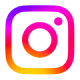
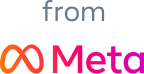

JSONDecodeError: [Errno Expecting value] <!DOCTYPE html>
<html lang="en" class="no-js not-logged-in client-root">
    <head>
        <meta charset="utf-8">
        <meta http-equiv="X-UA-Compatible" content="IE=edge">

        <title>
Login • Instagram
</title>

        
        <meta name="robots" content="noimageindex, noarchive">
        <meta name="apple-mobile-web-app-status-bar-style" content="default">
        <meta name="mobile-web-app-capable" content="yes">
        <meta name="theme-color" content="#ffffff">
        
        <meta id="viewport" name="viewport" content="width=device-width, initial-scale=1, minimum-scale=1, maximum-scale=1, viewport-fit=cover">
        <link rel="manifest" href="/data/manifest.json">

        <link rel="preload" href="/static/bundles/metro/ConsumerUICommons.css/35d6cea47dcf.css" as="style" type="text/css" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/metro/Consumer.css/f4fa2d4df5c9.css" as="style" type="text/css" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/metro/FBSignupPage.css/55ba8f05e763.css" as="style" type="text/css" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/metro/LoginAndSignupPage.css/3ce984c47339.css" as="style" type="text/css" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/metro/Vendor.js/1ab08297cf9d.js" as="script" type="text/javascript" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/metro/en_US.js/b1ec75c969dd.js" as="script" type="text/javascript" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/metro/ConsumerLibCommons.js/9237aba304ce.js" as="script" type="text/javascript" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/metro/ConsumerUICommons.js/4addcf15d985.js" as="script" type="text/javascript" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/metro/ConsumerAsyncCommons.js/c4ca4238a0b9.js" as="script" type="text/javascript" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/metro/Consumer.js/14e4f13a198d.js" as="script" type="text/javascript" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/metro/FBSignupPage.js/bc51e92c350d.js" as="script" type="text/javascript" crossorigin="anonymous" />
<link rel="preload" href="/static/bundles/metro/LoginAndSignupPage.js/8e6fdb1669c3.js" as="script" type="text/javascript" crossorigin="anonymous" />
        <link rel="prefetch" as="script" href="/static/bundles/metro/FeedPageContainer.js/2bb17d94582e.js" type="text/javascript" crossorigin="anonymous" />
<link rel="prefetch" as="stylesheet" href="/static/bundles/metro/FeedPageContainer.css/bd290e9ad807.css" type="text/css" crossorigin="anonymous" />
        

        <script type="text/javascript">
        (function() {
  var docElement = document.documentElement;
  var classRE = new RegExp('(^|\\s)no-js(\\s|$)');
  var className = docElement.className;
  docElement.className = className.replace(classRE, '$1js$2');
})();
</script>
        <script type="text/javascript">
(function() {
  if ('PerformanceObserver' in window && 'PerformancePaintTiming' in window) {
    window.__bufferedPerformance = [];
    var ob = new PerformanceObserver(function(e) {
      window.__bufferedPerformance.push.apply(window.__bufferedPerformance,e.getEntries());
    });
    ob.observe({entryTypes:['paint']});
  }

  window.__bufferedErrors = [];
  window.onerror = function(message, url, line, column, error) {
    window.__bufferedErrors.push({
      message: message,
      url: url,
      line: line,
      column: column,
      error: error
    });
    return false;
  };
  window.__initialData = {
    pending: true,
    waiting: []
  };
  function asyncFetchSharedData(extra) {
    var sharedDataReq = new XMLHttpRequest();
    sharedDataReq.onreadystatechange = function() {
          if (sharedDataReq.readyState === 4) {
            if(sharedDataReq.status === 200){
              var sharedData = JSON.parse(sharedDataReq.responseText);
              window.__initialDataLoaded(sharedData, extra);
            }
          }
        }
    sharedDataReq.open('GET', '/data/shared_data/', true);
    sharedDataReq.send(null);
  }
  function notifyLoaded(item, data) {
    item.pending = false;
    item.data = data;
    for (var i = 0;i < item.waiting.length; ++i) {
      item.waiting[i].resolve(item.data);
    }
    item.waiting = [];
  }
  function notifyError(item, msg) {
    item.pending = false;
    item.error = new Error(msg);
    for (var i = 0;i < item.waiting.length; ++i) {
      item.waiting[i].reject(item.error);
    }
    item.waiting = [];
  }
  window.__initialDataLoaded = function(initialData, extraData) {
    if (extraData) {
      for (var key in extraData) {
        initialData[key] = extraData[key];
      }
    }
    notifyLoaded(window.__initialData, initialData);
  };
  window.__initialDataError = function(msg) {
    notifyError(window.__initialData, msg);
  };
  window.__additionalData = {};
  window.__pendingAdditionalData = function(paths) {
    for (var i = 0;i < paths.length; ++i) {
      window.__additionalData[paths[i]] = {
        pending: true,
        waiting: []
      };
    }
  };
  window.__additionalDataLoaded = function(path, data) {
    if (path in window.__additionalData) {
      notifyLoaded(window.__additionalData[path], data);
    } else {
      console.error('Unexpected additional data loaded "' + path + '"');
    }
  };
  window.__additionalDataError = function(path, msg) {
    if (path in window.__additionalData) {
      notifyError(window.__additionalData[path], msg);
    } else {
      console.error('Unexpected additional data encountered an error "' + path + '": ' + msg);
    }
  };
  
})();
</script><script type="text/javascript">

/*
 Copyright 2018 Google Inc. All Rights Reserved.
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
*/

(function(){function g(a,c){b||(b=a,f=c,h.forEach(function(a){removeEventListener(a,l,e)}),m())}function m(){b&&f&&0<d.length&&(d.forEach(function(a){a(b,f)}),d=[])}function n(a,c){function k(){g(a,c);d()}function b(){d()}function d(){removeEventListener("pointerup",k,e);removeEventListener("pointercancel",b,e)}addEventListener("pointerup",k,e);addEventListener("pointercancel",b,e)}function l(a){if(a.cancelable){var c=performance.now(),b=a.timeStamp;b>c&&(c=+new Date);c-=b;"pointerdown"==a.type?n(c,
a):g(c,a)}}var e={passive:!0,capture:!0},h=["click","mousedown","keydown","touchstart","pointerdown"],b,f,d=[];h.forEach(function(a){addEventListener(a,l,e)});window.perfMetrics=window.perfMetrics||{};window.perfMetrics.onFirstInputDelay=function(a){d.push(a);m()}})();
</script>

                
                    <link rel="apple-touch-icon-precomposed" sizes="76x76" href="/static/images/ico/apple-touch-icon-76x76-precomposed.png/666282be8229.png">
                    <link rel="apple-touch-icon-precomposed" sizes="120x120" href="/static/images/ico/apple-touch-icon-120x120-precomposed.png/8a5bd3f267b1.png">
                    <link rel="apple-touch-icon-precomposed" sizes="152x152" href="/static/images/ico/apple-touch-icon-152x152-precomposed.png/68193576ffc5.png">
                    <link rel="apple-touch-icon-precomposed" sizes="167x167" href="/static/images/ico/apple-touch-icon-167x167-precomposed.png/4985e31c9100.png">
                    <link rel="apple-touch-icon-precomposed" sizes="180x180" href="/static/images/ico/apple-touch-icon-180x180-precomposed.png/c06fdb2357bd.png">
                
                
                    
                        <link rel="icon" sizes="192x192" href="/static/images/ico/favicon-192.png/68d99ba29cc8.png">
                    
                
            
            
                    
                        <link rel="shortcut icon" type="image/x-icon" href="/static/images/ico/favicon.ico/36b3ee2d91ed.ico">
                    
                
            
            
            

                    <meta content="Welcome back to Instagram. Sign in to check out what your friends, family &amp; interests have been capturing &amp; sharing around the world." name="description" />
                    <link rel="canonical" href="https://www.instagram.com/accounts/login/" />
                
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false" hreflang="x-default" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=en" hreflang="en" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=fr" hreflang="fr" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=it" hreflang="it" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=de" hreflang="de" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=es" hreflang="es" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=zh-cn" hreflang="zh-cn" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=zh-tw" hreflang="zh-tw" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=ja" hreflang="ja" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=ko" hreflang="ko" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=pt" hreflang="pt" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=pt-br" hreflang="pt-br" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=af" hreflang="af" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=cs" hreflang="cs" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=da" hreflang="da" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=el" hreflang="el" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=fi" hreflang="fi" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=hr" hreflang="hr" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=hu" hreflang="hu" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=id" hreflang="id" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=ms" hreflang="ms" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=nb" hreflang="nb" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=nl" hreflang="nl" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=pl" hreflang="pl" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=ru" hreflang="ru" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=sk" hreflang="sk" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=sv" hreflang="sv" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=th" hreflang="th" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=tl" hreflang="tl" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=tr" hreflang="tr" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=hi" hreflang="hi" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=bn" hreflang="bn" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=gu" hreflang="gu" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=kn" hreflang="kn" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=ml" hreflang="ml" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=mr" hreflang="mr" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=pa" hreflang="pa" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=ta" hreflang="ta" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=te" hreflang="te" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=ne" hreflang="ne" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=si" hreflang="si" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=ur" hreflang="ur" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=vi" hreflang="vi" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=bg" hreflang="bg" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=fr-ca" hreflang="fr-ca" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=ro" hreflang="ro" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=sr" hreflang="sr" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=uk" hreflang="uk" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=zh-hk" hreflang="zh-hk" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=es-la" hreflang="es-do" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=es-la" hreflang="es-uy" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=es-la" hreflang="es-ve" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=es-la" hreflang="es-cu" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=es-la" hreflang="es-ar" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=es-la" hreflang="es-pa" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=es-la" hreflang="es-py" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=es-la" hreflang="es-gt" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=es-la" hreflang="es-ni" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=es-la" hreflang="es-cl" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=es-la" hreflang="es-cr" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=es-la" hreflang="es-mx" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=es-la" hreflang="es-ec" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=es-la" hreflang="es-pr" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=es-la" hreflang="es-sv" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=es-la" hreflang="es-co" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=es-la" hreflang="es-hn" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=es-la" hreflang="es-pe" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=es-la" hreflang="es-bo" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=en-gb" hreflang="en-gb" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=sw-ke" hreflang="sw-ke" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=ha-ng" hreflang="ha-ng" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=am-et" hreflang="am-et" />
<link rel="alternate" href="https://www.instagram.com/accounts/login/?next=/api/v1/media/2869342280349241241/comments/?can_support_threading=true%26permalink_enabled=false&amp;hl=om-et" hreflang="om-et" />

</head>
    <body class="loading" style="">
        
<div id="react-root">
  
  
  
  <img width="80px" height="80px" style="position:absolute;top:50%;left:50%;margin:-40px 0 0 -40px"
    src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAFAAAABQCAYAAACOEfKtAAAACXBIWXMAAAsTAAALEwEAmpwYAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAABPUSURBVHgB7VwNlB1Flf6q3/+8NzNAAhHkZ0mAYAxwEDiaBGJwQYkIbjDJIbhmhdUIrKDRheiuYFbOYbO7uLBx9yjmoBI8QZKAyhIQVyAhsORIQEGCURQiCEFASDIz77+7/Kqq+3X3e90z770ZNOHMzbm59fqnuvrrW/feulU1wDiN0ziN0ziNU5ckMMa0HDJZAw6uAFNZ+eHkCQ6wfxLo5em0BWTJSQE7I1BPJuEkBBwrAdvicSQhBa+FBVvLNDmhpZA8h5SW6piwE5AyA6smIO00ZDWJRDWBepX1lFNwdqdgkfG8g/KLArltU3DAbowxjRrAOQTs+AyOTAl8xJKYJSVmCwd9FlETjnmA4gS8smTZIdsEyUiCSWDUcXPOACX1PQQASc1Cy1SjLPT5pMsJzVLf65Utl9UxfiQC7+wEnB9ZqP44j/rmPI59CaOkUQH4uR55oiXwD3znDwmJSQQQls0TShI8/dt9iOWyAU69lJJ1SkcDmdIva7sAGQA9cDwAPUAtlqmRuh4PxIRbv9FeDzwPSEdL0fho0mb5KX6su21UruvH9NfRJXUF4BX9coqw8Z9s01kELq3BcjWuUQ6AlmyUHVfDbA1kUrM5lnJfMqXPma6bdLUy1dA2o3kGGKE5qQESAbDQKIsGkI6Wwv1YBkhbn2d5j0DthjSc6wVO3IUOqWMAl/XJuXzuDWzHMQlptIxgNqR3zOuyQc1IaA3zwVMyrV9KSekCCg2qZ/uM5kkXOL/rWq4MPseTaAJQaNB8AD0QDXuAOt+nTf6swMnPowNqG8AlkKkJ/VjK560gSEK4XdSTCQVeoNsGu1bCBSWpu6zRupRbTunjCjDb1TbZkK6zcOsQobJwtc5ywTQaLxt21nKlB54CDa4Uumw+HBpcV8f+CNTmCsx6tE1YdBvbookFXEhwrmbDhG6sDHAAvKQPXpHXvUxNepH3DBIkekaU+ZJ7CFyJx8vsfjYBdNLawCsAHak0jywtDazldlEFjuV6Zg2FluoyXiFS+pFOjkAV+Mw+nsjwvh4C1cvfR/LcgTwnhAuiAhQuiD4rciaQvyPx/38rMPNn7eDSlgb+y35ynnRwu6U0T/q2rqF1ju66Fb7Fo6zwB3y1LQxltl4OUcFeQBK/259adhrB+WvyXGrbUZTCANeshVrSW9vvEThzxO48IoBfmSDfgSrWE5RpCryE+YhIunYvUdfyCWrctXuAe5ZBDGAvJolfTSY4BNG+ltzng1hvll9nX7hc4PT6cPWNCOCKPnkPATpLPUd3Jdfbau2zUSeoy4aAG6+AGMI+RBJPHwyUvkawPhKjhQrZzwh88L+Hq2dYAFcW5LQq8AuCZGm754HnaA2ssHzNp6h5PCqxD5LE1ol0Gmuphae3gqiBfBo4d7oY5v2suBNrITnEwlUZOisysrbhHOvNklMOrtqXwJN0Is3HGLK8BvScQ7Du8cGruaxBnAbcvmC4emMBfD2NqWkbs9NSg6VZ2b2U1PxLVn/DvgCexFOLaKJvAp64R+LxlRKbJwfPC5xA0yO+RLBsv/t6nlkDel4U+B7FAsgY4Axq2iHZmtE4LZUGOqjQYSz7FEQNezFJPNNH4G4lAGsIxEWUHyBfRjXYxjDl74PXCsx+nOdWhx1J1ZNnAd89Pu45sQCmqzgrzfszbtfNUNcy0GPRrYwJNmGvpz3zCcb8sGPQmpXl72to/3rC19sE0CmHr9XBdT/BfW/cUyIBpMpaeWZVyOgh53isx2U+/a4PQuzBXk/2J/niyYA9Q8C+0QPv/nD4+oMfBipbjOYF71FceXfcUyIBvJ+1Eai8Ai7rcsZlHnsA+wTZE3xNCkpPI2sHBa+mQyFqzuYIT6zk1LinRA7lCNKxntV0YGId5S2IduUFoK0hTicksZaDmL6TGCDNZoPfxWYdwae+3TRFBU9Qhn4Hy89Q8vvKJ2i3fj18rfVtvO5ohIZtHji6/FjrPeXHzPWeN26AP1ViOZPAy1uC6kgA83r8aKpqcrMvLYSoYoxImQrgxwtZJMsz2diC/wKK9HgXbnJsihmKiSXk5yUe/D8CvmqYgb9yHmfznpRfp2fX5O+YIN8Scc9zPnjBuFC1K01biD823xDZhft07kADqe1ezuU85O8xBsSvycHNjy4E7uUXrytPOY9c8G1PswyyzTbbf+XauJ9KbFojsfGU5mcInLaO5/+O97xs7JrH9kbKedFDtOLLvg2sIXyfdQgiKK4L7xfOU0hK3RVGPVyT+AltU/VKvtjn+CsZyIS40vum3mSAjJGN0GwRebbEfQxR3veD4KhB4P23Smxgt3doGpy3ETyWre8JzI8Zr6dLBBG+7QvGhE4+6o4YAO1ekzMwwKn/XVnGKEji3sM4/rybjZketkseiQB7kwGOWw5KEbheE+2lvJ0azVTUnZ8WOLfo13j2VoqtaIteIICFsgl1PPA8W6g7YQtFduEM6ukcb8xQdTNamjKPldAlSaw/lj6I487q9HD3CHZPr8sG7U+UF438TTRtmgXraokH2s5zBsk4CXsw4KkD9ZfTUfdEPiiFSkY0dM/TP/0VupoWpFbQlJapIcVpYQD8phuyaCLshyh/Sn6SToIvo/OzDDkcxmIJempwVCDS/n2y8RRDzjJgl+pul6ErUkoS9aHqmairIwG0VLIYaKTCDYy2ArJjDTQhyqDKvU0zL6m9oNsw76V1SpYjAdxER7glKlwgfVtiDbMnmTksL+U9M33ggyDquj/J53KOY+H96Jjq9WjNdyKxilH1UsZvTHDixe7CBu7mcMq62HSHZuAUWSoeWypw6eaRahK4gNkTrFcsse6LlJ/h0Ul+WxsxH9vvfFPiW6cLXPQCOqJqzQ97QomFRNTVMWNhTl1ob9TMJRsdkNQqUvky42C+kMJeKbCSKtOvQ4WnWD6nHfBaaf4K/vdR0+Wi7KbDuFFpaqfkOIFJpkCd9ciMTAyAakWE8vQe73F5V4fpq+sWE7x36IGE+QDwASzRzpU/LLB0J7ogFa4ILLjPOI76QPSYt3axxE2HdFZzzfGdRygO7UQDB9VEGsIgKh5sG0CJJfwIQwsMcB5oSmrvy3pq/yjwxWcxakqzS9f/IyIlryRDj+JcdES2bNVAJ/bqGAAHqK5qkv4N8utB2YEG7kePOTjLfIghl71uXPqGwJe76LatREfBN5z073zR34ZHEY0w5HyJlZn2a6zLVpPgcSvFAKjAa+7CA+7xdmnwZAK1nwHNY6WFVVZSX4MxJE78sOLq+ujJoepxNEmHt19bc0Y6OI5upRgvvEv4NweDW6cDDSzNNLIR47nlJEcFybZn/tun+m1s76VsY294wtymlxb8mHimvXqaJ9wbkUOkE4kBcEDEz5e2S8WjfNCCS43srQJffxMm3CtMb1nb2e5Twlqj32Ny+/UEtQ4Ih0etFNOFVZfd3cTq2CDap9KkVs+rZPExvAkkcAWNbPU3TV4Yfga6XfJMQDCPGE8xGqgMftCQ1tuqLEzlHl/zEgFOvokrF+puEiHoPXX327/9Orx3DGZD4y1XDIC74auxB14jK9EmlWquzYMPnu7SXQ3026OqG6s12zGngxnEIIAjU8zLqO4W5co70sCia/NggFRrS7UGTsSbRvb+4a7nKYH8Q/t1BLVu5LVXMQDuCTSiObnYJvWXn4NMTNH3O24eTybU/PW7+H1uxhiTxFLmBCvu5E/Qe2oAOxgPex/co2COspViACzL6JzbsAuVwlSoMrDFGY1VzraqK6HkaVLO6hWvPTzGttBhtsc50i0jAKJKDvwKHZE7hRYCL7pLx3jhojSOhF5XkC1ymu9bGBxZpz3KDz6CwpBEnl5YcW9ZgarkCeivnYcxp9onyBk3WIeftK09y6/2y/brCQIVDMEykQjGeWHZ6L5qeULKXduRZEai3UjGGtqEtLUTon4IpJoYc7XYUVtFHE4IjV03lrjwMDMxZX752qfLTwCTO9zOEDW1EE3RGigGHKTpiXtpC/s4Bu4n5zmjl9vVtgaK7bt28Pp1yPHeHOvqoUbnyHn6lmxlljzp+EtkO1Z6BJK4QDmOVdS8lNE+TwMb4+IbmaDtwHgLy9dCD0QvkmilaACzux0UmEDIk3NUuUzJLJDpcTp74axzG7J8keyAqpP1FM3EV1Zx9SuYMf1sjJ44u1c9M2L6U0k6j50PoiNSQzZv1BTaZxDZhaMB3G/ARi+/ZL5uFsd4k8OpzjRGbMIjnI26AzlpQOtRH4Ra3cOPki1ORK54m3zfUefIOXM6jg0lzuiXOG8lNe5LZMsf7TQ0kOpX+4LAxg48n2611Tr81I4wchwbo4HUfTVto5JA6QD36GCuM0riWtazy9SlVmoqjd5ttDJTYo32Lci8tELOODTXbpVy0vuPRF92NdK1S8LdNZjOqv2EGvBDdE5NADZGUB04kRxb4u2rasS/WmbRIYkNeEzOxxLe+z2z74XtkHxRhyzV1EuhH3b285iQXiTnHn0TkuJ/MVB9RmzcEcqdyVNOeRuqmZNRTX6UseSHkK4UdGuGhFE+OxRq0GDnPy5wSxcLAdSuiSB43m69bORoJhrAFD9hEDh/R18B3dB6/vsYvsPSRaH5H8nu5tTdOaDCIbDTV7F8KQqp38i503ZAMn6qJjmXlexHzToOwj4CCZlGrW56WkrofZ+6dygg9byVUJnfSwS+/wq6I3fKNDj8VC8vIrtwNIBZGhIPtFSonq4A5KtJmcPFjC5e448rQyDaKrQpmrWNakGAk5sAO0NOv1vPJFpJMyGWTBotqyUMaIprLoh67R1lSZQYgV0g6o/ci65JFIJbI30QMpEzknEaWG5ob3hPacdduNGsb6Iml2K5XuBADYHZhRoYNKjJMDWnrbSSSlDPmYVViYwBsM4G1PlSCY9dINUuY7WHQFjPQ4h/Ersf7Ro8M49T7GkFUHEmMocZDWCakyBe6JNG0Aa2beijSFyvk4OXy8/SM1v4Gls8Pbx8T8XvSiNLZrZSBeBqcKGArLEhdsrVQMWWmShLiCqq4i6kUpeIZ5/sttu69AbByybRsn1Rd+FIDYz2wklmE/zdzb5Md2kDm0jcgI2sax673jXkYmMZrLck1l0Ki0zNjUOV16ZPyb7hxpRDhjPFZ5EuX4aJqcXiydGCpyhX8OM/f4+pK9+IuiOuC+8Mgedr4hSMEYkVYPYYV8vlWMlu/Tds8yJq41Rq4ttD+QvlGNQei1pFdW8byeJz1MqHIDK3It+7Wazb0fWCp1aqHmq+XosXVkvsX466IzIwlvNwKu/d3KKBSb3OY5L4n9aVmqMl2scc+nEEBxGqW0+mPJTyAIJrU75KIF8kP00j8CSOwh/E8o6Sk+21AYsWE6ibjbaozqa6g15e/xqw9KCoHUvRGljFNr6M2W+aRhDEBP+dylI3Aeqw5NrH7S7/hUjMCQ/fFOsuuC1uu1ekDWTwq5zIzlAMmGrwTLwFSeJjB/H/E8OZmEY25hdx91mxNaZxn9a+FBCSGZwv/1mtCH2r0eB7CeBx/u+GJqpU+v1xd8UDaOF+948VoMkjH4Y+fBxvOXI+beYcFAVdg2Rm3fp53F3xAPZiA8Ha3kgkeF1Y/b2RNK6UK8fOI/+lSeIDKsE7O7zOUJHuwvcJXPZc3L2xAIqvctiVwndb7KCRfeR/lTeiB/s4Scx6DyPyL4Sz2EESq4a73xruJEOJbxCwV5qciBdUL6A93CBX4yDsoyQPOHEGY8y7CN7k1qkAfcUPBZY+PlwdwwLI0OJ12sFvhebGwxmaOQRxtbwDJ2AfI3n0sRcgb69BXk4wqb7mtTDyVR67fqR6Rswwc6SQZUx5CzVuvqt5wcDaG+3UKFdRrsMAtoqFHS2i+bORnMHAXOTPRaWwGOX86Xr1yRCD5SGOGwe8tLsKoHV5icB/rRqpzrZS9PKrOIZ1P0yQJkaMToKpsz3kn7H8KOUmHtnBJr/C30U1hiCwnSzv6pr40dP4NfLEIc9PeTifOoVh+gwOEE5FKfFOVPsslPuY/Sdg5bwBUeUR6mZDG0cgdzOsOVdg3YjtbXuOg/NeJxGImwncO0MABrt1MAsUjkXVlpMqy2apqvqrY4672Ea421CEvsZfGGX2l/lz+zWIxkIJk71XtQgm3ixdrhI0lcUsUYWqhK6ktrvAZKvV9SWYjL9eZUygSpzMq+TNGqiyq4EDKoWW51Au+3mB1W0NVzuaJKLDOJng3MmmHRzSvuCfTwuOgoDwBL/3xOC2N6/cvCiqeXmLD6SR3kL/ckBWA7LoylKT1HNPbHDlABfAvNHEIQI4mN2AYmqhwF2NrWIjkYUOSCzGVnbl4wjSt8nVlpVrQfAak1loBToovWxPClF/cKv1/uZ7m01KAuGpjGRUvfwCSSKarKrFAur3ANL1T+CgyvxOwNOYoAuSd7KLWAxjLFzFhk6J1L4gB7UvVBHCmgiENTCoiUENDK6h9GYxPc0rwV/LWQn8LrnXF11Zpt2r9fN4YQMqvdeJ7T/fiC6oKwA9kmsJ2YE4n8UF/MIzCdaBISCbV0bEPU1GyGbwPPYA9PYpRtk4BVhzF/Z+V/gZKvg9p5LXolq4Qzy8ZwtGQaMC0CP5gE50HU9WNnI2f01jzccQvHyL/fNkMOCPAtCzic0a6C0S86aAozTQk2ZXhcNrXqV8mnI75YNs30PiDoI4BjQmAEaRVH8GUGUVBdT65ALBzPHlzVS95f4pQfWHAOsBHRV6S55PzWWvCyt/XdK/pU641imH+H+NXCRMZfIQr6hjN8/uxL9hUIg2l5yO0ziN0ziN0zj9uehPMu5fs5PaNccAAAAASUVORK5CYII=" />
<span style="position:absolute;bottom:0;left:50%;margin:-36px 0 32px -36px;">
    <img width="72px" height="37px"
        src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAABKCAYAAABU493xAAAACXBIWXMAABYlAAAWJQFJUiTwAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAABYtSURBVHgB7V0LjFzldT7nv7P2Yhx7Vn2IVgm+iwilqhTGUtWiiMazUaPSB/E6lSoSSHeWBHCi0F2rAgwK7GzaFGNa7Zq+DJTubEITK2nqdZM2VJXqcR/IUqt6XaktaWl8LUJDEpDHUcBr78x/cs7/uPfO7jzBWnvl+9mzcx//6/7/ued85/z/3IuwjnHvg/snAHEUgIqyT4S1BunxZ/c/uAAZ1gQ5WKe496EnZlhiJlls4mOIlFeIeciwZlCwDrF772NFKzwM0gcQGsNP7XsA5fvqpTcz7bOGWJcaiCAYdZvVpx7fO+mPH9z3UAQZ1hTrUgOxsbpJ/hLQMchwSbFOBSjD5YJ1Y8ImJ8v5pcGNhiB72owEW5kPhel0aTPm8wwuna/NzpZrcuzjzJ8QgpAJd+3px1p7a5LvjcFN3kxyfY1o89L5RV9GK/h2pOu6+/7PFiAYKJi2cn2bzp2rtirDt8nX9Wf7HqrCOgHCOsHde/eXWF3OdUvXgMaIH4B79j5eRsAp3qwywR4nyM15l18gxDudV4RgZZo0CHF207k3plsJwb1795/ir1ADjAfQqLYsB6HGZneaBXfWXNPD+wtK40yL+iJC2tNOwC8nrBsThppk0CL3MSCC9LGmcyvBxPuoDNSKPDFEeDTlTsSDSbjIfyuEsODTInt+5wY3nRAN1a4eFthtvi5fBh+tukbkkXBGNI7Uhw206ez5JB0LIpczt1K7Xo5YNybsaRscNHfkvXufsB2PdOCpfQ+We8heNH/Z5d90fqm8UoOIQJzjQZc4EieKEPT4wcebzQgPZklTMMOxgpCF6DAfGmlVEZcxyZJd4zJG0mVY7SaCBWEAwRSJkKCWdLsO7mtOx/WcYNWY58CoeJiTcBnjiiHRYjrE5W9lfhzfCWXbDHwLDsLHKgobe9xuUbRIm4ryWuGulWUINyNNB3x+Em3Uoi5Jp9ClU2oMLnNcIQJE0dMdNJUinHCblU6xJBEib2YCwtE2ySrP/N4Diy3rUTrmNKzJFtrVpRp1m46FrJO5vBxwhQgQRp1Pk/GUWEMcga6gk+avUjtanWUS3TY2lRYYJvvz7dLpQMVacvnqzVvhMsYVHwdKE1WtdK1behaySL45hJDNuUEmQE3ARncBytCMK16AmniIC/p1AioM3WYEGTIBsrDEWBHt7CGxTUP6JGTIBEiAULeEFnG0rXsOwpeekKh2aJPSLGTIBEhg3HMC43pzkG9Opk3S58WVvoeFh2NJZXOAA5LZ0hGLdbsi8WIDsbHLR4plzu2eB5/gqDMtsnrKv6mRpxbITuRy/ObpfXsv6+jwWiLTQA6iUXjCdYS1zLzMl9lpDZ4CISjIthyzE5wP7IIMMdbNbPxaQ2bKA93wsZ4oM1kZMmTIkCFDhgwZMmTIkCFDhgwZMmTIkCFDhgwZMmTIkCFDhgwZMmTIkCFDhgwZMmTIkCFDhgwZLh56/lkP3XlNERTeBHV5lYAC/j4JF4IqLkR9P9GCioUi6OAmrj4PDTjLn0U8/m9VyLDu0FWA6K4fnwKNk/zJAyEBKeRtMB9S8l2BZZhmQYq6lvWBwgRoKHOerS3KiYCCMh7/l3l4G6BwlIVSzUBDylb2I88F1nQEX//S237q6TmYDAeUkt/Iy8Ok5GlQpvgNsKGM8NnTcIWhrQBRKR9CLneYB7Ygv+e1gxEPtvSeFSazb7b34Fe+eaBlWcUwDwPvOMyaq7hCaNw3uIE2+1U43xjHxeMRvAWwAIVQV6eayiZTdgTLS9uxtvC2ngFUh8k5QiyZruMbiuSpiqyaCdTIVbCvCmuI/1dPz6JWW82THUEuVc+/C+6uwhqi5U+baTcLzwYlT0ItmNuX5B6TP+bbbiOi3TGP/ZbtWfrQdVOryrr1xhAGrz7BNRU5my3MiG26PFeCFeciDOT+gQo3h/CWQa4sMg8jdHWEoDa9rd+01+FTo4BUSr8hSJ7ra6rgs2sNpWmntIfv3hK3oYSgQlhjrBIgIzwEIjxhPNhoeiweCek0N0jNGoxwikavj4XIaB4lggjbUunP8vY03y8f4ht3BEjLoEYpQZXnxw3DwIajVCi+tcfIeQFdKUQIE5QffcuPpkMMZuId8jeAeX40waWCvUyCS9SE1U/nQDrKghDabXSigzL0Vd5ifqIjwIE8oN7JjS5ZAYsHSISoTB+8HvCvX5qGzRvnmHuE5ry9vkUYwF34/GKUqlHKPUC33FzmNFN2YKReHUJAMmDj0DechnRF2c6VxumtrIXkiazT0CfqwX0l0Nwm4YFO51D87W6xS4G46/GStKBJA9Ent0xxO8KkLUYb8Leexsp3RvDzr1bwuVer+NzLC/iFV3hgl4dXPQHVCtQU3XYDcx7/KFxTDnMQNbJCeJJs/3xcBKhstBR57YElKtxShP6ByQV48wtec5Ypf3sIfUJpFm5rr6zUINi7K6WJ1h4UW35WQRhcAjUUCxDtHmSO4B6glPAR6Zwy/vlr5VaZ8dCrrI3YDCn3vEAz+Jrc1mhiAukUj0ARq4sdCSwePy6aoRoPvwivCuagX8QmLO7Ps/E1mU9/ZRJ8csqZ9NRBLp+sgF7KR5ygIfLaSHXDmoI1RWLCNgZT0HAqXzvNg3ASnznTUd3joSii28MRTnuCOzUvT6EET5m8atf0GXz+xdPQE2ic2/BNZ3ZkgLZR4RdKuPhPFegZ1u5CooHmeXfCeHmm0VSk/J1FrD1X7V7SbtbIUDKCwoOl+Q9vVhBVyas1K0jdcQbKeQWqxDl2cGkFLiMk0yZF9vnS8m4NfWAIWj9K5nvwh1P2nldC2UUD5kXziPniIUMFtPMVeDbkYeXyxA1V8o8aEJy8Fj7SNoTxv/DlYk7lxrTGIucJ5UrJ3HTBIt8n8zfAr1Yk3X/D16XsMWXqt+Xbe3WStY8OTll33Xysiw4wjAdrEfQA+vWQNQ7+VRzfiV1/OIJ/841R6AP08++d5fy/ZfrGhg+qeOLYSE95xY0n1ng+LGCvZ0QIPh/b4dx77nsu88xfdC2T1O45IlWynoQZ7EiTZiHPHU0dk3uP3fjfr7Yr5zw8urOOapbTi9Dwf4UQeyjuI+1FabcqD8Fvr7pxX4M/0mTIjlxDwEJCZhAJXcjCDLzssECZb0XC01jmK++EO8dXlncKvhgCDMxxnqIpx14LGU4n+7Y9LJx0mssbzzEpZS1XNfVxOqnem7DiCg4mZyq9Co/J8JVoAcw7Higxf5YP7aRfeXfXx+c2IZA311gV5vq4SNtHdvSc3/OSmEsxGuL5Edr+NS1mLfTRjmUa7UPiHlu4bivnRBeljnXjQG/Ao1N1hQvyghXy3qhtIsUOnHcWTaFUfh3+YG51e4y9ctVRTJzttyvX+ceIaSaiV7XpFHyJNWDu38m/iMaHVGK97dtlRDBkXXOUaxyN9a2RLkLl8o75bI6zsFkVj6tPyCu4MdWY+KP64hz4wguL1utLlYHUVVskBcSfmBPga39ZtY/z9WNvbGulYzmBEGc7zO5IFeFJ2y9OSLGL9JxTn55iNcraT8f6yuWo8f5JlDuaaNHVY9LIPx6YMRaimZXX5RtPdloArZOp7ZcPs8VXSC2bJ5qH6znMp4ZimUWvQYyKjrisyMkneSrLQjFp2uAuwowsTULeBPmag28Ra58q9AH6jdATTVp50VxegX75p/sM4umFlFaU1u7oIzMm7Ui1J8Dx5BrNdYa05c5yqwIo9/EipxlLBNEwg1KqBulyshykNc7A3pD1fzkOuhrijWd4Z88WeGToHfDp7Vvg4ZE8PLydT1wn/S6tVcbEGW4z8T14oujLq1N9uA7BcAPUdSyOwygvpoM4qiBCN3keLgyfp6XhC0TDy6CHl6nB3/Fbhlw3oNzQoWWoTuDYTDG3mWQDNnQ97By+AT44/ANaHuLy7xJPm+Je1XHYS7KxWdvA0wupuImVtWPQB+j2a5hD0ZS3DRBHqp0utHGkRzmwWMFqj5OvGo8l3phR+UUJLOJitXt+p4aNJk2NL756KKIfvb3Mm2XXcrHxHFwszWKt0lyuQolh2ZKk+ZpNOvzxaTlVTxUqF6lNvzVWNWMQzJyZbYTQOcCzvDmyGR5d9ZByIc5nqLwdYNNRQl1A5jgiRAHkODZmYmXwE7AnSuf5DvyJ9cKQLC8CfXYYPhFBB7wMny8y4S56g+P6ivPgyDDsbMq7HXZJn1ROweGFZbhKtOGY5VS+98gwpwIkXU7O++rhrTUp4IajhhYkpuOIqEFbXtzXQzC4aabnIv/1BVHrNauFvBmzb2vuDqNzXWt4O5eaZqgvHbDlxmnzbF4mmnIP3lUCe4fGZnCJY2H+fMyBLKFFWBmRB5l03Rt7b6ZMw5b1dCvh8RgCeZdZY48VCm1uaL7bC2dgplP03AUxCaEHEAQToiosSSKjRQEusPDsitrl4XO1ATi3h9ty2qni2DCKH3aTU+tJR9SXF6FH0Ed+0pquNPfReg/362RM6WJuBSWeGytC74jiLWvlh3vKhYCteJA5JZOpQvY90bZpJmkwHVyU96zGbFXCEOWr4GDkz9Yt/7A7ZPgK5VZHgoue2DrVXtsMv9P16fasidjL4YFykQj+n2/ERLclYnXYgB6AHEIgclTLcK75Yfhw1C2bCBE36QDYvE5q5dqRtvmGuO8aHlzqWqDJIKYLsLyCqJmlHXj4JdFC1XggY4Yf9KyFwD7o2+U3883bumda8q1rT27rS7Nc5umEbdJWGNg4ZTY33SXfTvuY8xFAe4fCGWpcqQEUe59I1lWxalgfg15BdAxiomqMUwfNazmJqJJAfMQO+BbMFbhsR5zJ9Sr1bG24/BPkORNa4i2BxOGmO1XZ92H1hAE1Y4KO5h605Jtvz0p8HtUkuFcIQOzlMaH+pZ+ZxL/7zx7fNeH9W5RRCXvMk/ijsNoNES1EP/JhJpbsiVh/V8a5RFePV+38nnNW7fhPIzwTpfPnbKDNxmEcx6uvajUH+XyfGllW73sTHzmlXaxHk/fJTHAA7MSI3SdZaAf+0s29Hra6Skt+kWKFYDyo9ghg41aN5C08WS+tEUGPEGHRkFBluT9k5Lf6S3YTmT2RXPrNa8b47844r2m/blpYhof/5yR382zMSSyZljNTVLwx7FqJaAlTPPU3X5DWeKq1k4Svf3GBy62m5IvrYLce3ZSF5XQRNp6ptMqfePZWledWnw/joo1c0BBnCSWmwnshhxHllQoSX9mGts4QraCEJqLvAj5EdqUPtG4EUDyl2x3LwBQgIcBo40cXIugRdVml5zkpxSbMlRNrId21ICqx6UIzb4apwYrwyy9XViVW9Wk+d7aJU7Bdh43yXvUu0JrSbnQfSBFb6461TEU0neJumMptJYR0GTrV0KFNLCA1KzeONJgslhUjQYp/NZs+dMEbLxX2nsOwbTNsW03GbibMNcLW4q55I2zp45Wa9bhOdA3PJb6coMdBUg2eN1PbXDscBeA5rFbtXYhqdNuNYi7mkjpMFxXpA++ZwL//jwPt6wFPZcjr8t7gAxUydqaRrbVQ7VCVhu6ocnOKjmxgbPVQHcPlZ+db5aubmW9nOhxJXt00CcSxuSbfBv2PrP7npC1a6C4FYG9WngZpWhThKUGdiw7M9GQgIaVWVwmxs2k2G11MmIILPLe1wU0y2yAQx4yGeOc09AryXqUNHeTMMgtRtwJj+zHsmP9jPybrmkuxIJgupAoeeqXaLg9+9cUK/dpPjckkZrw+x9rvMhULR3iWPmqZUWHBuBZ+iQfQWeiGQf4sp4UtfYO0uqAGCz7PA6KTg1hQG+PtsuR4WLWE48DPY62uAE1sRcpTNmRJ6trN8LvzcBFhlSf5GwW6+WHL7BDkwHIXp4WYwwRFAOjZ67YVo/fkZQLXeBmUalVI9w20ZP1mnTTQbML1zGERwDJ0Q46jwEC1RHWDNWU5am/KOAYSD40RVH0KekKKMyF0vCtZC0X8dxd3ipizz7BWKHPvjONSJYIegHb5yiqwNjgCaXaCNHwOHtkBFxPWvFGycDToaI6GYVz6/yRCHEUUUerlLY22Op6JT0wmuClX5PmhdBDQBDZy5ZWZjfAMqKOwyj1mL+UL3+6qAnHhxQiSCHBM5fizg37xPatce3rvzSURZru+yCVXPbrCXmhi6tN5vTLWnlvA2ufK+H3+/OBz0/hGpdIpfd1oHzsI0nOqRcjAzsy7GyYOJurKGZjsaUnt9+HxsTOQvFG6ZbuJajoxz7LRw6S1cdv9tKt4/8VTcKjrNNNL8PUxWXudniGy/qNy7zmPyaTRLaN039VzdN/mHfQJ/uzeMgUb8YQZ0Kb10LoiqxShR+DXvnGAr7oKfjbaE2SNE/T+wpz8Xoxu+dkive/npphnzZh6FHozH7nodA/ws39Ni8ouLsh5rQTtI07E2poSTs7f2zbA5qMyR9auWFkzdFbtm2E2U2HTOtepCVq0iSO0RhjYK/42/GnYKU8d6mJBzqS8Mck/00mI/g++OkHQqJALqSThM+3E5v7cUSG1TWtokp/r2DU5st9w+3atTwQqKOKz3bVPGuZXGrLQXmOY+kkPxWt/hEA2zM1hFtrFa5MQxvH4C5Wu5d94q/1ZD2HS5ga9H7/1tSpcJCzDp4oByg8PmtbyjAzAbDWdTrTNVTh4mMzck6LY7ps4EM0zjzqCMq0Cxjxs4+YWtFYlTrvV3qJmTc7sENy/p1U7vgtPluxKB1smkVmYxpOiWNWgqrJCkXsgz8dq74SPVXw+ng9jgQhmyJFYG82RtvGYcl5mUscCs6YoEI1W4vN5u/Atbr/JyrEst5wjqI87dZsKbtAK/pCiijLVT2qkX+ExHfW8MWXMOaAGiVtvo37mr/baMDUdwdqnB+FJKvENBusHX+QXe+aMSXQaqAOGYLbGKbhvmSdi7KH7GMwY3xaHuXlHeUB4ApUqnHaSE2yNp9qsfhttNxc2AI0FkDXpKT+QN0NtfuIDcyxSc9ypMwhqRzrfu+Cjsm5r3nQtImGspk08qiSz9XygwocnJCAKPuwgMwsmGZnohBE5U+k+vkAlc1d+/ciKfkkW2XNbdARBYxdWXo3gLQL/9r8W7fqeVNQ7iatQIqxmn4W0j7VAtp3Ov3WmrH7x7Rja1Td2oKF9gOEq2Bfx1winX/DMzP1tzpaaXvOpNOgnAd7cPgR7WgZ35fgABKOc0p23E7DWwfXzva2bdi3cMc4VHrDDbW9WTKI5nrS5nxCYsqZzoMqYtNq4f3EAAvcvz0MjGAZZ1B7zDki0jg02LrAmHsFnav25fS1ghWhAFuRX3MwAJFovFqQq/x3B433+ShURmzRorreZ6j4qMF2OSbs7li9CNAiP7bJLYXFRxWTTKl5LRMjdMhyqYO7E4jkyBHsn7Qx9ewzB7pMNCraj+zGC98ogEce2wr0N7phkC38XgQnlQDrGY9tnFqlVmQOMvBtuK/vynFhYEt6qYLtGWqYpgiHDTzSehg3BAs7W3tbPgtuBbi2ETCx4oo8/hgexRlzaUO1bcNYJzkE5XIZ6gW1rwdgAbdYyM3cJFpdhOeomNO0gBJrNVsFyF+Ep6nQddFSH3KJ14dtDlriC8eIwtOFN4UOK8+3qqCx+CPkYlo+IOuv4AAAAAElFTkSuQmCC" />
</span>
  
  <!-- Test assets as png image on msite -->
  
  
</div>

        


        
            <link rel="stylesheet" href="/static/bundles/metro/ConsumerUICommons.css/35d6cea47dcf.css" type="text/css" crossorigin="anonymous" />
<link rel="stylesheet" href="/static/bundles/metro/Consumer.css/f4fa2d4df5c9.css" type="text/css" crossorigin="anonymous" />
<script type="text/javascript">window._sharedData = {"config":{"csrf_token":"jeXxbWieGanLvUmKf2JAlmfbtbeLgMUj","viewer":null,"viewerId":null},"country_code":"PA","language_code":"en","locale":"en_US","entry_data":{"LoginAndSignupPage":[{"captcha":{"enabled":false,"key":""},"gdpr_required":false,"tos_version":"row","username_hint":""}]},"hostname":"www.instagram.com","is_whitelisted_crawl_bot":false,"connection_quality_rating":"GOOD","deployment_stage":"c2","platform":"web","nonce":"kVD4Xq0WLCt3xrC/dazcvA==","mid_pct":85.95242,"zero_data":{},"cache_schema_version":3,"server_checks":{},"knobx":{"070bc16ba2d873c073001690561934e3":true,"17aeb9de94ea257e02570f12cdb2812f":false,"27e1c3d9ed3e05886fb474b960e3baa4":false,"2b7e94fa13b965001509050c40b95062":true,"2fadb61ffaa0dee8af0bbfb859a94d38":true,"2fd8c4813fb3f5cb8832e5cb6075b0a4":true,"33f8d364c4f95494e7b1e0e0bcd42f6b":false,"39649dc8cd38fbb8270684c1d44e5242":false,"3c50bdecc6078abf9e53f13d9246d9e2":true,"417a8e79ba5d5da0284a8efb2178791a":true,"435adbaf42059da0cd46a6d2c4b1a56b":true,"5a00d32f3b18ef1b85a8d6af5be1ad47":true,"5f14c608e32ae0b85932fb93091c4546":false,"624aa9c15ed32e7d96b314f2b37a95b4":true,"62d14d10ac3f0259a2a1736294d52f85":true,"7c987c5c3af0296211322195e731d3f1":false,"87084edfc1b9d02c4cdfa207310404fc":true,"87cabcd3ff134aea43e9d0eb09f3f1d4":true,"905928c49b2e06c084709ec4bda214ee":true,"989a9524772f4eea9e1ec5b9e4ae8230":false,"9f97772ac84b15c6fa35b21d0ea0ea6b":true,"a5320d6e0f6b6e96e2be63a67a216a54":true,"a64bf3b237e8c66b16b48dff7938337a":false,"a7903afcf74952f425a6c726e9ab4aaf":false,"ab21d2596237bff33b477d7cde4e623e":false,"b3b101ebc459cb74c4144fda9cc3bb03":true,"b5e70c87e17a373db0b28517f9501115":false,"b7774280eb55937ac181898eec00e153":false,"bb3d262bf71e4913224f89cd187f16ac":true,"c0c77683fd5aa33a316060307cb4e5a1":true,"c7d5457b90b24b213643f248aa08086e":false,"d1258b255404deebb77e5ce26a4520d5":true,"d53b1f90985bfbb0fb93dff0d1fa3bca":true,"d59426b933ec808c2871bec4a0cc4112":false,"d88aca5bd7de1de58752cadc8c1d8d64":true,"f1a541f173c8c68d1f824e556cb7ecd2":false,"f1e126de5cba0153217125d8110ed86f":true,"f408b19fde0994954e5b27f51671636e":true,"f4ee3f85f175439f7c2aa48265f0d25e":true,"fed3bf7819c74a0cea1603b3ca82d269":true},"to_cache":{"gatekeepers":{"009fa3e450a765929dd7c05311488b84":false,"00a57f00bb706690c3a2c5607ff9980f":true,"016425a81b369f41f00d21427e69b2da":false,"01dccbb81baf220b8452e3a672876351":false,"021c364f36fa6a748f7b9227760e81da":true,"028238834267ea4afff9d002f6cab97e":false,"03474aebcf9a12234cdcdb7ae9276394":false,"0404c2081792e2778d56f4079a81ba61":false,"042a3e1ebc7c3b2156e554f72e1d29f2":false,"04c7ff8fcef0cfe31d23d791cc102c99":true,"057403bcc8ef0ccec100c05d80a1c82d":false,"0644d5fb7deba7524e3c7b678dbd78b0":false,"08a7014194ccca3eb091e58e37decd07":true,"0adb48636695fb1cf1714130dc225130":false,"0b142c42c86a094bcf695b413eb0ce4e":true,"0ff690305d9bb8728c38fc4ec24cb28b":false,"10a1411a2fe1bf01df96df532fb308fd":true,"10acfd61074c42fe2a6374d2390fcbdd":false,"116d33726ea852637a9da7e33f25b409":false,"11764725a639f0fe5d957472e1915d08":true,"122e7df365ecdfcc57a47887270c1501":false,"127d8933d591fb51aef0fb7ba03b034d":false,"1317c9d9d93a3543f3c5d0b2fd6c673a":true,"134c532c3c1f9dddd5f67075981d7050":true,"1552ecbb62d0dea31503085edd758e2f":false,"156afcae976343d13e119d3e5bd6b5aa":true,"161b7357ad7e4d2cbf8aa82202e01003":false,"1859cd2c3e8ff257375cf2e4f60e2120":false,"196f1e1fdf1fda944b0e0aa4703dc887":true,"1ad1c0ed8bf19602a3c6d60f0fc4c0e6":false,"1b250d15866e4269d7a58bd453c581dd":false,"1df69062dd665a810ab7207b1665fefe":false,"1f2edcdcfb4e175b75c1f313863d1478":false,"200153cf92ae22412291337689a84968":false,"211a3b636bf605696f9f15158dc95d92":false,"2166c0dad1ccc40db80194fa8de6df99":false,"2194d568bd419828bb76b0e0c9744e16":false,"21a019f30485d93e79b0ba0fd2f808b4":false,"2230c0c42ce7470be26a0f8784d6cc69":false,"2471b7784ca5c0f1b4537a8f60e760ee":true,"248bf91fc7faa918b9cf22e9528ca12e":true,"2590997e9202d69e0833442389c02944":true,"261141d1b1ad830fa66b6ba6e3bbf4dc":false,"278e5b89ffb15b2d3baab504abc10a22":true,"27b0c91a7ab2e964d479611776560408":true,"2884495905a649321178092d409fa3e5":false,"297900fb2cf5dfe22a6f3dbf456c613e":false,"2ad72e167f192044212d518627b4aca4":false,"2bfcbe74be63a9b919cd4ae9b4ac6fec":false,"2eb29c0de2d55b2d8b4be65986bf8372":false,"2f92cde862afccbae3bb30f1c938132e":false,"322188e0fb60e9a11fee7a54dc3a5bf6":false,"34860d371b74a0fae38de95e2a431364":true,"3500c1040008f41eafda8aa9aa91af7b":false,"388850389d9a78f0a0d5e0576a091aaf":true,"38a9f670e059538b86be1bee61623034":true,"38d44a280fb2c117b89d728a9dbc7a9e":true,"3921688bf34de5871266dab3fa9a41a6":false,"3a987ae91ffb897090d4f5d601222c9b":false,"3c4e79a46c0542864ddaf9da491be16e":true,"421fc9051078ba24117d8512e5ffa9a7":false,"42d3fb1065c7ef67af17483a5f75285c":false,"43209909bbc0dc28c34eea93f021a1a6":false,"43bdef11d65051c6efe18183b6656ee1":false,"43c6ab72ff8acaa512e4e3c3c27ad7cc":true,"43cbfb646537502cf1d794f04c18443a":true,"440bc90cfb900bf6c3cfc21c3e8aa31f":true,"4433900b7e55ae3bc6ae86ca958aee90":true,"449edff0d19130bd767c61673adeb683":true,"44b1ce5210dba40b1ea696e2cf2d0da6":false,"44d4391c757f1cb95df86b7589aba297":true,"47299a9bb5024cd2857a742f5a5fabdb":false,"4862ede2d55fafc30ae764992c9fc39d":true,"48eee4ddf4106d3a8e87f36d9a02fa5f":false,"49677a833265814f2ae7631643e226e4":false,"4c42866bd18e97af16c76f38c999296f":false,"4ea9cca66701f0bec20983d828b74cbc":false,"5089df93bfd81a5e01bbde63bd5a5835":true,"539478cb83925c551798af0170359706":false,"540a27c9b465b678b75a387cf050e8d8":true,"563dee531b456a184263ce1ebead9238":false,"58f26ddf0b25151b4217d54b80b53b47":false,"592a64cd06a1b4cab77cbd3f6363299f":false,"5979d62c4994540784ac11f531989c0a":true,"5982c9d28f85fdbdc21dfb0735ec68ff":false,"5a571969f907370bb159e6a953c40b65":false,"5ccf3c37ef206d394c322fe366bd8319":false,"5d803917619ce311cf477b6a887a557f":true,"5e3f621f72a8269807ca770831832a72":false,"5f7ef2e49c95d09c160d3cec60577a38":false,"5f9c39069a065b553c6acc8531f96b62":false,"6078fb0c009f15671c6424ec2497c700":true,"60a9c1f041be0fd5725a0cf313a8fe51":true,"61551448ebf346c48b55229c92ab4d6d":false,"64812da04205e37103cd9835afdfefa8":false,"6653262fac150e6c42a557c6bd153afa":true,"67c5d72c5004437ed33ac203c3fd1756":true,"69907bc218c3347a52a5da6aeb16a80a":true,"6c6aa71c95325385f33dafd7c463c04d":false,"6da094e22990a03d66abfc775aecf15d":false,"6e14f1446160d8ca5d686d193c7b21a1":true,"6e611f2dd30fbe8476a8728000594b35":false,"6e8079b871617add378ce0a089c0f6bc":true,"6ea6135dfdfb39b86f8f8d3f1240f4a7":false,"6fd4b7a09e7cb05bab67edfaf7aa9e75":true,"71a9f818bb0aaf11afcdc036018dcadf":false,"730e4a631f1c621c5a5694890d6db4b9":false,"73b19abfa50aea653ac4cc4765cdab51":true,"73e986be6c9f17b76b5a1d3f77b6090d":false,"741e2eb09b00eaf956fe37e2b595e65f":false,"75859ee30ad41f3f64494bfb80b6a4e9":true,"777e09e36bb9c8d40de9f896414659e3":false,"77f71b34a16230f78061475a8f89382a":true,"78e0f3a4772fa35654f67dffe38111ca":true,"78f2fa9040ee0f770c0ff3a5642b0e12":false,"79103ae9ab79fcd989e569732a94d437":false,"7927dcf3d72a0acbf6af51ca4595bf2e":true,"7961fda33b24480151d1c36c3eafd299":true,"79bd1bc421163e1cf897231646323ff7":false,"79fd847efe5809cba1b78bae1f996c16":true,"7a0e19d6754cf75ee254cebcaa7e326c":false,"7af14de9be3c604224bce4b4ade2cc1d":false,"7b4ab0fe9c9916daf16dc04ffe91951e":false,"7bb20911985813e2cdae12a77c4d355d":true,"7beac735a4ac5f601f21878eab6bfcc8":false,"7c14bfbe9652e194f2ae779d7625f459":true,"7e7a90224b45fbaddf39743e676c66c1":true,"80fc0ddcb6d28fb9a2fa8cb8918dfa55":false,"83b39ebb655a73b9a5ca22b80fe4c412":false,"8401bcacc6288385f0731a1259ee6aea":false,"84cfc8676fe3d92b7ca81ab4dc9fc051":false,"8542641b0c43d89c53e45515105c650f":true,"859104160b331dfa4f085d7bad6145a3":true,"85d62a6202f78b2f3fbd6952a24729a7":false,"8779449f404ffb860690fc20980e1c48":false,"8a233c82fb692064aa21aa611f0885cb":false,"8a2c1165bf201bb3a72c73a266bfc6d9":true,"8a6abe223f8155ccb46310932417a823":false,"8c3182c92b73fd3ea4f1883a22053e10":true,"8e27ad70990d001fa0430e6105351365":false,"8e9ca2f8198c6d7bfe0a362259556097":true,"91bd7df51fb95a69a47698f5caa65c6e":false,"92bcb17d885901a8669f9d66c6265993":true,"94a06a1e63469c025f756b711b1b3f70":false,"96cb0440b866d02aacd828fd5169bb95":false,"9797a4258aacd9d9a91b25c4fc3f92ed":true,"9940a6314acb76d17feabbdaa13d5796":true,"9aa9e33a460b8c06f87ea1e416471c0b":false,"9aaadeb2df480a73a061c64196ba2587":false,"9b598a1c1af670cc04cc38a2a2d1d97e":true,"9c80ae0a8f87b0938e896aa59584d0e2":true,"9d37d560d8ec6c357a6d7ed1c07130f0":false,"9e08a7d4bb7d639b866ac7785f9288e2":true,"9e4f5530459c1ead5f1c83c689c159a9":true,"9e5639a163931af222b143749b551ce9":false,"9e85a32c3ce1f3ccd51d616d12b6e28b":true,"9e9217698f431e197a7b02ba3057bf8a":false,"9eb8bd6b8815f0839f70e040c296aefc":true,"9f8c782088c2b5a3cbe3de283c59fe1f":false,"a00d8cabdfd821a883b4f1907cd6334e":true,"a0a411f6ca275530466e783767debc13":false,"a13791add93cdea753c8438e2cf5b32f":false,"a1b948a25fc9d1b7a058043ad9bc066d":true,"a21f68634144b5619b0dcce3cafadf1f":false,"a2c7c68b5641429d3eac99eea9316e91":false,"a30e4b55bb0cacef7687c455f8ca2f61":false,"a42fbc13fabef877786dff1686dc345a":false,"a4cfc4ba1412fe4c15fc1f67bd15a51f":true,"a56aca1e58f58fe0b7252566e8abc4e8":true,"a7a55fbf106e4c6d8251713fe7d38140":false,"a893ab61ed8bccaf13501e3aa1e73478":true,"a8991778453e41aaa6c563b1476bccf3":false,"a8b677a426e5c2636f81de321eb5f8e8":false,"a962f004876919f775de5ec1017213dc":false,"abb876ccfb2de45d92ef983e5a2e4597":false,"ac4f8c1892e0d9a7d8cdc4b07e39f057":false,"aca09613b2afff98340a26d9fcc932f8":true,"aecae953d00e32600816519772158638":true,"af2ae49bf8c1b9dacbf44a1b2479809f":true,"af8d97d74472bc9c950c32ae9a7855aa":false,"b033b5369b8049923e8f765e3221d48e":true,"b05801b48ab066d8ed658acfefb7d487":true,"b206a2aff9fbb7fbd100df3f8d56276d":false,"b2609562f4ba2600cabe1fa39e6505d5":false,"b2e657eebb03fd28e0a69e559361c457":true,"b39d0a730af96c72ffdaf708f68ddb37":true,"b70418a85b5f7d66b691974582c73aac":true,"b8bf4ece62f7ba185a6655b71f869554":false,"ba325c6f0b1b5cc6c3eae2c17f7698a0":false,"ba8ab0e419b454ba00269fe9aff70029":false,"bb313f65a8f87a6e6d02077c62546f37":true,"bb690b891a596929ac730d7dc027281b":true,"bba3d99f7b800eebcfc945395e870324":true,"bbef073b2279862cd7b4eda1ffe1e66c":false,"bdadcd6e49aa211c9efa012d8c5e1cc6":false,"bdd069bffb2687380cb748579e69cccb":false,"bed369d8cb9072d1ae8b7a9289ce9b01":false,"c0072eeb3f56fbd7400c216e2b2d81d8":true,"c0789ba80ffb69e16b81599a04666e27":true,"c18b85bfb0c996fd4fc39006ea0a112d":false,"c1caa06c12cf5892a3ce417ba89a2fa8":false,"c3441c64fc06efd9616a6bc1ce30edbf":false,"c43995476ee9996c5a94df6910b31503":false,"c4e4f6f773dbc834d72148101460a0c0":false,"c74acb50c01a15ba0aec394edfcfefbe":true,"c821e78f6cf744b781a0f921e0cbb162":true,"ca0eabb30badaa2e359e0b160cf71d30":true,"ca9a5505fe21f21b6001ee089aca5d33":true,"cad7c6f2bf751ed7e391f8530232cdd9":false,"cbb0b94b41c46968e19ec86dacdeaf72":false,"cc14ca635af9ba8fcdd3d5295c09f56f":true,"cd21df9482388e92067d1e3ebe8d1a0c":false,"ce3ccd33342db3f9b838df62fd91c451":true,"ce826b488b009b43e5651182edb38702":true,"cfd64ca802725f05763b949668114f47":false,"d04e6c1962a2ff76a78581061c773edd":false,"d102d848af9a839019889c4f688165a0":false,"d151496913f047aa40f38a5ad0db0021":false,"d1584181912879b33b5a37f1b3b6acbb":false,"d35655349616aa247b37d45a4f8ef432":true,"d40221255448e1949c9b27796612c3d0":false,"d468ace70817d3319abd74abe15c0653":false,"d52e9e734ffa32275bca5804db996d7a":true,"d5db2642ffa492a4f61ac7d19e4d4a7c":false,"d77f89e2a614442d2dc9f1e20c4e1956":false,"d7f994b8f16d551847a9aba4314e397b":false,"d869747603d8496a7933ba1c352de0fa":true,"d8f7819984d0765a4e9ce4c42d046d1a":false,"d8f90bed88b1009aa7d4947f07cd2bd9":false,"d9876f2cb8a2db484645b0588a557829":false,"d9b5e8fdb2aecabfd3207bf2e830ed03":true,"d9c8c7d6f609a77bcc83c88f3a485733":true,"dc5921752615bc7bde476d11f854232b":false,"dcd4224f36c675a2abf5d50a9648f022":false,"dd083dc4381c99f09a62989e026beb46":false,"dd6c3934feb3040608131f46c132a7e0":true,"dd8b4b43a53627f02e30d44e12651a4a":false,"de5d9b2a4baa5a6c0f59c90dab784ae7":true,"deea043f54f729acc56fefe4066f2e19":true,"df80149c99dd7f9617fc7e7d8abc24ef":false,"df828e2034b86c33422c57077d6a5a44":false,"e2f1d2267900a0725649c39f717dfa69":false,"e4bca332e1f7812a45af36245ce8805a":false,"e4d9f973a861273f3340b5777a74683c":false,"e62436aacc97d0141bda548cdd82e039":false,"e6598436007c651afce9e20a93b18578":false,"e6f4762f4fd47948ed114cbaac44ca39":false,"e76a8d86dc489a4c6f56855f9481feab":false,"e8108a8759a6171fd28eeb2018bcb215":false,"eb184193ba8531147a27f62b11335b7d":false,"ec93037482ddd7452fcc43aa4c5b4b81":true,"ece5a1540e71504c1dd796880e75b2c8":true,"efc209ad306781d799fb779c2bcfd0fd":false,"f02846a6efb1eee6cd52c622c215d451":false,"f113fba8550c4d92333181282d23b120":true,"f1a388da5d8022d28be35568cca33750":false,"f3cb0e417d8b73758be753a0ddc2afb7":false,"f4e3c013aeda53bab294846ccca5056f":true,"f5b0d9785ffb3a0420323eeeca90e56a":false,"f6978b2665a72c1d1fb6ae0b52c652ad":false,"f7142e0a86f72887d9177045ff85b8ca":false,"f7e30c8280c2b4f0af9d23514785818a":true,"f844fdea7f3df35f29a72ad9ee4f00d4":false,"f897834bec2171034dad0a84c0a1f9e3":true,"f8dee5be0eaed71f2e0f588dec8a58fe":false,"f9618d0b0388ca82b090d784ee6b200b":false,"fa1a406c031912f6c786f6276cc68078":true,"fba63080eadaca0f63641dae59d0dc83":false,"fc279a99c031f977b86ddc44b3a77041":false,"fd314b55617dc6943d038baa61727c4d":true,"fdf32b017a5226cd647444259cafce93":false,"fe770dc975d85da306f4eee4c67c048e":false,"ff57d580cbe890cf1bcfdf2fa3792e27":false,"ff94fab17ad7447228d33a4faa7f6381":true},"qe":{"app_upsell":{"g":"","p":{}},"igl_app_upsell":{"g":"","p":{}},"notif":{"g":"","p":{}},"onetaplogin":{"g":"","p":{}},"felix_clear_fb_cookie":{"g":"","p":{}},"felix_creation_duration_limits":{"g":"","p":{}},"felix_creation_fb_crossposting":{"g":"","p":{}},"felix_creation_fb_crossposting_v2":{"g":"","p":{}},"felix_creation_validation":{"g":"","p":{}},"post_options":{"g":"","p":{}},"sticker_tray":{"g":"","p":{}},"web_sentry":{"g":"","p":{}},"008d636a357733af0f542f9e29f7d9ed":{"p":{"bc46e76c6ab74448d133159371101e5a":false},"l":{},"qex":true},"01a146bb7a354e5a920583f3edd2ea80":{"p":{"6e1e04acff97673e333805fc7dc31eb5":false,"ef88b9d0466397e16eafe7c5bd0143ab":false},"l":{},"qex":true},"0620e92b561b0c7e08b34ef6cfe894fe":{"p":{"519be4f49d3af78a4db0468e36f70621":false,"788e5d60de1e90e51b95e621c516232e":false,"a34a281c4483301a962b266fd334f26e":true,"a722070f9e931d1c7a415572019ebda7":false,"b9c360d80f29171e932e39a67b02d8a3":true,"dec1fe47e3bd674ea738880f344a4621":false},"l":{},"qex":true},"09b4bc79c5f097d39eccc2d996c1e4b8":{"p":{"115a482da3193d44c4cbf2e737a1e569":false},"l":{},"qex":true},"0e5e85d6e8dad1d29137f1cb525b02bc":{"p":{"51f190c9f1fab8d0915ad7f98faf92d2":false,"728d447b0fd26675ad633e20da970a1f":false},"l":{},"qex":true},"1096c23eb866de5c8a4877992592feeb":{"p":{"1b79e091531d2467b7be4942b0dc23d1":true},"l":{},"qex":true},"128adba1f0836406bd4dceaf57a0defa":{"p":{"24c1783646680eb1b4905135382071a1":false,"e4a8e0f3c898d3fc629c53370c9ab024":false},"l":{},"qex":true},"1629b857d084eab67a272b9faf18c74d":{"p":{"78dbde4a2e2100c3c1a804130eb1c6e9":false},"l":{},"qex":true},"17eee9316ff98419f0da0f87506e1826":{"p":{"14d669eb456916355eb7f0849aa8c463":true,"5674296d5992b855933c716066375b34":true,"74f1ec01d07c4c158e647c99c64bb4c6":true},"l":{},"qex":true},"180cd0bacffc5347bbc1aa217240f792":{"p":{"070b183806480004c58e87fe34af65f4":""},"l":{},"qex":true},"1c46bf25792a3c449303f8a67f0a6e5c":{"p":{"01925c04edf774b7f294f8aca6eb3329":true,"0422cc3271f288718e20c128c84a7485":true,"b52676de13a6ca6a1a0ea7247b0c072d":true,"bfc1476c58b7fcfb903d560322dd4ffa":false,"d44c0254a8d3a010bdfa7a8e39d17e14":true},"l":{},"qex":true},"1f82b388bcb4b0305c7098e3e4bb14d0":{"p":{"3b9b532053a33ace55d25c8e9d59d68c":false},"l":{},"qex":true},"21121a99e8de5f3b73f998f9f114af98":{"p":{"7cd59b0662a8eb2b8b77dc34928b3111":false,"886cd469ee017901582232a7cbbadb39":false},"l":{},"qex":true},"26b7b03a16ccd12ce6db2dd93e4e9218":{"p":{"50723cf069d3473ed80043e4968bd073":false},"l":{},"qex":true},"2780af766858d793a2102c5778c3ef37":{"p":{"50372b591eb5911ad5fd277f83e88162":true},"l":{},"qex":true},"282188012a6be9b45d0a5625db9131e5":{"p":{"42f2cd6fa53e15b032c207ba139724e3":true,"c4dcc2c6c2a7781a95ea7e5142c24bfb":true,"d054a6e8ab027a19f469a3bb7ef94b6a":true},"l":{},"qex":true},"2b451c9688df7ebbf5722385f91de61d":{"p":{},"l":{},"qex":true},"2fb4f608f6048e7ab5893e801130a965":{"p":{"9b2c66caaf97748365c5f92f9628206e":false},"l":{},"qex":true},"32bcee92e80388e26f2889df73186bba":{"p":{"e1f340abc8d6097cd82f0cb45c0230ed":false},"l":{},"qex":true},"34d41efec78ab1ae43833b2d56cebae6":{"p":{"085dcb8c8aee1e548e37de701cd9fb70":false},"l":{},"qex":true},"35c68c59b7899ddb4a3abea83f6b0b93":{"p":{"fc1bccaa6e2e3ca447d3e8f0330c92d6":true},"l":{},"qex":true},"35ccc053595473bcd993a4ed3dbca953":{"p":{"158c86904344c198f1c60c192aa00888":false,"266d323c9b489cd58b821ea1866ca60c":60,"42db60c6269712d750bfedbbab734c92":true,"789caf6307a6ce17e103a447a6143a0e":false,"9c4e4176758677736e467ec2fa3e4946":60,"abd4938c74387e29b611eb06d4aa6099":true,"caa2e0bf814e7281c526aca1d98ebdd4":true,"cb5e1562ff06d87252948458d21b5360":false,"db4ef9c36af3eb36fc45def819c98813":true},"l":{},"qex":true},"36a2607498f7a42968718835475ec6a0":{"p":{"f483901a924742ff5c01ca3e66d6acbe":false},"l":{},"qex":true},"3b554decc698dc13e44ad0e4096e5df4":{"p":{"4bb4cab18e90bd7568b7c2e82fc5b96d":false,"924ff1bfece9d437c31f36cb08d0cd55":false,"a6b43c5441ab19b7b39e005e49cc9bb2":false},"l":{},"qex":true},"3fc844ff1827e2fc88d93a2d2bd9870e":{"p":{"e4a27023c26aff27129bcdac10319f7d":false},"l":{},"qex":true},"4000f5b8cf59fc7c79e31701ccf0c06b":{"p":{"07f2483613a3ee9388417126f8709cae":true,"5ecd6393464cfa4ef00eee48fabb085f":true},"l":{},"qex":true},"40dbb020fda6c845333a805bda8d40b2":{"p":{"699a016b0a3214c623f677285444c7f2":false},"l":{},"qex":true},"419d84fc70417a7368c5af07f3a08ce8":{"p":{"50e3516e0deeea0d259542ceaad62ad6":true},"l":{},"qex":true},"425606ede683f28310b9d471f8da2d8d":{"p":{"929e553b694b4e29c37768bee9bfc768":false,"dee406ba4ade238d39f217eeda5cd306":false},"l":{},"qex":true},"4793fa4fbe26a206d0b022a2d80efcd3":{"p":{"05956afe0d1745c0b06b31bb66c280b2":false,"0a88724e389ecf3529fe89b7fbbea2aa":false,"159e6044be321eecc0a8e4df10a9cdd0":false,"22d239ce285e9bcafd44d0c7c176c62f":false,"2354569d7f9b7b410eee989c441efbee":"control","346fcc49491b3702a7776ef4122c24cd":false,"35756d3249266d0c8269cb58f751b7cf":"control","4aea4a9c3ba5ec70755da0da630135ea":false,"4d23f1db39cc77ea98d09e869377b01b":0,"51b203318f93c610418e26b5b79f2ad4":false,"5deaed03dfb0d03be073a92608a9944f":true,"695285bd80b064794859d242d8cafb47":false,"6f79eb4aa00cc5a6a8f40b0171879450":false,"7c9eda38191e115ed5ec3eaddd828ea1":false,"82db62710e04042da7c3501f8dd7b6f0":3,"925ec4a46caef2ebbaca2fd109cab4dd":"halfsheet","942ee89fac7274f26554ca100fb37ae3":false,"9bdfdee181e67439396f43d8544f3508":false,"a20104d68a2e866d36c8dffdcd3f1922":false,"a70662d614e89b6ebc952d39d83e48e4":true,"abc22cfadf809f61e4ccf666071b8d4b":false,"bb2058a536e339ea5c4cb0c421c59bf3":false,"bb9608c922c53d6d5a58c2231a5cdefb":false,"c9396d32de96267920317c2b10f756f8":false,"cf8162ace58e940baae6903ccc131cf8":false,"d1205f1a5b4e74ff7165b43038e32d1f":false,"e08ab89d1dd0149261e84cb269d60eae":false,"e7addd82f0fcf52ddceb89ba8e902c4b":false,"e7ec41988ec61c07d31c38e0bb0b85a0":false,"f4719585d087b755cc05fa59ea620b9c":true,"f5ed87756f301fa00a62a836ed974337":false,"f7115fc7cd40f271861908c2d41be4c5":false,"f76f28ddd87c83d95dd9222da11fa291":false,"fe51ba5e7f3dccc3b72d46ff1fd5b86d":"control"},"l":{},"qex":true},"48f4eae17f54d14ef57c6f249211efcd":{"p":{"9bee2620057d443bb9fb713f7c992f0e":true},"l":{},"qex":true},"49889f5cef91d57eaded53913f08bcf3":{"p":{"ded5eac9ed824448c5847b3fd40501de":false},"l":{},"qex":true},"4d604dbad43a2551324f85db9b12954a":{"p":{"3cb10d8a64e8823f9c149ef92053c038":false},"l":{},"qex":true},"4f5cc15e22f0cb4e4e8aade3fdbbc3ff":{"p":{"a0012fdead661f6d3f0b9d338fee6293":false,"a8cafa8e8808bb40267516a00f063f38":false},"l":{},"qex":true},"519d9fa15fd1b105dce1db2c0a2b9a81":{"p":{"af13927e95df1353cf37a164e2c2d5b9":true},"l":{},"qex":true},"52fc4c0bab32a66d19ff035b8cda855c":{"p":{"5617c2eba57e50c27805ec4b85754d1b":false},"l":{},"qex":true},"546f5e4549d5c3e5113213901a0955ca":{"p":{"e4b02cea7a6d7879db8d4f9d4ee85f4a":true},"l":{},"qex":true},"5619798ccfda666bcf86b57e2295e8af":{"p":{},"l":{},"qex":true},"568668ed8c2e7e0c9ad6b5038fece156":{"p":{"33c6763176079b3fc1dbec9f80ab7705":false,"e82587939d8c8e20276760f74280c0fb":false},"l":{},"qex":true},"57ad1c28eb6500bfcf66745d2adca38c":{"p":{"81c86bb21d0991a7d717d3557ebca50e":true,"8f4dbc758a73716819e2c2780c2d5d34":true,"9f66698cb60b3dba6dd0d93d0b90a003":true,"c5b6b9deb55642878a45129573e85703":true},"l":{},"qex":true},"58a78eeb7f36db02edea7d6c2e1d2adb":{"p":{"89e376b80465ef1c87db91990d3b4c81":false},"l":{},"qex":true},"5e5af8f80dc2a046fdc66102ffc12122":{"p":{"7eb1503ce5e8c359c67d9429e46ae636":true,"cedb5f0b55bb5fdffbe64bec4b2ee3ca":true},"l":{},"qex":true},"65d114d7d4e0f4e43486f3333fd05cdd":{"p":{"5acf8c5db742aa24fdee4924a1a426a2":false},"l":{},"qex":true},"6692c440ee08b4599c781967565ede63":{"p":{"2ff543e1acee05bd7934026e088ca5a2":true},"l":{},"qex":true},"6999a0b22e9fc2ff6c338e9839965238":{"p":{},"l":{},"qex":true},"69eb081996ceb64b16632f2f70b6dd82":{"p":{"14f190bffef6b265b47f0606cde52c3d":true,"426f2b379502974c3237fd47e278882c":true,"6ceed04aa64fd5821a904885b024fafa":true,"ae81fb6c9d26573dc5d0b2511727fea2":true},"l":{},"qex":true},"6be7ca7396b3cddece910ac2517156b5":{"p":{"16cfa41e1dedd8cd4eeb02a52e01dfdb":false},"l":{},"qex":true},"6fa9853da3ca096111937df4db810fde":{"p":{"ab93588338e21c1330f638f1a2450297":false},"l":{},"qex":true},"725794b89aa16d41efa1d9673fe59264":{"p":{"15a4af51677297014b12224b8e07de3b":true,"9f8201049dd0b67f113c804ee5a61efc":false},"l":{},"qex":true},"73a1ffc6ec63fd37e992de47f7e95d99":{"p":{},"l":{},"qex":true},"742adce6e3c1c59a90451db052ef58b1":{"p":{"4ca2abe91c0e6b6c9f6a5b0ffdc3a391":false},"l":{},"qex":true},"748910795d2438fc5f7c2cd5880f7600":{"p":{},"l":{},"qex":true},"748c144e8a5df2f1191ad6a248e4bce1":{"p":{"5ae2bc5a431ee87e913f8ce54c5c1872":false},"l":{},"qex":true},"7505eff0b598eb1e38b996e30c5481a3":{"p":{},"l":{},"qex":true},"7879a0608f8451beb8d7e44b862a5abc":{"p":{"4bf9b04d2d462d81231417819e271a5f":5},"l":{},"qex":true},"78c189896a493910bf19d7ef30dbae29":{"p":{"72c0f02444b62fa8385ca267d9052137":false},"l":{},"qex":true},"7a18c5d64508be84f073deaf5a4067c4":{"p":{"44273ead0bca12991479e98ae73cf8c5":false,"6b548f674fe570eb9c76aff6a6827b42":false,"7331a8a4b5fb6acf7968629934a229e7":true,"7dd06b469a36dd81e9a9c972ce86f11e":false,"a6f9d4c93f0421088e1584eae7d3674a":false,"d3a7850f615828a50315bfdf04109821":false,"f091672721fc04eb3564f408b3e646f7":true},"l":{},"qex":true},"7b8b228c8838a3c83a240a7cbdd64f67":{"p":{"517411206c3aaf4d86ac4b5015b4e3af":true,"5a0b890202aa215a5a7f31991de3afba":false,"babdd3e626e59955167dd31a2b98d93d":true},"l":{},"qex":true},"824e91882c7175f4ef296f6109cd0390":{"p":{"af4cda0c2b566ef0681ba4a51f053cee":false},"l":{},"qex":true},"84c61c2b1c50ec5123faa391b9261184":{"p":{},"l":{},"qex":true},"87bab2d6a814df80475e8773486cbd5c":{"p":{"913424980e219898b28bdf39efd05e87":false},"l":{},"qex":true},"8cd3cce694b5cf6128f806942d5352cd":{"p":{},"l":{},"qex":true},"8df26d8baf4eb30273425c3150fba6a0":{"p":{"d71f5281d23877fb16e51afe6fa0db15":false,"f6fb87464ed36798cfb1e6b5f2b6f9e5":false},"l":{},"qex":true},"8ef9cc057aff11679e6776353a198f5c":{"p":{"f75356c33a82b6a2c5ad1fade572b3b9":false},"l":{},"qex":true},"8ff6917bc74043ed4a76752b4d8c9ae3":{"p":{"663f886eb589b66770d4e578842e62ac":"Pictures and Videos","d05005147e2b93bff31a9324fb82a3ec":false},"l":{},"qex":true},"919c32fd8a384e3660a325c8b197e3a9":{"p":{"f4a453646b021ba4e515b53e84c8950b":false},"l":{},"qex":true},"932a926d6aa4f347b7d0f918eb0ad0b5":{"p":{"5826ebc561370b032b106ffa74e996ee":false},"l":{},"qex":true},"93da368b62fd1456857327c07072b501":{"p":{},"l":{},"qex":true},"95cc55f98c49c54608a85b1d2e0459b9":{"p":{"b17cd3d713d631f5706a6944c8af2f85":true},"l":{},"qex":true},"987c220b519c889274052f815cb2f353":{"p":{"0f485640f3c48d632035310f46a518ca":true,"d19ab378e197cd5b171b0b0032263956":false},"l":{},"qex":true},"98ddb6847ffc454e6e6dc09664e7dc17":{"p":{"286400895ae16bf11b4dd963ab8529b5":false},"l":{},"qex":true},"9a88bb35f927ed91e0eaa82441503184":{"p":{},"l":{},"qex":true},"9e031ca52113ba76b2cc892844a88851":{"p":{},"l":{},"qex":true},"9e7a7e3faf8497b4295ec6730c27ee51":{"p":{"40a3842ed273deeaf9cf8a71aff130c9":true,"4e9bd7f1d0da13f0133c7d24a42746b4":true,"f9a7c6db1138c9d57f47f1a3aa1571f0":true},"l":{},"qex":true},"9eaf0374d15c056f3c7e78026d5b7eda":{"p":{"4aa8764d6c48f58bdd79ce1e81f4d576":true,"82e2d35f154e14b3c7b41c0f49bdbef2":true,"d66f50a2d3bfd0aee3b9eb6c41713eb2":true},"l":{},"qex":true},"a16a7cdeb73250bea3d9ecdb17e8b390":{"p":{"4730b74fda3c6e0b2ac30c47fbf5cea8":true,"724faf7fc10c41433915c7cb70a22d8c":true,"a9af916f374edf10fc56d24dd606d766":true},"l":{},"qex":true},"a258ab1dcc12c8cf5fed0a1018e33cba":{"p":{"b9656aeb2c3a49f1235f109d21e62a11":false},"l":{},"qex":true},"a276ed1b86f83a25ea2e0703ea267629":{"p":{"f745dbfdd97a21719a781b404142013b":true},"l":{},"qex":true},"a28b33540d899b239bf6eccc4904a1da":{"p":{"f0d7586e6b0af94f8dcb1c3419aab13f":false},"l":{},"qex":true},"a60ed86a010588f48d614cb854e00dd3":{"p":{"0bb9ca9c6977806957cc0c0ee9f3b886":false,"47ad004d88fa28d42349f15f799239e6":false,"47f70321a258d9ca29fff06faa2fc858":false},"l":{},"qex":true},"a7c29e6af4330be684d07a1d0af658ed":{"p":{"e81f2fb43c0a8a14f277d0a59d8c1188":false},"l":{},"qex":true},"af27625c5dccb48bbf4648e03e075b84":{"p":{},"l":{},"qex":true},"b4e9ea67e1d3426d3b078ab98465b817":{"p":{"dc64dbc2238bdd285d42cecd34a3b620":true},"l":{},"qex":true},"bbc0b72bfc0b0c083a87bc3b4400f049":{"p":{"568dd4fe35d53837828514ec34c197fa":true},"l":{},"qex":true},"be9638a9bdf8422ed3f5a6c6b3d6a516":{"p":{"07614dad80da34fd370900ba3ce23002":true,"55a4175a7d9d7a3c15890bfd6144590e":false,"5e9610e15f1ea1edd0178c17f926c5fc":false,"a443a58fd85811e3d49adef97aafdfe3":false,"b65342d9db901bfb02956c969344fad7":true,"c2783de7c766040f819ffb294b27601a":false},"l":{},"qex":true},"c19cc5d4211286e6b80a49dffbcb2065":{"p":{},"l":{},"qex":true},"c2936192e09a300b2323146b94b94d49":{"p":{"8e3b1960071cd57c0088f102ac19ec72":false},"l":{},"qex":true},"c4838a34a0442434336aeabdd95f3311":{"p":{"b02ccdb2cb1af1f95c9cee6212a3d671":true},"l":{},"qex":true},"c76bd1e48217d6516a6120ab8e1a77a9":{"p":{"670e866093fcd6dacbe15c5734a8273a":true},"l":{},"qex":true},"c7a0564cd779806f1b4985cd8351688e":{"p":{"38d3a612eaa2ac59e21321c659565b61":false,"f8fd7cd2dc317a81ec7b3b5c33940957":false},"l":{},"qex":true},"c90dc381159282fe1892f45b4e34474d":{"p":{"541605322e6c5f39a0a6fee9d0852810":false,"7cab67e8645b0d95f96df38d592e0b45":false,"a34cd56a24085aa00e1fa99be1119f2a":false},"l":{},"qex":true},"cb26bc43780b8850429c3361f16393bb":{"p":{"c1f475230dacdd68db236b1bd8ed9ce4":true},"l":{},"qex":true},"d009d75aa77c59f7b765f442b275abe7":{"p":{"9633ad9d689d79f202476eaf48467859":false},"l":{},"qex":true},"d6cc94cc0fc4d66dcef28865acf61340":{"p":{"a6b9b9e0dc1a9ab1d71705ca1883a44b":false,"b4f9fbd8e6863bf4b67d432db90367cb":false,"cf7809f98311b6963f0b7846b5b86960":false},"l":{},"qex":true},"d7765c74deaaa5fda26820943dfa4505":{"p":{"efac6108ebe61e3f05dfe94f7fed3577":"^/explore/.*|^/accounts/activity/$"},"l":{},"qex":true},"d918d46152cb1d958fc00947d64950a9":{"p":{"09b47335b393ecfc7a6b13effc962f06":true},"l":{},"qex":true},"db80dc6e1cee134d03ae88ecc11d0803":{"p":{},"l":{},"qex":true},"dc5353102643a57d669296e71c3454f5":{"p":{},"l":{},"qex":true},"e1ef1f1eee8124c7582d69e9e3f38443":{"p":{"0c4fa98879112c4ce6ed59420970a76e":false,"76e90fee95509c2dbd660d8f027ac37c":false},"l":{},"qex":true},"e31aab4110bdf3b0a976d3538220bfe3":{"p":{},"l":{},"qex":true},"e42bb34173aaba74caf60de2dabb1e9e":{"p":{},"l":{},"qex":true},"e564f2450b5e86c6dadf49575faf30dd":{"p":{"3e26db87b6b6a948ff157fa3053a5865":true},"l":{},"qex":true},"e5c4115648ecb6757d3e73098754567b":{"p":{"862f282338d3b688e415e0c9fa5c401a":true},"l":{},"qex":true},"e6d0e0c5fc7a40a27dc4c38efcc734d8":{"p":{},"l":{},"qex":true},"e887b17e0ed055dad3d6bdb4a0bbcd03":{"p":{"1d7c7e36710f7af88bd45959fa74c8c0":true,"6d0b2dea043ba852c49579e9935f4424":true,"75718dc5f308c98c2fe6c2ae26c2ecea":true},"l":{},"qex":true},"eb1fed1c57ab7ae7e6c02547ad6b42b9":{"p":{"67f9851700fbda40c6b265462d0c30eb":true,"e13e3ca0c5e00901516c382e08b5eef6":false},"l":{},"qex":true},"eb7aa23cd8cf072e0db7d1199d045f14":{"p":{"e540041d41cc0fcfc84991110763dc61":false},"l":{},"qex":true},"edf5c87670004cdfb60960d92155a319":{"p":{"2a9189d3516d8b41a2cc4bde9dbcd3ee":true},"l":{},"qex":true},"ee518c44cb4e028e93f7ed7a7ef5b434":{"p":{"e6828e76c2cb016725cad0774e14453b":false},"l":{},"qex":true},"eea4e102a56972c9d76a5097e1332292":{"p":{"271c5747c5d825ad02e0ae3e106a4b2b":false,"ba1b59bd49abfec3f0366736f6076d36":false},"l":{},"qex":true},"eefe6b0ba93542b043c85ee68ec68d5d":{"p":{"00097e3aad2beecc98dde3fb6f30a2cd":false,"1ebd468e67c84f94507888409d7193e7":false},"l":{},"qex":true},"f2a6d8676fb41271c1a18c44498da79e":{"p":{"8756564db5f7b20c0121068b65b5853a":true},"l":{},"qex":true},"f32ccf5136ea284a177598172705431b":{"p":{"303ad1a5eedffa753154ef2c6083a4e5":true,"48d7c64d7adf7cbd2f84bfcb56bd6d62":true,"4a4821fbdaf0ad6813abb69f4449ab94":true},"l":{},"qex":true},"f396db07393edc76686eea077d7eaeb3":{"p":{"edbf7d67eee710ed4db977d909356070":true},"l":{},"qex":true},"f41a40539142ff53c4a8c004afb4b52f":{"p":{},"l":{},"qex":true},"f62655ab9ee4588549f72d5e1df3efb3":{"p":{},"l":{},"qex":true},"f8fad127506e737a65da0a394ca69abc":{"p":{"5493d13497245ab460765c97d709c8ab":true,"9a7b566656e63ff309bcaf621e3f01b6":true,"b8b2d06568fda0b73b2327bb02d8613a":true,"c2fabc88e63c810ec4d439ece96aa56b":true},"l":{},"qex":true}},"probably_has_app":false},"device_id":"177C6FBF-6F91-4DBC-8C8F-A1DB4E26E0BD","browser_push_pub_key":"BIBn3E_rWTci8Xn6P9Xj3btShT85Wdtne0LtwNUyRQ5XjFNkuTq9j4MPAVLvAFhXrUU1A9UxyxBA7YIOjqDIDHI","encryption":{"key_id":"174","public_key":"709b9450cdc7053602a722d4eab6cb6739cb1093f7bf082b3d8f81db8a0ffb70","version":"10"},"is_dev":false,"is_on_vpn":false,"signal_collection_config":{"bbs":100,"ctw":null,"dbs":100,"fd":60,"hbc":{"hbbi":30,"hbcbc":2,"hbi":60,"hbv":"b20e9efad21ecf20f7152b3e28d9837b","hbvbc":0},"i":60,"rt":null,"sbs":1,"sc":{"c":[[30000,838801],[30001,838801],[30002,838801],[30003,838801],[30004,838801],[30005,838801],[30006,573585],[30007,838801],[30008,838801],[30009,838801],[30010,838801],[30012,838801],[30013,838801],[30015,806033],[30018,806033],[30019,806033],[30040,806033],[30093,806033],[30094,806033],[30095,806033],[30100,541591],[30101,541591],[30102,541591],[30103,541591],[30104,541591],[30106,806039],[30107,806039],[38000,541427],[38001,806643]],"t":1618437631},"sid":-1},"consent_dialog_config":{"is_user_linked_to_fb":false,"should_show_consent_dialog":false,"should_use_winning_variant_qe":null},"privacy_flow_trigger":null,"www_routing_config":{"frontend_and_proxygen_routes":[{"path":"/service-worker-prerelease-metro.js","destination":"DISTILLERY"},{"path":"/robots.txt","destination":"DISTILLERY"},{"path":"/ads.txt","destination":"DISTILLERY"},{"path":"/BingSiteAuth.xml","destination":"DISTILLERY"},{"path":"/bimi-vmc.pem","destination":"DISTILLERY"},{"path":"/images/bimi/ig-logo.svg","destination":"DISTILLERY"},{"path":"/static/*","destination":"DISTILLERY"},{"path":"/config-test/routes","destination":"DISTILLERY"},{"path":"/.well-known/*","destination":"DISTILLERY"},{"path":"/403invalidnonce","destination":"DISTILLERY"},{"path":"/404html","destination":"DISTILLERY"},{"path":"/embed.js","destination":"DISTILLERY"},{"path":"/*/*/embed","destination":"DISTILLERY"},{"path":"/*/*/embed/*","destination":"DISTILLERY"},{"path":"/*/*/embed_shadow","destination":"DISTILLERY"},{"path":"/*/*/embed_shadow_rich","destination":"DISTILLERY"},{"path":"/*","destination":"WWW"},{"path":"/*/qr","destination":"WWW"},{"path":"/*/collections","destination":"DISTILLERY"},{"path":"/*/collections/*","destination":"DISTILLERY"},{"path":"/*/embed","destination":"DISTILLERY"},{"path":"/*/guide/*/*/qr","destination":"WWW"},{"path":"/*/guide/*/*/embed","destination":"DISTILLERY"},{"path":"/*/p/*","destination":"WWW"},{"path":"/*/p/*/qr","destination":"WWW"},{"path":"/*/p/*/media","destination":"DISTILLERY"},{"path":"/*/p/*/embed","destination":"DISTILLERY"},{"path":"/*/p/*/embed/captioned","destination":"DISTILLERY"},{"path":"/*/p/*/embed_shadow","destination":"DISTILLERY"},{"path":"/*/p/*/all_comments_on_ad","destination":"DISTILLERY"},{"path":"/*/p/*/caption/*","destination":"DISTILLERY"},{"path":"/*/reel/*","destination":"WWW"},{"path":"/*/reel/*/qr","destination":"WWW"},{"path":"/*/reel/*/media","destination":"DISTILLERY"},{"path":"/*/reel/*/embed","destination":"DISTILLERY"},{"path":"/*/reel/*/embed/captioned","destination":"DISTILLERY"},{"path":"/*/reel/*/embed_shadow","destination":"DISTILLERY"},{"path":"/*/reel/*/all_comments_on_ad","destination":"DISTILLERY"},{"path":"/*/tv/*","destination":"WWW"},{"path":"/*/tv/*/qr","destination":"WWW"},{"path":"/*/tv/*/media","destination":"DISTILLERY"},{"path":"/*/tv/*/embed","destination":"DISTILLERY"},{"path":"/*/tv/*/embed/captioned","destination":"DISTILLERY"},{"path":"/*/tv/*/embed_shadow","destination":"DISTILLERY"},{"path":"/*/tv/*/all_comments_on_ad","destination":"DISTILLERY"},{"path":"/*/shop","destination":"DISTILLERY"},{"path":"/*/shop/all","destination":"DISTILLERY"},{"path":"/*/shop/c/*","destination":"DISTILLERY"},{"path":"/*/shop/collection/*","destination":"DISTILLERY"},{"path":"/*/shop/p/*","destination":"DISTILLERY"},{"path":"/*/shop2/*","destination":"DISTILLERY"},{"path":"/f/*","destination":"DISTILLERY"},{"path":"/follow/*","destination":"DISTILLERY"},{"path":"/*/access_tool/*","destination":"DISTILLERY"},{"path":"/_n/*","destination":"DISTILLERY"},{"path":"/_u/*","destination":"DISTILLERY"},{"path":"/a/r","destination":"DISTILLERY"},{"path":"/about-ads","destination":"DISTILLERY"},{"path":"/about/*","destination":"DISTILLERY"},{"path":"/accounts/*","destination":"DISTILLERY"},{"path":"/accounts/privacy_and_security","destination":"DISTILLERY"},{"path":"/accounts/activity","destination":"WWW"},{"path":"/accounts/contact_history","destination":"WWW"},{"path":"/accounts/edit","destination":"WWW"},{"path":"/accounts/password/change","destination":"DISTILLERY"},{"path":"/accounts/emailpreferences","destination":"WWW"},{"path":"/accounts/remove/request/temporary","destination":"WWW"},{"path":"/accounts/remove/request/post/temporary","destination":"DISTILLERY"},{"path":"/accounts/account_recovery","destination":"WWW"},{"path":"/support/chat/embed/ig","destination":"WWW"},{"path":"/accounts_center/home","destination":"DISTILLERY"},{"path":"/accounts_center/profiles","destination":"DISTILLERY"},{"path":"/accounts_center/service","destination":"DISTILLERY"},{"path":"/acredirect","destination":"DISTILLERY"},{"path":"/ads/*","destination":"DISTILLERY"},{"path":"/ads/settings","destination":"WWW"},{"path":"/ads/activity/*","destination":"WWW"},{"path":"/ads/preferences/ad_topics","destination":"WWW"},{"path":"/affiliate_management","destination":"DISTILLERY"},{"path":"/ajax/bz","destination":"WWW"},{"path":"/api/*","destination":"DISTILLERY"},{"path":"/app/hyperlapse","destination":"DISTILLERY"},{"path":"/ar/*","destination":"DISTILLERY"},{"path":"/ar/*/push","destination":"DISTILLERY"},{"path":"/ar/shopping/*","destination":"DISTILLERY"},{"path":"/assisted_account_recovery/*/*/*","destination":"DISTILLERY"},{"path":"/authenticity/authenticity/location/get_location_verification","destination":"DISTILLERY"},{"path":"/authenticity/authenticity/location/set_location_verification","destination":"DISTILLERY"},{"path":"/badges_milestones_management","destination":"DISTILLERY"},{"path":"/bfad3e85bc","destination":"DISTILLERY"},{"path":"/bfad3e85bc_cheap","destination":"DISTILLERY"},{"path":"/business/*","destination":"DISTILLERY"},{"path":"/categories/accounts","destination":"DISTILLERY"},{"path":"/categories/accounts/*","destination":"DISTILLERY"},{"path":"/challenge/*","destination":"DISTILLERY"},{"path":"/challenge/rewind/*","destination":"DISTILLERY"},{"path":"/challenge/rewind/*/*","destination":"DISTILLERY"},{"path":"/challenge/rewind/*/*/*","destination":"DISTILLERY"},{"path":"/challenge/rewind","destination":"DISTILLERY"},{"path":"/client_error","destination":"DISTILLERY"},{"path":"/coming_soon/*","destination":"DISTILLERY"},{"path":"/componentexplorer/embeds","destination":"DISTILLERY"},{"path":"/componentexplorer/react","destination":"DISTILLERY"},{"path":"/concurrent_request/*/*","destination":"DISTILLERY"},{"path":"/create/configure_to_story","destination":"DISTILLERY"},{"path":"/create/configure","destination":"DISTILLERY"},{"path":"/dogfoodnow/whitelist_add","destination":"DISTILLERY"},{"path":"/dogfoodnow/whitelist_remove","destination":"DISTILLERY"},{"path":"/live/*/comment/*/flag","destination":"DISTILLERY"},{"path":"/media/*/comment/*/flag","destination":"DISTILLERY"},{"path":"/live/*/flag","destination":"DISTILLERY"},{"path":"/media/*/flag","destination":"DISTILLERY"},{"path":"/users/*/flag","destination":"DISTILLERY"},{"path":"/users/*/report","destination":"DISTILLERY"},{"path":"/data/experiments","destination":"DISTILLERY"},{"path":"/data/manifest.json","destination":"DISTILLERY"},{"path":"/data/qe_params","destination":"DISTILLERY"},{"path":"/data/shared_data","destination":"DISTILLERY"},{"path":"/developer/*","destination":"DISTILLERY"},{"path":"/digital_collectibles","destination":"DISTILLERY"},{"path":"/direct_v2/*","destination":"DISTILLERY"},{"path":"/directory/hashtags","destination":"DISTILLERY"},{"path":"/directory/hashtags/*","destination":"DISTILLERY"},{"path":"/directory/hashtags/*","destination":"DISTILLERY"},{"path":"/directory/profiles","destination":"DISTILLERY"},{"path":"/directory/profiles/*","destination":"DISTILLERY"},{"path":"/directory/profiles/*","destination":"DISTILLERY"},{"path":"/directory/suggested/*","destination":"DISTILLERY"},{"path":"/donate/checkout","destination":"DISTILLERY"},{"path":"/donate/redirect","destination":"DISTILLERY"},{"path":"/download/request","destination":"DISTILLERY"},{"path":"/download/request_download_data_ajax","destination":"DISTILLERY"},{"path":"/download/confirm/*","destination":"DISTILLERY"},{"path":"/download","destination":"WWW"},{"path":"/dyi/download/auth/*","destination":"DISTILLERY"},{"path":"/dyi/lookaside_auth","destination":"DISTILLERY"},{"path":"/emails/emails_sent","destination":"DISTILLERY"},{"path":"/emails/preferences","destination":"DISTILLERY"},{"path":"/emails/unsubscribe/*","destination":"DISTILLERY"},{"path":"/embed_logger","destination":"DISTILLERY"},{"path":"/enoozer/action/current/*/*/*","destination":"DISTILLERY"},{"path":"/enoozer/action/snooze","destination":"DISTILLERY"},{"path":"/enoozer/action/undo","destination":"DISTILLERY"},{"path":"/errors/403","destination":"DISTILLERY"},{"path":"/errors/404","destination":"DISTILLERY"},{"path":"/errors/500","destination":"DISTILLERY"},{"path":"/facebook_pay/*","destination":"DISTILLERY"},{"path":"/facebook_pay/connect_learn_more","destination":"DISTILLERY"},{"path":"/fb/connect/ajax","destination":"DISTILLERY"},{"path":"/fb/create/ajax","destination":"DISTILLERY"},{"path":"/fb/create/ajax/attempt","destination":"DISTILLERY"},{"path":"/fbsurvey","destination":"DISTILLERY"},{"path":"/fbsurvey/confirm_user","destination":"DISTILLERY"},{"path":"/fxcal/*","destination":"DISTILLERY"},{"path":"/getapp","destination":"DISTILLERY"},{"path":"/graphql/query","destination":"DISTILLERY"},{"path":"/help/*/*","destination":"DISTILLERY"},{"path":"/help/update_app_for_help","destination":"DISTILLERY"},{"path":"/igtv/configure_to_igtv","destination":"DISTILLERY"},{"path":"/igtv/drafts","destination":"DISTILLERY"},{"path":"/igtv/upload","destination":"DISTILLERY"},{"path":"/igtv/upload/*","destination":"DISTILLERY"},{"path":"/igtv_revshare_onboarding","destination":"DISTILLERY"},{"path":"/instagramstickers","destination":"DISTILLERY"},{"path":"/inter_app/redirect","destination":"DISTILLERY"},{"path":"/intern/*","destination":"DISTILLERY"},{"path":"/internal/ig_product_principles","destination":"DISTILLERY"},{"path":"/interstitial/covid19/*","destination":"DISTILLERY"},{"path":"/invites/contact","destination":"DISTILLERY"},{"path":"/legal/*","destination":"DISTILLERY"},{"path":"/linking/*","destination":"DISTILLERY"},{"path":"/linkshim/*","destination":"DISTILLERY"},{"path":"/local/*","destination":"DISTILLERY"},{"path":"/location_search","destination":"DISTILLERY"},{"path":"/explore/grid","destination":"DISTILLERY"},{"path":"/explore/map","destination":"DISTILLERY"},{"path":"/explore/locations","destination":"DISTILLERY"},{"path":"/explore/locations/*","destination":"DISTILLERY"},{"path":"/explore/locations/*/qr","destination":"DISTILLERY"},{"path":"/explore/search/keyword/*","destination":"WWW"},{"path":"/logging/falco","destination":"DISTILLERY"},{"path":"/media/*/comment/*/flag/*","destination":"DISTILLERY"},{"path":"/media/*/copyright/*/appeal_ridge","destination":"DISTILLERY"},{"path":"/media/*/copyright/*/dismiss_ridge","destination":"DISTILLERY"},{"path":"/media/*/copyright/*/dispute_ridge","destination":"DISTILLERY"},{"path":"/media/*/copyright/*/restore_ridge","destination":"DISTILLERY"},{"path":"/media/*/copyright/*/ridge_info","destination":"DISTILLERY"},{"path":"/media/*/copyright/am_info","destination":"DISTILLERY"},{"path":"/media/*/copyright/appeal","destination":"DISTILLERY"},{"path":"/media/*/copyright/delete","destination":"DISTILLERY"},{"path":"/media/*/copyright/dismiss_am","destination":"DISTILLERY"},{"path":"/media/*/copyright/dispute_am","destination":"DISTILLERY"},{"path":"/media/*/copyright/done","destination":"DISTILLERY"},{"path":"/media/*/copyright/info","destination":"DISTILLERY"},{"path":"/media/*/delete","destination":"DISTILLERY"},{"path":"/media/*/edit","destination":"DISTILLERY"},{"path":"/media/*/flag/*","destination":"DISTILLERY"},{"path":"/media/*/flag/*","destination":"DISTILLERY"},{"path":"/media/*/product/*/flag","destination":"DISTILLERY"},{"path":"/media/*/product/*/flag/*","destination":"DISTILLERY"},{"path":"/media/*/*/story_poll_vote","destination":"DISTILLERY"},{"path":"/media/*/*/story_slider_vote","destination":"DISTILLERY"},{"path":"/mixi/oauth_callback","destination":"DISTILLERY"},{"path":"/oauth/*","destination":"DISTILLERY"},{"path":"/qp/batch_fetch_web","destination":"DISTILLERY"},{"path":"/n/*","destination":"DISTILLERY"},{"path":"/nametag","destination":"DISTILLERY"},{"path":"/p-ng","destination":"DISTILLERY"},{"path":"/payments/paypal_close","destination":"DISTILLERY"},{"path":"/press","destination":"DISTILLERY"},{"path":"/privacy/activity_center","destination":"DISTILLERY"},{"path":"/privacy/checks","destination":"DISTILLERY"},{"path":"/privacy/consent/*","destination":"DISTILLERY"},{"path":"/publicapi/*","destination":"DISTILLERY"},{"path":"/push/preferences","destination":"DISTILLERY"},{"path":"/push/removetoken","destination":"DISTILLERY"},{"path":"/push/web/get_push_info","destination":"DISTILLERY"},{"path":"/push/web/register","destination":"DISTILLERY"},{"path":"/push/web/update_settings","destination":"DISTILLERY"},{"path":"/qr","destination":"DISTILLERY"},{"path":"/raters/summary/*","destination":"DISTILLERY"},{"path":"/realtime/*","destination":"DISTILLERY"},{"path":"/reel/*","destination":"DISTILLERY"},{"path":"/reel/*/qr","destination":"WWW"},{"path":"/reels/audio_page/*","destination":"DISTILLERY"},{"path":"/reels/videos","destination":"DISTILLERY"},{"path":"/reports/*/flag/hacked","destination":"DISTILLERY"},{"path":"/reports/*/flag/hacked/*","destination":"DISTILLERY"},{"path":"/reports/flag_hacked_user","destination":"DISTILLERY"},{"path":"/reports/submit_reporter_appeal","destination":"DISTILLERY"},{"path":"/reports/support_info/common/*","destination":"DISTILLERY"},{"path":"/reports/support_info/media/*","destination":"DISTILLERY"},{"path":"/reports/support_info/user/*","destination":"DISTILLERY"},{"path":"/reports/user_report_support_feedback","destination":"DISTILLERY"},{"path":"/reports/web/get_frx_prompt","destination":"DISTILLERY"},{"path":"/reports/web/handle_guided_action","destination":"DISTILLERY"},{"path":"/reports/web/notify_guardian","destination":"DISTILLERY"},{"path":"/reports/web/log_tag_selected","destination":"DISTILLERY"},{"path":"/repute/*","destination":"DISTILLERY"},{"path":"/restriction/*","destination":"DISTILLERY"},{"path":"/s/*","destination":"DISTILLERY"},{"path":"/security/*","destination":"DISTILLERY"},{"path":"/sem/campaign","destination":"DISTILLERY"},{"path":"/sem/campaign/emailsignup","destination":"DISTILLERY"},{"path":"/seo/google_widget/crawler","destination":"DISTILLERY"},{"path":"/session/login_activity/avow_login","destination":"DISTILLERY"},{"path":"/session/login_activity/disavow_login_activity","destination":"DISTILLERY"},{"path":"/session/login_activity/logout_session","destination":"DISTILLERY"},{"path":"/session/login_activity/undo_avow_login","destination":"DISTILLERY"},{"path":"/shop/cart","destination":"DISTILLERY"},{"path":"/shop/cart/*","destination":"DISTILLERY"},{"path":"/shop/products/*","destination":"WWW"},{"path":"/shopping/bag","destination":"DISTILLERY"},{"path":"/shopping/home","destination":"DISTILLERY"},{"path":"/sitemap/*","destination":"DISTILLERY"},{"path":"/stories/*","destination":"DISTILLERY"},{"path":"/suggested_users/remove_from_suggested/*/*","destination":"DISTILLERY"},{"path":"/suggested_users/remove_from_suggested_confirm","destination":"DISTILLERY"},{"path":"/support","destination":"DISTILLERY"},{"path":"/survey/us2020/consent_withdraw","destination":"DISTILLERY"},{"path":"/switcher/placeholder","destination":"DISTILLERY"},{"path":"/tags/*","destination":"DISTILLERY"},{"path":"/tags/*/qr","destination":"DISTILLERY"},{"path":"/terms/*","destination":"DISTILLERY"},{"path":"/terms/accept","destination":"WWW"},{"path":"/test_users/*","destination":"DISTILLERY"},{"path":"/testing/indigo_logging","destination":"DISTILLERY"},{"path":"/testing/validate_client_input","destination":"DISTILLERY"},{"path":"/thirdparty/static/*","destination":"DISTILLERY"},{"path":"/topics/*","destination":"DISTILLERY"},{"path":"/topics/*/*","destination":"DISTILLERY"},{"path":"/tv/*","destination":"DISTILLERY"},{"path":"/tv/*/c/*","destination":"DISTILLERY"},{"path":"/tv/*/c/*/r/*","destination":"DISTILLERY"},{"path":"/tv/*/caption/*","destination":"DISTILLERY"},{"path":"/tv/configure_to_igtv","destination":"DISTILLERY"},{"path":"/tv/drafts","destination":"DISTILLERY"},{"path":"/tv/upload","destination":"DISTILLERY"},{"path":"/tv/upload/*","destination":"DISTILLERY"},{"path":"/two_factor/*","destination":"DISTILLERY"},{"path":"/uid/*","destination":"DISTILLERY"},{"path":"/users/*/flag/options","destination":"DISTILLERY"},{"path":"/users/*/report_celebrity","destination":"DISTILLERY"},{"path":"/users/*/report_underage","destination":"DISTILLERY"},{"path":"/users/*/flag/*","destination":"DISTILLERY"},{"path":"/users/*/report/*","destination":"DISTILLERY"},{"path":"/users/merchant/*/product/*/flag","destination":"DISTILLERY"},{"path":"/users/merchant/*/product/*/flag/*","destination":"DISTILLERY"},{"path":"/users/self","destination":"DISTILLERY"},{"path":"/users/set_disallow_story_reshare_web","destination":"DISTILLERY"},{"path":"/users/set_feed_post_reshare_disabled_web","destination":"DISTILLERY"},{"path":"/verification/*","destination":"DISTILLERY"},{"path":"/video_call/*","destination":"DISTILLERY"},{"path":"/votinginfocenter","destination":"DISTILLERY"},{"path":"/watch_together/*","destination":"DISTILLERY"},{"path":"/web/*","destination":"DISTILLERY"},{"path":"/webinstall/instagram","destination":"DISTILLERY"},{"path":"/webinstall/instagram/loggedin","destination":"DISTILLERY"},{"path":"/webinstall/instagram/loggedout","destination":"DISTILLERY"},{"path":"/webinstall/iglite","destination":"DISTILLERY"},{"path":"/webinstall/iglite/loggedin","destination":"DISTILLERY"},{"path":"/webinstall/iglite/loggedout","destination":"DISTILLERY"},{"path":"/weibo/oauth_callback","destination":"DISTILLERY"},{"path":"/wifiauth/login/*","destination":"DISTILLERY"},{"path":"/xwoiynko","destination":"DISTILLERY"},{"path":"/zr/diagnostics","destination":"DISTILLERY"},{"path":"/zr/nux/update_preference","destination":"DISTILLERY"}],"frontend_only_routes":[{"path":"/create/(story|style|details|location|tag|advanced-settings|advanced-settings/alt-text)/?","destination":"BOTH"},{"path":"/accounts/login/two_factor/?","destination":"BOTH"},{"path":"/explore/search/?","destination":"BOTH"},{"path":"/direct/t/?.*","destination":"BOTH"},{"path":"/stories/tags/?.*","destination":"DISTILLERY"},{"path":"/stories/location/?.*","destination":"DISTILLERY"},{"path":"/stories/?.*","destination":"BOTH"},{"path":"/[^/]+/similar_accounts/?","destination":"BOTH"},{"path":"/[^/]+/related_profiles/?","destination":"BOTH"},{"path":"/[^/]+/(following|hashtag_following|followers)/?(mutualOnly|mutualFirst)?/?","destination":"BOTH"}],"proxygen_request_handler_only_routes":[{"paths":["^/$","^$"],"destination":"WWW","frontend_gk":"ig_web_to_www_feed_gating","in_vpn_dogfooding":true,"frontend_jk":"ig/web:polaris_route_all_feed","in_qe":false},{"paths":["^/stories/tags/?.*$","^/stories/location/?.*$"],"destination":"DISTILLERY"},{"paths":["^/stories/highlights/?.*$"],"destination":"WWW"},{"paths":["^/stories/?.*$"],"destination":"WWW","frontend_gk":"ig_web_to_www_feed_gating","in_vpn_dogfooding":true,"frontend_jk":"ig/web:polaris_route_all_stories","in_qe":false},{"paths":["^/explore/people/$","^/explore/people$"],"destination":"WWW","frontend_gk":"ig_web_to_www_explore_people_gate","in_vpn_dogfooding":true,"frontend_jk":"ig/web:polaris_route_all_explore_people","in_qe":false},{"paths":["^/explore/$","^/explore$","^/explore/search/$","^/explore/search$"],"destination":"WWW","frontend_gk":"ig_web_to_www_explore_gate","in_vpn_dogfooding":true,"frontend_jk":"ig/web:polaris_route_all_explore","in_qe":false},{"paths":["^/direct$","^/direct/.*$","^/stories/direct/?.*$"],"destination":"WWW","frontend_gk":"ig_web_to_www_direct_gate","in_vpn_dogfooding":true,"frontend_jk":"ig/web:polaris_route_all_direct","in_qe":false},{"paths":["^/(p|tv|reel)/[^/]+/(media|all_comments_on_ad|embed_shadow_rich|embed_shadow|embed|embed/captioned|false_information)/?$"],"destination":"DISTILLERY"},{"paths":["^/(p|reel|tv)/.*$"],"destination":"WWW","frontend_gk":"ig_web_to_www_post_gate","in_vpn_dogfooding":true,"frontend_jk":"ig/web:polaris_route_all_post","in_qe":false},{"paths":["^/[^/]+/live/?$","^/[^/]+/live/.*$"],"destination":"WWW","frontend_gk":"ig_web_to_www_live_gate","in_vpn_dogfooding":true,"frontend_jk":"ig/web:polaris_route_all_live","in_qe":false},{"paths":["^/explore/tags$","^/explore/tags/$","^/explore/tags/.+$"],"destination":"WWW","frontend_gk":"ig_web_to_www_hashtag_gate","in_vpn_dogfooding":true,"frontend_jk":"ig/web:polaris_route_all_hashtag","in_qe":false},{"paths":["^/reels/videos/$","^/reels/videos$"],"destination":"WWW","in_vpn_dogfooding":true,"frontend_jk":"ig/web:polaris_route_all_reels","in_qe":false}]},"rollout_hash":"81f3a3c9dfe2","bundle_variant":"metro","frontend_env":"prod"};</script>
<script type="text/javascript">window.__initialDataLoaded(window._sharedData);</script>
<script type="text/javascript">var __BUNDLE_START_TIME__=this.nativePerformanceNow?nativePerformanceNow():Date.now(),__DEV__=false,process=this.process||{};process.env=process.env||{};process.env.NODE_ENV=process.env.NODE_ENV||"production";!(function(r){"use strict";function e(){return c=Object.create(null)}function t(r){var e=r,t=c[e];return t&&t.isInitialized?t.publicModule.exports:o(e,t)}function n(r){var e=r;if(c[e]&&c[e].importedDefault!==f)return c[e].importedDefault;var n=t(e),i=n&&n.__esModule?n.default:n;return c[e].importedDefault=i}function i(r){var e=r;if(c[e]&&c[e].importedAll!==f)return c[e].importedAll;var n,i=t(e);if(i&&i.__esModule)n=i;else{if(n={},i)for(var o in i)p.call(i,o)&&(n[o]=i[o]);n.default=i}return c[e].importedAll=n}function o(e,t){if(!s&&r.ErrorUtils){s=!0;var n;try{n=u(e,t)}catch(e){r.ErrorUtils.reportFatalError(e)}return s=!1,n}return u(e,t)}function l(r){return{segmentId:r>>>v,localId:r&h}}function u(e,o){if(!o&&g.length>0){var u=l(e),f=u.segmentId,p=u.localId,s=g[f];null!=s&&(s(p),o=c[e])}var v=r.nativeRequire;if(!o&&v){var h=l(e),I=h.segmentId;v(h.localId,I),o=c[e]}if(!o)throw a(e);if(o.hasError)throw d(e,o.error);o.isInitialized=!0;var _=o,w=_.factory,y=_.dependencyMap;try{var M=o.publicModule;if(M.id=e,m.length>0)for(var b=0;b<m.length;++b)m[b].cb(e,M);return w(r,t,n,i,M,M.exports,y),o.factory=void 0,o.dependencyMap=void 0,M.exports}catch(r){throw o.hasError=!0,o.error=r,o.isInitialized=!1,o.publicModule.exports=void 0,r}}function a(r){var e='Requiring unknown module "'+r+'".';return Error(e)}function d(r,e){var t=r;return Error('Requiring module "'+t+'", which threw an exception: '+e)}r.__r=t,r.__d=function(r,e,t){null==c[e]&&(c[e]={dependencyMap:t,factory:r,hasError:!1,importedAll:f,importedDefault:f,isInitialized:!1,publicModule:{exports:{}}})},r.__c=e,r.__registerSegment=function(r,e){g[r]=e};var c=e(),f={},p={}.hasOwnProperty;t.importDefault=n,t.importAll=i;var s=!1,v=16,h=65535;t.unpackModuleId=l,t.packModuleId=function(r){return(r.segmentId<<v)+r.localId};var m=[];t.registerHook=function(r){var e={cb:r};return m.push(e),{release:function(){for(var r=0;r<m.length;++r)if(m[r]===e){m.splice(r,1);break}}}};var g=[]})('undefined'!=typeof global?global:'undefined'!=typeof window?window:this);
__s={"js":{"51":"/static/bundles/metro/oz-player.main.js/8b07fee57ed0.js","52":"/static/bundles/metro/BDClientSignalCollectionTrigger.js/a89f5a4d8193.js","53":"/static/bundles/metro/DirectMQTT.js/0beb48947ba7.js","54":"/static/bundles/metro/AvenyMediumFont.js/12a1032a7b9b.js","55":"/static/bundles/metro/EntityQRModal.js/df103c7ac2d2.js","56":"/static/bundles/metro/PostModalEntrypoint.js/b78143bd403b.js","57":"/static/bundles/metro/AvenyFont.js/a18f65e7a90e.js","58":"/static/bundles/metro/StoriesDebugInfoNub.js/1c438b869ae3.js","59":"/static/bundles/metro/DesktopStoriesPage.js/1a999dc97b7a.js","60":"/static/bundles/metro/MobileStoriesPage.js/d0c8ce5ecb26.js","63":"/static/bundles/metro/ActivityFeedBox.js/7bba6f4fd324.js","64":"/static/bundles/metro/MobileStoriesLoginPage.js/83d0d7ae51b9.js","65":"/static/bundles/metro/DesktopStoriesLoginPage.js/3742226e156f.js","66":"/static/bundles/metro/ActivityFeedPage.js/becbfd5755e6.js","67":"/static/bundles/metro/DonateCheckoutPage.js/c8bbe3cbedef.js","68":"/static/bundles/metro/FundraiserWebView.js/01773620745f.js","69":"/static/bundles/metro/FBPayConnectLearnMorePage.js/a6ad0c331a40.js","70":"/static/bundles/metro/FBPayHubCometPage.js/21c0e62c61d9.js","71":"/static/bundles/metro/MWIGDInboxPage.js/a4848ec8609a.js","72":"/static/bundles/metro/ARQRModal.js/17b267e90154.js","73":"/static/bundles/metro/CameraPage.js/0241ba0b3be7.js","74":"/static/bundles/metro/ARCommerceCameraPage.js/4390094d4e0b.js","75":"/static/bundles/metro/SettingsModules.js/50bb79dec745.js","76":"/static/bundles/metro/ContactHistoryPage.js/48a44cf36d56.js","77":"/static/bundles/metro/AccessToolPage.js/8477248cfa6b.js","78":"/static/bundles/metro/AccessToolViewAllPage.js/2a33afd5d3ce.js","79":"/static/bundles/metro/AccountPrivacyBugPage.js/2ecff2f59212.js","80":"/static/bundles/metro/FirstPartyPlaintextPasswordLandingPage.js/3fbad05667be.js","81":"/static/bundles/metro/ThirdPartyPlaintextPasswordLandingPage.js/2abdb9946758.js","82":"/static/bundles/metro/ShoppingSERP.js/fbbcb5999d2b.js","83":"/static/bundles/metro/ShoppingDestinationLandingPage.js/4ebf7fff2507.js","84":"/static/bundles/metro/DataControlsSupportPage.js/1c5aa114dc28.js","85":"/static/bundles/metro/DataDownloadRequestPage.js/4ac17392989d.js","86":"/static/bundles/metro/DataDownloadRequestConfirmPage.js/018a8d2f5091.js","87":"/static/bundles/metro/AccountRecoveryLandingPage.js/50b9065809f8.js","88":"/static/bundles/metro/ParentalConsentPage.js/f37ef3f136cb.js","89":"/static/bundles/metro/ParentalConsentNotParentPage.js/cadd3e4ae843.js","90":"/static/bundles/metro/TermsAcceptPage.js/1251c0820893.js","91":"/static/bundles/metro/PrivacyChecksPage.js/cfc4d6818078.js","92":"/static/bundles/metro/PrivacyConsentPage.js/5f8c74dd61ea.js","93":"/static/bundles/metro/TermsUnblockPage.js/12fbffb360ce.js","94":"/static/bundles/metro/NewTermsConfirmPage.js/ffe4edd8edcb.js","95":"/static/bundles/metro/CreationModules.js/138626a28704.js","96":"/static/bundles/metro/StoryCreationPage.js/70f5e00aa0d5.js","98":"/static/bundles/metro/PostComments.js/2df1c100fca3.js","99":"/static/bundles/metro/LikedByListContainer.js/7824ec92e85a.js","100":"/static/bundles/metro/CommentLikedByListContainer.js/db51dac9e341.js","101":"/static/bundles/metro/DynamicExploreMediaPage.js/8971bcb74ad0.js","102":"/static/bundles/metro/DiscoverPeoplePageContainer.js/895a67b28e70.js","103":"/static/bundles/metro/EmailConfirmationPage.js/bb44572076ec.js","104":"/static/bundles/metro/EmailReportBadPasswordResetPage.js/434e75f4c051.js","105":"/static/bundles/metro/FBSignupPage.js/bc51e92c350d.js","106":"/static/bundles/metro/ReclaimAccountPage.js/1b35017a984c.js","107":"/static/bundles/metro/MultiStepSignupPage.js/6a67e6d57db1.js","108":"/static/bundles/metro/EmptyFeedPage.js/18c5ee77a5be.js","109":"/static/bundles/metro/FeedSidebarContainer.js/49460d4ce560.js","110":"/static/bundles/metro/NewUserActivatorsUnit.js/2ed4fdf538da.js","111":"/static/bundles/metro/FeedEndSuggestedUserUnit.js/249ec0463bfc.js","112":"/static/bundles/metro/SuggestedUserFeedUnitContainer.js/3c2d1fdc984d.js","113":"/static/bundles/metro/InFeedStoryTray.js/d7440821d09c.js","114":"/static/bundles/metro/FeedPageContainer.js/2bb17d94582e.js","115":"/static/bundles/metro/FollowListModal.js/750dee963c45.js","116":"/static/bundles/metro/FollowListPage.js/90ab7a01b21b.js","117":"/static/bundles/metro/SimilarAccountsPage.js/333e3001122b.js","118":"/static/bundles/metro/LiveBroadcastPage.js/f8cfdc84c321.js","119":"/static/bundles/metro/WifiAuthLoginPage.js/5ff142ef1ebb.js","120":"/static/bundles/metro/FalseInformationLandingPage.js/1f2c1e8bbaff.js","122":"/static/bundles/metro/LocationsDirectoryCountryPage.js/1bc4b616db15.js","123":"/static/bundles/metro/LocationsDirectoryCityPage.js/5c24047547b5.js","124":"/static/bundles/metro/LocationPageContainer.js/ce3541234efe.js","125":"/static/bundles/metro/LocationsDirectoryLandingPage.js/6768b9c3eaf2.js","126":"/static/bundles/metro/LoginAndSignupPage.js/8e6fdb1669c3.js","127":"/static/bundles/metro/FXCalDisclosurePage.js/caa5543a5217.js","128":"/static/bundles/metro/FXCalLinkingAuthForm.js/ab9d73ae2281.js","129":"/static/bundles/metro/FXAuthLoginPage.js/bfede0326edf.js","130":"/static/bundles/metro/FXIABSettingsLoginPage.js/484796cb2786.js","131":"/static/bundles/metro/FXCalPasswordlessConfirmPasswordForm.js/8282c3a874df.js","132":"/static/bundles/metro/FXCalReauthLoginForm.js/8977597f95a9.js","134":"/static/bundles/metro/UpdateIGAppForHelpPage.js/9b55ec21c9b0.js","135":"/static/bundles/metro/ResetPasswordPageContainer.js/716f01881f49.js","136":"/static/bundles/metro/MobileAllCommentsPage.js/924308a7c4a7.js","137":"/static/bundles/metro/KeywordSearchExploreChainingPage.js/ba7ecda22994.js","138":"/static/bundles/metro/MediaChainingPageContainer.js/58bbcf935cef.js","139":"/static/bundles/metro/PostPageContainer.js/9283972b873e.js","140":"/static/bundles/metro/ProfilesDirectoryLandingPage.js/36a906b8591b.js","141":"/static/bundles/metro/HashtagsDirectoryLandingPage.js/76a8bea3dfb0.js","142":"/static/bundles/metro/SuggestedDirectoryLandingPage.js/e7a403c313cd.js","143":"/static/bundles/metro/CategoryDirectoryPage.js/084ed490ff7b.js","144":"/static/bundles/metro/SurveyConfirmUserPage.js/1af978d3d28c.js","145":"/static/bundles/metro/ShopsCometCollection.js/dcd95beef804.js","147":"/static/bundles/metro/AccountStatusPage.js/0ffbe7c03993.js","149":"/static/bundles/metro/ProfessionalConversionPage.js/d2ec3144ab6a.js","151":"/static/bundles/metro/TagPage.js/68f6008ed8a9.js","152":"/static/bundles/metro/TwoFactorAuthenticationShell.js/358cda2533ad.js","153":"/static/bundles/metro/HttpErrorPage.js/1de653fc7367.js","154":"/static/bundles/metro/HttpGatedContentPage.js/a48530c7408f.js","155":"/static/bundles/metro/OIDCAuthorizationPage.js/e3f80a12f894.js","156":"/static/bundles/metro/MobileDirectPage.js/77c08a8aea70.js","157":"/static/bundles/metro/DesktopDirectPage.js/b31fae3b90bc.js","158":"/static/bundles/metro/GuideModalEntrypoint.js/ff259350d796.js","159":"/static/bundles/metro/GuidePage.js/7e41cc63971f.js","160":"/static/bundles/metro/SavedCollectionPage.js/e8d7c749c9ff.js","161":"/static/bundles/metro/RestrictionDemoPage.js/3eb25a78324f.js","162":"/static/bundles/metro/SentryBlockDemoPage.js/0ec479045d6c.js","163":"/static/bundles/metro/ChallengeInfoPage.js/59e978ab19f4.js","164":"/static/bundles/metro/EnforcementInfoHomePage.js/dcdd35c47ba4.js","165":"/static/bundles/metro/OneTapUpsell.js/dd4d8d4d5eb2.js","166":"/static/bundles/metro/BirthdayLearnMorePage.js/6f68bc00d1b2.js","167":"/static/bundles/metro/BirthdayAddBirthdayPage.js/a529abe6e870.js","168":"/static/bundles/metro/QRPage.js/6bb2c88e3e9b.js","169":"/static/bundles/metro/LocalDevTransactionToolSelectorPage.js/942672a78888.js","170":"/static/bundles/metro/BloksShellPage.js/a6b9cf696e99.js","171":"/static/bundles/metro/BusinessCategoryPage.js/0647780d5d12.js","173":"/static/bundles/metro/BloksPage.js/397c6446754a.js","174":"/static/bundles/metro/ClipsAudioPage.js/32fc9cbe861d.js","175":"/static/bundles/metro/ClipsTabPage.js/0b12f1895b52.js","176":"/static/bundles/metro/InfoSharingDisclaimerPage.js/99e680ca82c2.js","177":"/static/bundles/metro/KeywordSearchExplorePage.js/595ac2d6c03d.js","178":"/static/bundles/metro/LoggedOutPasswordResetPage.js/7741ba859b67.js","179":"/static/bundles/metro/EmailRevokeWrongEmailPage.js/34862acb1129.js","180":"/static/bundles/metro/IGLiteCarbonSideload.js/b2fdfac95249.js","181":"/static/bundles/metro/CreatorShopOnboardingWebView.js/c9e55fa976f6.js","182":"/static/bundles/metro/AffiliateCreatorOnboardingWebView.js/e7c8e92318f7.js","183":"/static/bundles/metro/SettingsMenuPage.js/aebdad325d8e.js","184":"/static/bundles/metro/ExploreMapPage.js/1affaf52e513.js","185":"/static/bundles/metro/InterAppRedirectPage.js/f61793c31f40.js","186":"/static/bundles/metro/PaymentsPayPalRedirectPage.js/f3ba2428accf.js","187":"/static/bundles/metro/AccountPrivacyPage.js/6c2eedb5120b.js","188":"/static/bundles/metro/SimilarAccountsModal.js/a32c37646fde.js","189":"/static/bundles/metro/ProfilePageContainer.js/5def98298759.js","190":"/static/bundles/metro/PhoneConfirmPage.js/82fc0e9d78b9.js","191":"/static/bundles/metro/NewUserInterstitial.js/e5485640adce.js","192":"/static/bundles/metro/AsyncBloksIGLineChartV2.js/1787146a73ee.js","193":"/static/bundles/metro/Consumer.js/14e4f13a198d.js","194":"/static/bundles/metro/Challenge.js/aa71f9cf0a3c.js","195":"/static/bundles/metro/NotificationLandingPage.js/184929ecf0ab.js","210":"/static/bundles/metro/EmbedRich.js/3227b9013ef7.js","211":"/static/bundles/metro/EmbedVideoWrapper.js/4ad0f607e151.js","212":"/static/bundles/metro/EmbedSidecarEntrypoint.js/b9d4e1dc6fa6.js","213":"/static/bundles/metro/EmbedGuideEntrypoint.js/63b0e0b3569d.js","214":"/static/bundles/metro/EmbedProfileEntrypoint.js/428cb5572e01.js","215":"/static/bundles/metro/EmbedAsyncLogger.js/e38ddaff6c37.js"},"css":{"54":"/static/bundles/metro/AvenyMediumFont.css/410fb2643dbe.css","55":"/static/bundles/metro/EntityQRModal.css/a82d24a28577.css","56":"/static/bundles/metro/PostModalEntrypoint.css/c91033ef7a44.css","57":"/static/bundles/metro/AvenyFont.css/25fd69ff2266.css","58":"/static/bundles/metro/StoriesDebugInfoNub.css/8c29867bc6a8.css","59":"/static/bundles/metro/DesktopStoriesPage.css/978ef1482a6b.css","60":"/static/bundles/metro/MobileStoriesPage.css/c3d7bedcc46a.css","63":"/static/bundles/metro/ActivityFeedBox.css/3e361937459f.css","64":"/static/bundles/metro/MobileStoriesLoginPage.css/00093fb2efde.css","65":"/static/bundles/metro/DesktopStoriesLoginPage.css/570708b157c4.css","66":"/static/bundles/metro/ActivityFeedPage.css/65f79a90c819.css","67":"/static/bundles/metro/DonateCheckoutPage.css/4372c5a27197.css","69":"/static/bundles/metro/FBPayConnectLearnMorePage.css/6efdeda42570.css","72":"/static/bundles/metro/ARQRModal.css/a82d24a28577.css","73":"/static/bundles/metro/CameraPage.css/a31b5a5f38e7.css","74":"/static/bundles/metro/ARCommerceCameraPage.css/6cdd58e02378.css","75":"/static/bundles/metro/SettingsModules.css/e7570a2c7b06.css","76":"/static/bundles/metro/ContactHistoryPage.css/d0056a59b26a.css","77":"/static/bundles/metro/AccessToolPage.css/30b05ac779ed.css","78":"/static/bundles/metro/AccessToolViewAllPage.css/54a5c6cb1b36.css","79":"/static/bundles/metro/AccountPrivacyBugPage.css/b084aece73a3.css","80":"/static/bundles/metro/FirstPartyPlaintextPasswordLandingPage.css/d4c180511b0e.css","81":"/static/bundles/metro/ThirdPartyPlaintextPasswordLandingPage.css/d4c180511b0e.css","82":"/static/bundles/metro/ShoppingSERP.css/b1edf160f63b.css","83":"/static/bundles/metro/ShoppingDestinationLandingPage.css/beb9c8f65f5d.css","84":"/static/bundles/metro/DataControlsSupportPage.css/7d84cae38f76.css","85":"/static/bundles/metro/DataDownloadRequestPage.css/98623b324521.css","86":"/static/bundles/metro/DataDownloadRequestConfirmPage.css/34ec83ec7457.css","87":"/static/bundles/metro/AccountRecoveryLandingPage.css/b881ef5abf23.css","88":"/static/bundles/metro/ParentalConsentPage.css/c5f1e68fdc65.css","89":"/static/bundles/metro/ParentalConsentNotParentPage.css/6308e4086754.css","90":"/static/bundles/metro/TermsAcceptPage.css/14b0bd420229.css","93":"/static/bundles/metro/TermsUnblockPage.css/a75f4ca6a7b3.css","94":"/static/bundles/metro/NewTermsConfirmPage.css/eefd956746e6.css","95":"/static/bundles/metro/CreationModules.css/14875ff913f5.css","96":"/static/bundles/metro/StoryCreationPage.css/307f6fd31b7d.css","98":"/static/bundles/metro/PostComments.css/78b54f4bd06b.css","99":"/static/bundles/metro/LikedByListContainer.css/267132fc6e9a.css","100":"/static/bundles/metro/CommentLikedByListContainer.css/267132fc6e9a.css","101":"/static/bundles/metro/DynamicExploreMediaPage.css/4459d8ac7b4a.css","102":"/static/bundles/metro/DiscoverPeoplePageContainer.css/974dfcc07bb2.css","104":"/static/bundles/metro/EmailReportBadPasswordResetPage.css/e4462019534b.css","105":"/static/bundles/metro/FBSignupPage.css/55ba8f05e763.css","106":"/static/bundles/metro/ReclaimAccountPage.css/d4c180511b0e.css","107":"/static/bundles/metro/MultiStepSignupPage.css/fe9cf1b47c2b.css","108":"/static/bundles/metro/EmptyFeedPage.css/fd8724a26396.css","109":"/static/bundles/metro/FeedSidebarContainer.css/e3943c8c135c.css","110":"/static/bundles/metro/NewUserActivatorsUnit.css/9fac2fc50ab6.css","111":"/static/bundles/metro/FeedEndSuggestedUserUnit.css/d923cc64e91d.css","112":"/static/bundles/metro/SuggestedUserFeedUnitContainer.css/d38be46fd72f.css","113":"/static/bundles/metro/InFeedStoryTray.css/fb5187f35986.css","114":"/static/bundles/metro/FeedPageContainer.css/bd290e9ad807.css","115":"/static/bundles/metro/FollowListModal.css/c0c768dd0f41.css","116":"/static/bundles/metro/FollowListPage.css/c0c768dd0f41.css","117":"/static/bundles/metro/SimilarAccountsPage.css/d97d88fcb258.css","118":"/static/bundles/metro/LiveBroadcastPage.css/ddaecf23d975.css","119":"/static/bundles/metro/WifiAuthLoginPage.css/f7561461b909.css","122":"/static/bundles/metro/LocationsDirectoryCountryPage.css/d9a8820cd0ec.css","123":"/static/bundles/metro/LocationsDirectoryCityPage.css/d9a8820cd0ec.css","124":"/static/bundles/metro/LocationPageContainer.css/18d23f8541c5.css","125":"/static/bundles/metro/LocationsDirectoryLandingPage.css/e9743fdef94d.css","126":"/static/bundles/metro/LoginAndSignupPage.css/3ce984c47339.css","127":"/static/bundles/metro/FXCalDisclosurePage.css/0fd1855e52d8.css","128":"/static/bundles/metro/FXCalLinkingAuthForm.css/23baa3a02454.css","129":"/static/bundles/metro/FXAuthLoginPage.css/ded4169aef48.css","130":"/static/bundles/metro/FXIABSettingsLoginPage.css/0462312e103c.css","131":"/static/bundles/metro/FXCalPasswordlessConfirmPasswordForm.css/07c5cb8975c1.css","132":"/static/bundles/metro/FXCalReauthLoginForm.css/187ea10a82bf.css","134":"/static/bundles/metro/UpdateIGAppForHelpPage.css/6fb2336f846b.css","135":"/static/bundles/metro/ResetPasswordPageContainer.css/80d9a59055cd.css","136":"/static/bundles/metro/MobileAllCommentsPage.css/c77ae2296d41.css","137":"/static/bundles/metro/KeywordSearchExploreChainingPage.css/c9d40514487e.css","138":"/static/bundles/metro/MediaChainingPageContainer.css/894e88c7bf50.css","139":"/static/bundles/metro/PostPageContainer.css/874a61e9931f.css","140":"/static/bundles/metro/ProfilesDirectoryLandingPage.css/b406e80cc262.css","141":"/static/bundles/metro/HashtagsDirectoryLandingPage.css/b406e80cc262.css","142":"/static/bundles/metro/SuggestedDirectoryLandingPage.css/b406e80cc262.css","143":"/static/bundles/metro/CategoryDirectoryPage.css/bdebdf6917e3.css","149":"/static/bundles/metro/ProfessionalConversionPage.css/fd5ed707a4ce.css","151":"/static/bundles/metro/TagPage.css/0e0fd39477fa.css","152":"/static/bundles/metro/TwoFactorAuthenticationShell.css/ba3d6dfeee5b.css","153":"/static/bundles/metro/HttpErrorPage.css/b772453a729d.css","155":"/static/bundles/metro/OIDCAuthorizationPage.css/b96b4265e8fd.css","156":"/static/bundles/metro/MobileDirectPage.css/7a433a7a652e.css","157":"/static/bundles/metro/DesktopDirectPage.css/03b33506240b.css","159":"/static/bundles/metro/GuidePage.css/24fa24b6eb25.css","160":"/static/bundles/metro/SavedCollectionPage.css/de34c743b934.css","165":"/static/bundles/metro/OneTapUpsell.css/39d537c63ff6.css","167":"/static/bundles/metro/BirthdayAddBirthdayPage.css/e1433006886f.css","168":"/static/bundles/metro/QRPage.css/2ccbd9f4614a.css","169":"/static/bundles/metro/LocalDevTransactionToolSelectorPage.css/37e0de588008.css","171":"/static/bundles/metro/BusinessCategoryPage.css/e9637187df11.css","173":"/static/bundles/metro/BloksPage.css/7e190c083767.css","174":"/static/bundles/metro/ClipsAudioPage.css/d41e73596615.css","175":"/static/bundles/metro/ClipsTabPage.css/eb5d08b0ca02.css","176":"/static/bundles/metro/InfoSharingDisclaimerPage.css/014603d4e2f4.css","177":"/static/bundles/metro/KeywordSearchExplorePage.css/b3f02fafb229.css","178":"/static/bundles/metro/LoggedOutPasswordResetPage.css/ec5b6ca06fa9.css","180":"/static/bundles/metro/IGLiteCarbonSideload.css/71dc58b9de87.css","184":"/static/bundles/metro/ExploreMapPage.css/5c7c28be7dab.css","185":"/static/bundles/metro/InterAppRedirectPage.css/d4c180511b0e.css","187":"/static/bundles/metro/AccountPrivacyPage.css/d4c180511b0e.css","189":"/static/bundles/metro/ProfilePageContainer.css/93fac2f76b51.css","190":"/static/bundles/metro/PhoneConfirmPage.css/b83c315af914.css","191":"/static/bundles/metro/NewUserInterstitial.css/80cd3dd40d64.css","193":"/static/bundles/metro/Consumer.css/f4fa2d4df5c9.css","194":"/static/bundles/metro/Challenge.css/a359009369f0.css","195":"/static/bundles/metro/NotificationLandingPage.css/bd00c3aba250.css","210":"/static/bundles/metro/EmbedRich.css/8c8c811d438e.css","211":"/static/bundles/metro/EmbedVideoWrapper.css/6716a1074495.css","212":"/static/bundles/metro/EmbedSidecarEntrypoint.css/e763154148a0.css","213":"/static/bundles/metro/EmbedGuideEntrypoint.css/65efebd04d2d.css","214":"/static/bundles/metro/EmbedProfileEntrypoint.css/1c1fceb99936.css"}}</script>
<script type="text/javascript" src="/static/bundles/metro/Polyfills.js/16a4d64144f5.js" crossorigin="anonymous"></script>
<script type="text/javascript" src="/static/bundles/metro/Vendor.js/1ab08297cf9d.js" crossorigin="anonymous"></script>
<script type="text/javascript" src="/static/bundles/metro/en_US.js/b1ec75c969dd.js" crossorigin="anonymous"></script>
<script type="text/javascript" src="/static/bundles/metro/ConsumerLibCommons.js/9237aba304ce.js" crossorigin="anonymous"></script>
<script type="text/javascript" src="/static/bundles/metro/ConsumerUICommons.js/4addcf15d985.js" crossorigin="anonymous"></script>
<script type="text/javascript" src="/static/bundles/metro/ConsumerAsyncCommons.js/c4ca4238a0b9.js" crossorigin="anonymous"></script>
<script type="text/javascript" src="/static/bundles/metro/Consumer.js/14e4f13a198d.js" crossorigin="anonymous" charset="utf-8" async=""></script>
<script type="text/javascript" src="/static/bundles/metro/FBSignupPage.js/bc51e92c350d.js" crossorigin="anonymous" charset="utf-8" async=""></script>
<script type="text/javascript" src="/static/bundles/metro/LoginAndSignupPage.js/8e6fdb1669c3.js" crossorigin="anonymous" charset="utf-8" async=""></script>

            
        

        <script type="text/javascript">
(function(){
  function normalizeError(err) {
    var errorInfo = err.error || {};
    var getConfigProp = function(propName, defaultValueIfNotTruthy) {
      var propValue = window._sharedData && window._sharedData[propName];
      return propValue ? propValue : defaultValueIfNotTruthy;
    };
    var windowUrl = window.location.href;
    var errUrl = err.url || windowUrl;
    return {
      line: err.line || errorInfo.message || 0,
      column: err.column || 0,
      name: 'InitError',
      message: err.message || errorInfo.message || '',
      script: errorInfo.script || '',
      stack: errorInfo.stackTrace || errorInfo.stack || '',
      timestamp: Date.now(),
      ref: windowUrl.indexOf('direct') >= 0 ? 'direct' : windowUrl,
      deployment_stage: getConfigProp('deployment_stage', ''),
      frontend_env: getConfigProp('frontend_env', 'prod'),
      rollout_hash: getConfigProp('rollout_hash', ''),
      is_prerelease: window.__PRERELEASE__ || false,
      bundle_variant: getConfigProp('bundle_variant', null),
      request_url: errUrl.indexOf('direct') >= 0 ? 'direct' : errUrl,
      response_status_code: errorInfo.statusCode || 0
    }
  }
  window.addEventListener('load', function(){
    if (window.__bufferedErrors && window.__bufferedErrors.length) {
      if (window.caches && window.caches.keys && window.caches.delete) {
        window.caches.keys().then(function(keys) {
          keys.forEach(function(key) {
            window.caches.delete(key)
          })
        })
      }
      window.__bufferedErrors.map(function(error) {
        return normalizeError(error)
      }).forEach(function(normalizedError) {
        var request = new XMLHttpRequest();
        request.open('POST', '/client_error/', true);
        request.setRequestHeader('Content-Type', 'application/json; charset=utf-8');
        request.send(JSON.stringify(normalizedError));
      })
    }
  })
}());
</script>
    </body>
</html>
: 0

In [190]:
def warn_users(target_user, comment, bot_comments, date, max_commenters=10, dry_run=True):
    not_commentable = []
    commented_on = []
    skipped = []
    bot_comments_usernames = [x['username'] for x in bot_comments]
    latest_commenters = get_latest_commenters(target_user, date)
    print(f'Found {len(latest_commenters)} comments')
    if not latest_commenters:
        not_commentable.append((commenter_username, result))
    if max_commenters and max_commenters < len(latest_commenters):
        latest_commenters = latest_commenters[0:max_commenters]
    for commenter in latest_commenters:
        commenter_user = get_user_profile(commenter['username'])
        commenter_user = commenter_user['data']['user']
        commenter_username = commenter_user['username']
        if commenter_username in bot_comments_usernames:
            print('already processed commenter_username ', commenter_username)
            skipped.append(commenter_username)
            continue
        result = post_comment(commenter_user, 
                     comment, 
                     dry_run=dry_run
                    )
        if result and hasattr(result, 'status_code'):
            if result.status_code > 299:
                not_commentable.append((commenter_username, result))
            else:    
                commented_on.append((commenter_username, result))
        elif isinstance(result, dict):
            not_commentable.append((commenter_username, result))
        else:
            not_commentable.append((commenter_username, result))
            print(commenter_username, 
                  'result is not a valid requests response ', 
                  result)

    return commented_on, not_commentable, skipped
    
with open('bot_comments.json', 'r') as f:
    bot_comments = json.load(f)
date = '2022-06-01'
target_user = user
max_commenters = 10
denuncia = f'''hola. Vi tu commentario en la pagina de pasaportes.saime.vzl. 
Te aviso que esta un enstafador, que reciben tu dinero y nunca te dan nada. 
https://www.facebook.com/Denuncia-SAIME-pasaporte-estafas-100816476034483'''
commented_on, not_commentable, skipped = warn_users(
    target_user, denuncia, bot_comments, date, 
    max_commenters=max_commenters, dry_run=False)


## Search

In [135]:
get_user_by_search(username)
target_searches = {}
target_searches['pasaportes'] = search_users("pasaportes")
sorted(target_searches['pasaportes'])

['citas.pasaporte.med',
 'fastvisa.vyp',
 'historiasypasaportes',
 'nikos_pass_',
 'pas_aportes',
 'pasa_portesvzla',
 'pasaportepma',
 'pasaportes',
 'pasaportes.citas.medellin',
 'pasaportes.citascali',
 'pasaportes.saime.vzl',
 'pasaportes.saltillo',
 'pasaportes_.venezolanos',
 'pasaportes_antioquia',
 'pasaportes_bogota',
 'pasaportes_chile_ya',
 'pasaportes_col',
 'pasaportes_colombia',
 'pasaportes_magdalena',
 'pasaportes_medellin',
 'pasaportes_prorroga',
 'pasaportes_tulua',
 'pasaportes_valle',
 'pasaportesadestino',
 'pasaportescolombia',
 'pasaportesefardi',
 'pasaportesindestino',
 'pasaportesmag',
 'pasaportespvat',
 'pasaportesrd',
 'pasaportestudio',
 'pasaportesvenezolano',
 'pasaportesvzlauy',
 'pasaportesyciudadanias',
 'porta.typo',
 'porta_pasaporte',
 'porta_pasaportes',
 'portapasaportes',
 'portutramite',
 'san.tiago_93',
 'sellando.pasaportes',
 'tramitedevisaypasaportes',
 'visasypasaportestueme']

In [136]:
target_searches['pasaportes vz'] = search_users('pasaportes vz')
sorted(target_searches['pasaportes vz'])

['alepasaportes12',
 'pasa_portesvzla',
 'pasaporte_saime.vz',
 'pasaportes.pvat',
 'pasaportes.saime.vzl',
 'pasaportes.vzla',
 'pasaportes.vzla1',
 'pasaportes_valle',
 'pasaportes_vzla',
 'pasaportesccsymas',
 'pasaportesextraviadosvzla',
 'pasaportesvzla',
 'pasaportesvzlauy',
 'pasaportesytramitesvenezuela',
 'passaportesexpresvzla',
 'prorrogapasaportesvzla',
 'saime.pasaporte.vzla',
 'tramitespasaportesvzlaa',
 'tramitesvisas_pasaportes_svaca']

In [156]:
sorted(search_users('saime pasaporte'))

['asesoria_saime_pasaporte',
 'franw_passaport',
 'gestionsaime_',
 'pasaport_vzla',
 'pasaporte_saime.vz',
 'pasaportes.saime.vzl',
 'pasaportesaimevv',
 'saime.pasaporte.vzla',
 'saime.pasaporte2',
 'saime.pasaportess',
 'saime_express',
 'saime_pasaporte.com.ve',
 'saime_pasaporte1',
 'saime_pasaporte21',
 'saime_pasaporte_',
 'saime_pasaporte_ve',
 'saimegestiones',
 'saimepasaporte2019',
 'saimepasaporteweb',
 'spasaporte']

In [ ]:
def get_interacting_users(targets, date):
    interacting_users_by_target = {}
    for target_username in targets:
        print("getting commenters for ", target_username)
        target_user = get_user_profile(target_username)['data']['user']
        interacting_users_by_target[target] = get_latest_commenters(
                target_user, date)
    # TODO Add likes
    
    return interacting_users_by_target

def get_interactions(interacting_users_by_target):
    interactions = {}
    for owner, interaction_user_values in interacting_users_by_target.items():
        interaction_users = [x['username'] for x in interaction_user_values]
        print(owner, interaction_users)
        for target in interacting_users_by_target.keys():
            if target in interaction_users:
                interactions[owner].append(target)
    return interactions
                
interacting_users = get_interacting_users(
    target_searches['pasaportes vz'][0:3], '2022-05-01')
print(interacting_users)
get_interactions(interacting_users)